# Methylation and accessibility prediction on amplicons using NN models for each base individually

21/06/03

A compilation of code from other notebooks that is used in this method, so that it can all be run together.

Before this notebook:
* Use Data_Processing.ipynb to generate scripts for pacbio processing. Run these on wynton.
* Included in the scripts is to run extractIPDfull3.py. This will generate \*full.pickle files for each sample

In [37]:
#run this on rumi using NN2 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from tqdm import tqdm
import pickle
import os
from Bio import Seq, SeqIO, SeqUtils
import socket

from __future__ import print_function, division
import re
import glob
from pysam import AlignmentFile

from sklearn.decomposition import TruncatedSVD
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix

from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import smm
from scipy.stats import t
import warnings
from sklearn.exceptions import ConvergenceWarning

matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"


# load in reference sequences for both the independent and dependent CTCF sites
#refFile = '211014_CM-Cyp3a11/Cyp3a11_reference.fasta'
#refFile = '/sadra/ramanilab/camillem/results/pacbio/211101_CM_Cyp3a11_HP1/Cyp3a11_reference.fasta'
#refFile = '/sadra/ramanilab/camillem/Cyp3a11_FULLreference.fasta'
#refFile = '/home/cmoore/Cyp3a11_FULLreference.fasta'
#refFile = dataPBase + '211101_CM_Cyp3a11_HP1/Cyp3a11_reference.fasta'
#refFile = dataPBase + '211101_CM_Cyp3a11_HP1_rep2/Cyp3a11_reference.fasta'
refFile = '/home/cmoore/12xwidom47bplinker_caps.fasta'

for ir, record in enumerate(SeqIO.parse(refFile, 'fasta')):
    if ir > 0:
        raise InputError('Reference fasta has multiple entries')
    refseq = record.seq # reference sequence for independent CTCF site


In [128]:
usepercentiles = range(10,41)
baserc = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}
p = re.compile(r'\d+[=XDI]')

# uncompress ipd and pw tags to frames
def _makeFramepoints():
    B = 2
    T = 2**6

    framepoints = []
    next = 0
    for i in range(256//T):
        grain = B**i
        nextOnes = next + grain * np.arange(0, T)
        next = nextOnes[-1] + grain
        framepoints = framepoints + list(nextOnes)
    return np.array(framepoints, dtype=np.uint16)

_framepoints = _makeFramepoints()
_framepoints_log = _framepoints.copy()

#make the ipds which are in 50lnIPD + 1 into log10IPD
# _framepoints_log = (_framepoints - 1)/50 
# _framepoints_log=_framepoints_log/np.log(10) #this will return the IPD values, un-transformed. np.log(x) returns ln(x)



# _framepoints_log[0]=1
# _framepoints_log=np.log10(_framepoints_log)


def codeToFrames(code):
    return _framepoints_log[code]

def getSubset(bam_in_name, begin=0, finish=-1):

    bam_in = AlignmentFile(bam_in_name, threads=32)

    subset = []
    for c, read in enumerate(bam_in):
        if c>= finish and finish > 0:
            bam_in.close()
            return subset
        if c<begin:
            continue
        subset.append(read)
    bam_in.close()
    return subset



In [129]:
def negCtl_parser(fin):
    batch_size = 10000 #number of reads to process at a time so it doesn't seg fault
    bam_in = AlignmentFile(fin, threads=32)
    total_reads = bam_in.count(until_eof=True)
    print('total reads: ', total_reads)
    bam_in.close()


    outlist = []
    starting_read = 0
    batches = list(range(starting_read, total_reads, batch_size))
    batches.append(total_reads)
    for n, batch in enumerate(tqdm(batches)):
        if batch == batches[-1]:
            break
        reads = getSubset(fin, batch, batches[n+1]) #list of reads to get tags for
        
        outlist, refseq = ipdExtractor(reads, refFile, outlist)
     
    #print('outlist:', outlist)
    #now call latentifyMakeNNinput to make svd model
    svdmodel, aipd, stpcvars, abaseInd = latentifyMakeNNinput(outlist, refseq)
        
    #now train NN and generate residuals for negative control
        
    NNmodel, negResiduals = getResiduals(aipd, stpcvars)
        
    #plot negative residuals
    
    #plotResiduals(negResiduals, abaseInd, 'neg_control')
    
    #train mixture model on negative and positive controls 
    
    return NNmodel, svdmodel, negResiduals, outlist, aipd
  
    
    
#NEED to add something about saving the neg control svd model and NN model 
        

In [130]:
def plotResiduals(negResiduals, abaseInd, sample):
    negmed = []

    for base in range(negResiduals.shape[1]):
        negmed.append(np.nanmedian(negResiduals[:,base]))

    negmed = np.array(negmed)

    plt.figure()
    plt.plot(abaseInd, negmed, '.')

    plt.xlabel('Position along molecule')
    plt.ylabel('Median residual')
    plt.title(sample)
    plt.show()

In [131]:
def ipdExtractor(reads, refFile, outlist):
    
    for ir, record in enumerate(SeqIO.parse(refFile, 'fasta')):
        if ir > 0:
            raise InputError('Reference fasta has multiple entries')
        refseq = record.seq
        len_seq = len(record)

   
    goodReads = 0
    reversezmw = []
    
    for c, read in enumerate(reads):
        allipds = np.empty((2, len_seq)) #one row for mean forward subread ipds, one for rev 
        allipds.fill(np.nan)

        try:
            tags = {"fi":read.get_tag("fi"), "np":read.get_tag("np"),
                "ri":read.get_tag("ri"),
                "zmw":read.get_tag("zm"),
                "readlength":len(read.seq)  }# , #"bx":read.get_tag("bx")
               
        
        except KeyError:
            print('key error')
            continue
        except ValueError:
            print('value error')
            continue

        mincov = 10  #minimum number of subreads
        if not tags["np"] >= mincov:
            continue

        else:
            #print('length fi: ', len(tags["fi"]), 'length read: ', len(read.seq) ) 
            #print('bx: ', tags["bx"])
            if read.is_reverse:
                saveFI = codeToFrames(tags['fi'])
                tags["fi"] = codeToFrames(tags['ri'])
                tags["ri"] = np.flip(saveFI)

            else:
                tags["fi"] = codeToFrames(tags['fi'])
                tags["ri"] = np.flip(codeToFrames(tags['ri']))

            if len(tags["ri"]) < 1 or len(tags["fi"]) < 1: #make sure that this read has ri and fi infomation
                continue
            
            tags["fi"][tags["fi"] < 1] = 1
            tags["ri"][tags["ri"] < 1] = 1
            #tags["fi"] = np.log10(tags["fi"])
            #tags["ri"] = np.log10(tags["ri"])
            
            ref_pos = read.get_reference_positions(full_length=True)
            
            #quality control step for aligning reads to reference
            if len(read.get_reference_positions())/len_seq  < 0.81 or len(read.get_reference_positions())/len(read.seq) < 0.85: #only take the highest quality consensus reads 
                continue
            
            goodReads += 1
            
            for x, pos in enumerate(ref_pos):
                if pos is not None: #meaning that this base aligned to the reference at a certain position, not an insert
                     allipds[0][pos] = tags["fi"][x]
                     allipds[1][pos] = tags["ri"][x]

            #i want one dictionary per zmw

            outlist.append({'fmean':allipds[0].astype(np.float32), 'rmean':allipds[1].astype(np.float32),
                                              'nsubr':tags["np"], 'zmw':tags["zmw"] } )

    #numzmws = len(validzmws.keys())
    
    print('good alignments out of 10000:', goodReads)
    return(outlist, refseq) #a list with one dictionary per read

In [132]:
# Makes NN formated input data for amplicon molecules
# If svdmodel is not passed, it trains the PCA model on the sample given. So give it the negative control first.
# It will return the trained model, which you can then pass for subsequent runs on other samples

#the NN takes the SVD decomposed encoding of the amplicons based on non-A ipds in normalized pc variables, the A ipds, and the A indices

def latentifyMakeNNinput(ipds, refseq, svdmodel=None):

    refis = {n: np.array([b is n for b in refseq]) for n in ['A','C','G','T']}
    
    notaFor = np.logical_or.reduce([refis['A'],refis['C'],refis['G']]) #all bases that were not A on template
    notaRev = np.logical_or.reduce([refis['T'],refis['C'],refis['G']]) #all bases that were not A on template
    nfor = np.sum(notaFor)
    nrev = np.sum(notaRev)
   

    notaipd = np.full((len(ipds), (nfor + nrev)), np.nan, dtype=np.float32)
    

    for i in range(len(ipds)):
        notaipd[i, 0:nfor] = ipds[i]['fmean'][notaFor] #mean is interchangable with ipd, mean of subreads
        #notaFor is a truth array and it indexes fmean to pull all the ipds out that are true
        
        notaipd[i, nfor:(nfor+nrev)] = ipds[i]['rmean'][notaRev] #plot histogram of ipds at these bases for template_A=refis['T'] 
        
        
    notaipd = notaipd - np.nanmean(notaipd, axis=0) #each ipd has the molecule's mean ipd subtracted from it
    indices = np.nonzero(~np.isnan(notaipd)) #returns indices of ipds that are nonzero and not nan
    
    print('indices', indices)
    #make an empty sparse coordinate matrix
    
    sparsem = coo_matrix( (notaipd[indices], indices), shape=notaipd.shape) 
    
    sparsem = csr_matrix(sparsem)
    
    if svdmodel is None: #training: fit the model to the sparse matrix before transforming the matrix with the 40 variables
        svdmodel = TruncatedSVD(n_components=40, n_iter=20, random_state=33) #works on sparse data with missing measurements
        svdmodel.fit(sparsem)
        pcvars = svdmodel.transform(sparsem)
    else:
        pcvars = svdmodel.transform(sparsem) #keep variables consistent now that model is trained
        
    stpcvars = pcvars - pcvars.mean(axis=0) 
    stpcvars = stpcvars / stpcvars.std(axis=0)   #normalized variables
    
    onlyATref = [b for b in refseq if b == 'A' or b == 'T']
    refisonly = {n: np.array([b is n for b in onlyATref]) for n in ['A','T']}

    aipd = np.full((len(ipds), len(onlyATref)), np.nan, dtype=np.float32) #just the adenines, adenine ipds. No longer linked to sequence index
    for i in range(len(ipds)):
        aipd[i, refisonly['T']] = ipds[i]['fmean'][refis['T']]
        aipd[i, refisonly['A']] = ipds[i]['rmean'][refis['A']]
    
    abaseInd = np.nonzero(np.logical_or(refis['A'], refis['T']))[0]
        
    return svdmodel, aipd, stpcvars, abaseInd

In [133]:

def getResiduals(aipd, pcvars, model=None, suffix=''): #model takes in 40 variables from PCA and for every adenine predicts the IPD for the unmethylated control during training

    if model is None: #just for training
                    
        pcv_input = keras.layers.Input(shape=pcvars.shape[1:]) #all molecules (rows) except the first one
        lay1 = keras.layers.Dense(600, activation="relu", kernel_initializer='he_uniform')(pcv_input)
        drop1 = keras.layers.Dropout(0.5)(lay1)
        lay2 = keras.layers.Dense(600, activation="relu", kernel_initializer='he_uniform')(drop1)
        drop2 = keras.layers.Dropout(0.5)(lay2)
        lay3 = keras.layers.Dense(600, activation="relu", kernel_initializer='he_uniform')(drop2)
        drop3 = keras.layers.Dropout(0.5)(lay3)
        lay4 = keras.layers.Dense(600, activation="relu", kernel_initializer='he_uniform')(drop3)
        drop4 = keras.layers.Dropout(0.5)(lay4)
        outputs = keras.layers.Dense(aipd.shape[1])(drop4)
        model = keras.models.Model(inputs=[pcv_input],
                                       outputs=[outputs])
        model.compile(loss="mean_squared_error", optimizer="Adam")
    
        mol = np.nonzero(np.sum(np.isnan(aipd), axis=1) == 0)[0] #A positions where all molecules have a measured IPD
        
        
        history = model.fit([pcvars[mol,:]], aipd[mol, :],
                            epochs=100, batch_size=128, shuffle=True, verbose=0)

    pred = model.predict(pcvars, batch_size=512) #regardless 
    resid = aipd - pred #residuals
    
    return model, resid


In [8]:
#for positive contrrol

def read_parser(fin, svdmodel, NNmodel, sample):
    batch_size = 10000 #number of reads to process at a time so it doesn't seg fault
    bam_in = AlignmentFile(fin, threads=32)
    total_reads = bam_in.count(until_eof=True)
    print('total reads: ', total_reads)
    bam_in.close()

    outlist = []
    starting_read = 0
    batches = list(range(starting_read, total_reads, batch_size))
    batches.append(total_reads)
    for n, batch in enumerate(tqdm(batches)):
        if batch == batches[-1]:
            break
        reads = getSubset(fin, batch, batches[n+1]) #list of reads to get tags for
        
        outlist, refseq = ipdExtractor(reads, refFile, outlist)
        
    #now call latentifyMakeNNinput with pre-trained svdmodel to generate reduced rep. of molecules
    svdmodel, aipd, stpcvars, abaseInd = latentifyMakeNNinput(outlist, refseq, svdmodel)
        
    #now use pre-trained NN to generate residuals 
        
    NNmodel, residuals = getResiduals(aipd, stpcvars, NNmodel)
        
    #plot residuals
    
    plotResiduals(residuals, abaseInd, sample)
    
    return residuals, outlist, aipd
  

In [100]:
#main function for rest of samples 
def main_read_parser(fin, svdmodel, NNmodel, sample):
    batch_size = 10000 #number of reads to process at a time so it doesn't seg fault
    bam_in = AlignmentFile(fin, threads=32)
    total_reads = bam_in.count(until_eof=True)
    print('total reads: ', total_reads)
    bam_in.close()
    
    #total_reads = 5000

    outlist = []
    starting_read = 0
    batches = list(range(starting_read, total_reads, batch_size))
    batches.append(total_reads)
    for n, batch in enumerate(tqdm(batches)):
        if batch == batches[-1]:
            break
        reads = getSubset(fin, batch, batches[n+1]) #list of reads to get tags for
        
        outlist, refseq = ipdExtractor(reads, refFile, outlist)
        
    #now call latentifyMakeNNinput with pre-trained svdmodel to generate reduced rep. of molecules
    svdmodel, aipd, stpcvars, abaseInd = latentifyMakeNNinput(outlist, refseq, svdmodel)
        
    #now use pre-trained NN to generate residuals 
        
    NNmodel, residuals = getResiduals(aipd, stpcvars, NNmodel)
        
    #plot residuals
    
    #plotResiduals(residuals, abaseInd, sample)
    
    #with cutoffs from mixture model, binarize methyl calls 
    
    methpreds = binarizer(residuals)
    
    #pass thru preset hmm 
    
    hmmArr = hmm_solver(methpreds, sample)
    
    
    #return hmmArr
    return methpreds, hmmArr

In [10]:
#load NN back in for further use

NNmodel = keras.models.load_model('/home/cmoore/results/pacbio/Cyp3a11_models_controls/NNmodel')

In [17]:
NNmodel.history

In [134]:
#run this cell to trigger the processing. read_parser is main function 

#process the old HP1 controls first 

#posCCS = '/sadra/ramanilab/camillem/results/pacbio/211101_CM_Cyp3a11_HP1/ccs_4.99_aligned/ccs.NakedCyp3a11_m--NakedCyp3a11_m.bam'
#negCCS = '/sadra/ramanilab/camillem/results/pacbio/211101_CM_Cyp3a11_HP1/ccs_4.99_aligned/ccs.NakedCyp3a11_noM--NakedCyp3a11_noM.bam'

posCCS = '/home/cmoore/results/pacbio/230720_Hmgb1_acf/ccs_split_12xwidom/ccs_align/ccs.Hmgb1_plusM--Hmgb1_plusM.bam'
negCCS = '/home/cmoore/results/pacbio/230720_Hmgb1_acf/ccs_split_12xwidom/ccs_align/ccs.Hmgb1_noM--Hmgb1_noM.bam'


NNmodel, svdmodel, negResiduals, negIpds, negaipd = negCtl_parser(negCCS)


  0%|          | 0/15 [00:00<?, ?it/s]

total reads:  130550


  7%|▋         | 1/15 [00:19<04:38, 19.90s/it]

good alignments out of 10000: 7956


 13%|█▎        | 2/15 [00:36<03:51, 17.81s/it]

good alignments out of 10000: 7843


 20%|██        | 3/15 [00:52<03:25, 17.09s/it]

good alignments out of 10000: 7816


 27%|██▋       | 4/15 [01:08<03:04, 16.81s/it]

good alignments out of 10000: 7899


 33%|███▎      | 5/15 [01:24<02:44, 16.40s/it]

good alignments out of 10000: 7845


 40%|████      | 6/15 [01:40<02:26, 16.28s/it]

good alignments out of 10000: 8061


 47%|████▋     | 7/15 [01:56<02:10, 16.25s/it]

good alignments out of 10000: 8033


 53%|█████▎    | 8/15 [02:12<01:53, 16.20s/it]

good alignments out of 10000: 8004


 60%|██████    | 9/15 [02:28<01:36, 16.16s/it]

good alignments out of 10000: 8013


 67%|██████▋   | 10/15 [02:45<01:20, 16.13s/it]

good alignments out of 10000: 8016


 73%|███████▎  | 11/15 [03:00<01:04, 16.05s/it]

good alignments out of 10000: 7980


 80%|████████  | 12/15 [03:17<00:48, 16.22s/it]

good alignments out of 10000: 8013


 87%|████████▋ | 13/15 [03:28<00:29, 14.78s/it]

good alignments out of 10000: 5435


 93%|█████████▎| 14/15 [03:29<00:14, 14.96s/it]

good alignments out of 10000: 0


indices (array([     0,      0,      0, ..., 100913, 100913, 100913]), array([   0,    1,    2, ..., 3476, 3477, 3478]))


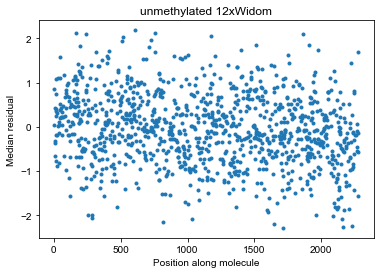

In [135]:
plotResiduals(negResiduals, abaseInd, 'unmethylated 12xWidom')

In [136]:
#save the NN 

NNmodel.save('/home/cmoore/results/pacbio/230720_Hmgb1_acf/230821_Hmgb1_NNmodel')

  0%|          | 0/7 [00:00<?, ?it/s]

total reads:  53414


 14%|█▍        | 1/7 [00:16<01:39, 16.60s/it]

good alignments out of 10000: 7704


 29%|██▊       | 2/7 [00:31<01:18, 15.76s/it]

good alignments out of 10000: 7645


 43%|████▎     | 3/7 [00:47<01:02, 15.57s/it]

good alignments out of 10000: 7774


 57%|█████▋    | 4/7 [01:02<00:46, 15.37s/it]

good alignments out of 10000: 7673


 71%|███████▏  | 5/7 [01:17<00:30, 15.20s/it]

good alignments out of 10000: 7584


 86%|████████▌ | 6/7 [01:19<00:13, 13.24s/it]

good alignments out of 10000: 1082


indices (array([    0,     0,     0, ..., 39461, 39461, 39461]), array([   0,    1,    2, ..., 3476, 3477, 3478]))


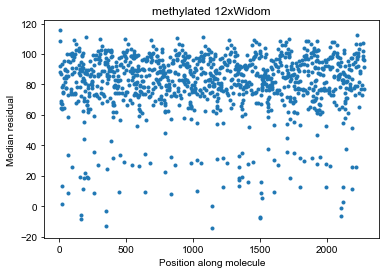

In [137]:
posResiduals, posIpds, posaipd = read_parser(posCCS, svdmodel, NNmodel, 'methylated 12xWidom')

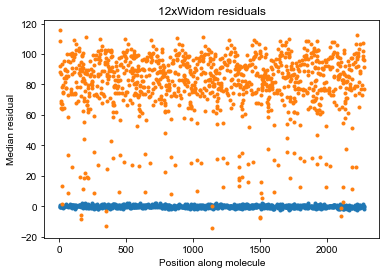

In [143]:

negmed = []

for base in range(negResiduals.shape[1]):
    negmed.append(np.nanmedian(negResiduals[:,base]))

negmed = np.array(negmed)

plt.figure()
plt.plot(abaseInd, negmed, '.')

negmed = []

for base in range(posResiduals.shape[1]):
    negmed.append(np.nanmedian(posResiduals[:,base]))

negmed = np.array(negmed)

plt.plot(abaseInd, negmed, '.')

plt.xlabel('Position along molecule')
plt.ylabel('Median residual')
plt.title('12xWidom residuals')
plt.show()

In [138]:
CPU_LIMIT=70 #number of threads
smmfd, smmFitd, concdat  = smm_trainer(posResiduals, negResiduals[:39462])

100%|██████████| 1077/1077 [5:15:41<00:00, 17.59s/it] 


In [214]:
db = '/home/cmoore/results/pacbio/230720_Hmgb1_acf/'
smmfd.to_csv(db + 'smmfd_NNtrained20230821.csv')

with open(db + 'smmfd_NNtrained20230821.pickle', 'wb') as handle:
    pickle.dump(smmFitd, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(db + 'smmfd_NNtrained20230821.npy', 'wb') as f:
    np.save(f, concdat)

In [159]:
db = '/home/cmoore/results/pacbio/230720_Hmgb1_acf/'
concdat = np.load(db+'smmfd_NNtrained20230821.npy')

smmfd = pd.read_csv(db+'smmfd_NNtrained20230821.csv')
smmfd['cutoff'] = 40
smmfd

Unnamed: 0  basei  threshold   meanlow    meanhigh  weighthigh  \
0              0      0        1.0  0.559822  108.164983    0.487696   
1              1      1        1.0  0.298687   88.162934    0.481515   
2              2      2        1.0 -0.463332  115.205888    0.490313   
3              3      3        1.0 -0.082491   92.146510    0.487537   
4              4      4        1.0 -0.610308   69.460277    0.481756   
...          ...    ...        ...       ...         ...         ...   
1072        1072   1072        1.0  0.742334  101.738192    0.474498   
1073        1073   1073        1.0  2.268774   96.873202    0.473697   
1074        1074   1074        1.0  0.373929   93.017146    0.443903   
1075        1075   1075        1.0 -0.973630  104.998197    0.355810   
1076        1076   1076        1.0  0.146613   77.356394    0.476051   

        lowcut   lowprob        aicd  cutoff  
0     0.999984  0.000016  580.472215      40  
1     0.000571  0.000545  331.375936      40  
2     0.000004  0.000004  553.882339      40  
3     0.000261  0.000248  381.006862      40  
4     0.999296  0.000659  286.398851      40  
...        ...       ...         ...     ...  
1072  0.999893  0.000102  428.426138      40  
1073  0.999852  0.000142  414.690067      40  
1074  0.000287  0.000274  385.942967      40  
1075  0.000083  0.000079  527.661523      40  
1076  0.999634  0.000348  431.131960      40  

[1077 rows x 10 columns]

In [186]:
xfine = np.linspace(0,100,1001)
xfine

array([  0. ,   0.1,   0.2, ...,  99.8,  99.9, 100. ])

In [169]:
preda

array([[9.99478126e-01, 5.21874180e-04],
       [9.99478083e-01, 5.21917316e-04],
       [9.99478040e-01, 5.21960459e-04],
       ...,
       [9.99431763e-01, 5.68236930e-04],
       [9.99431713e-01, 5.68286889e-04],
       [9.99431663e-01, 5.68336857e-04]])

In [183]:
np.abs(preda[:,1] - 0.5) #very unlikely that it would be in the second component, so it's basically -0.5. And of course
#1 is going to thave the highest chance of being in the second component, so this will be the smallest value. AKA value
#that is closest to 50% probability. We want the cutoff to be there. 



array([0.4995887 , 0.49958865, 0.4995886 , ..., 0.49953429, 0.49953424,
       0.49953418])

In [175]:
np.abs(preda[:,1] - 0.5).argmin() #returns the index of the minimum value in the array. and there are 
#1000 iterations of something...

1000

In [165]:
xfine[np.abs(preda[:,1] - 0.5).argmin()]

1.0

In [189]:
# new t-distribution mixture variant
#some methylated adenines may not be slower, trying to fit model to what is and is not methylated 
#mixture model just uses positive and negative controls to determine cutoffs for each adenine

#two components, so one for unmethylated and one for methylated

#a cutoff was found where that residual value was equally likely to originate from either of the two components

#def smm_trainer(posResid, negResid):
posResid = posResiduals
negResid = negResiduals

minmol = min(posResid[:5000].shape[0], negResid[:5000].shape[0])
usemol0 = np.random.choice(np.arange(posResid.shape[0]), size=minmol, replace=False)
usemol1 = np.random.choice(np.arange(negResid.shape[0]), size=minmol, replace=False)
concdat = np.concatenate([posResid[usemol0,:], negResid[usemol1,:]]) #subset of molecules in pos and negative control

smmfd = {'basei':[], 'threshold':[], 'meanlow':[], 'meanhigh':[], 'weighthigh':[], 'lowcut':[],
         'lowprob':[], 'aicd':[], 'cutoff':[]}

smmFitd = {}

for b in tqdm(range(posResid.shape[1]), position=0, smoothing=0): #for each base,
    dat = concdat[:,b]
    usedat = dat[~np.isnan(dat)].reshape(-1,1)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=ConvergenceWarning)
        smm1 = smm.SMM(1, tol=1e-6) #this is the line that uses all the cores and takes 6 hours. fits residuals to the first component, the unmethyalted distribution
        smm1.fit(usedat)
        smm2 = smm.SMM(2, tol=1e-6, n_iter=1000) 
        smm2.fit(usedat)
    smmFitd[b] = smm2 #the second component for each base, aka the methylated distribution

    xfine = np.linspace(0,100,1001) #I changed this to reflect the fact that the values are now in 1 + 50logmeanIPD. The max residuals will be around 100 instead of 1. 
    preda = smm2.predict_proba(xfine.reshape(-1,1)) #this is the prediction for each of these values in xfine that the value came from the second component.
  
    cutoff = xfine[np.abs(preda[:,1] - 0.5).argmin()] #the value in xfine which is closest to having a 50% probability of coming from smm2, the second component.

    lowcut = preda[0,1]
    

    lowcomp = smm2.means_.flatten().argmin()
    highcomp = 1 - lowcomp

    smmfd['basei'].append(b)
    smmfd['threshold'].append(cutoff)
    smmfd['meanlow'].append(smm2.means_[lowcomp][0])
    smmfd['meanhigh'].append(smm2.means_[highcomp][0])
    smmfd['weighthigh'].append(smm2.weights_[highcomp])
    smmfd['lowcut'].append(lowcut)
    smmfd['lowprob'].append(smm2.predict_proba(np.array([-0.4]).reshape(-1,1))[0,highcomp])
    smmfd['aicd'].append(smm1.aic(usedat) - smm2.aic(usedat))
    smmfd['cutoff'].append(cutoff)

smmfd = pd.DataFrame(smmfd)

    #return smmfd, smmFitd, concdat

100%|██████████| 1077/1077 [1:58:02<00:00,  6.58s/it]


In [206]:
smmfd

basei  threshold   meanlow    meanhigh  weighthigh    lowcut   lowprob  \
0         0       55.9  1.249113  108.109946    0.491509  0.000013  0.000013   
1         1       42.0  0.232130   87.987973    0.485390  0.998970  0.000989   
2         2       55.8 -0.230086  114.761475    0.494578  0.999995  0.000004   
3         3       45.8  0.251578   92.794467    0.487454  0.000186  0.000177   
4         4       35.7  0.031034   69.527004    0.479739  0.999529  0.000439   
...     ...        ...       ...         ...         ...       ...       ...   
1072   1072       50.8  0.254678  101.811399    0.474005  0.999924  0.000072   
1073   1073       48.1  1.684897   96.491737    0.471898  0.000142  0.000136   
1074   1074       44.9 -0.004744   93.334099    0.444556  0.999707  0.000279   
1075   1075       52.5 -1.020304  105.120939    0.359944  0.000087  0.000084   
1076   1076       38.0  0.230580   77.279866    0.474372  0.000340  0.000323   

           aicd  cutoff  
0     66.599851    55.9  
1     32.624184    42.0  
2     64.802191    55.8  
3     41.119358    45.8  
4     28.784834    35.7  
...         ...     ...  
1072  45.295464    50.8  
1073  44.894448    48.1  
1074  38.455112    44.9  
1075  60.239520    52.5  
1076  46.377524    38.0  

[1077 rows x 9 columns]

In [204]:

def thresholder(negResiduals, posResiduals):
    minmol = min(posResiduals.shape[0], negResiduals.shape[0])
    usemol0 = np.random.choice(np.arange(posResiduals.shape[0]), size=minmol, replace=False)
    usemol1 = np.random.choice(np.arange(negResiduals.shape[0]), size=minmol, replace=False)
    concdat = np.concatenate([posResiduals[usemol0,:], negResiduals[usemol1,:]])

    dfrac = [] #data fraction, fraction of training data above cutoff
    for b in tqdm(range(posResiduals.shape[1]), position=0, smoothing=0):
        dat = concdat[:,b]
        usedat = dat[~np.isnan(dat)].reshape(-1,1)

        dfrac.append(np.mean( usedat > smmfd['cutoff'][b]))
    dfrac = np.array(dfrac)

    # look at rate of calling in pos and neg control for the cutoff

    posfrac = [] # fraction of positive control data called as methylated
    negfrac = [] # fraction of negative control data called as methylated

    for b in tqdm(range(posResiduals.shape[1]), position=0, smoothing=0):
        pdat = posResiduals[:,b]
        usepdat = pdat[~np.isnan(pdat)]

        posfrac.append(np.mean(usepdat > smmfd['cutoff'][b]))

        ndat = negResiduals[:,b]
        usendat = ndat[~np.isnan(ndat)]

        negfrac.append(np.mean(usendat > smmfd['cutoff'][b]))

    posfrac = np.array(posfrac)
    negfrac = np.array(negfrac)
    
    passfilt = np.logical_and.reduce([(smmfd['meanhigh'] - smmfd['meanlow']).to_numpy() > 30,
                                       # first filter criteria: the difference between the mean of the two subpopulations is
                                       # over some threshhold 
                                      smmfd['meanhigh'] > 60,
                                      # second criteria, the subpopulation with the higher mean, has a mean greater than zero
                                      dfrac > 0.02])
                                      # third criteria, the adenine has a cutoff that more than X% of data is predicted methylated
    
    goodbase = np.nonzero(passfilt)[0]
    badbase = np.nonzero(~passfilt)[0]

    print(len(goodbase))
    print(len(badbase))
    
    plt.figure(figsize=(6,6))
    plt.plot(posfrac[goodbase], negfrac[goodbase], 'b.', ms=3, label='Methylation called')
    plt.plot(posfrac[badbase], negfrac[badbase], 'r.', ms=3, label='Not used')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('Fraction of positive control called as methylated')
    plt.ylabel('Fraction of negative control called as methylated')
    plt.legend()
    return goodbase, badbase


In [145]:
def binarizer(residuals):
    resid = residuals
    methbin = np.full(resid.shape, np.nan, dtype=np.float32)
    
    for b in range(methbin.shape[1]):
        if b in goodbase:
            hasmeasure = ~np.isnan(resid[:,b])
            methbin[hasmeasure,b] = resid[hasmeasure,b] > smmfd['threshold'][b]

    return(methbin)

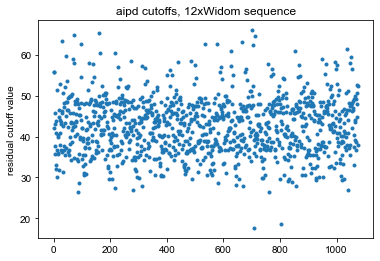

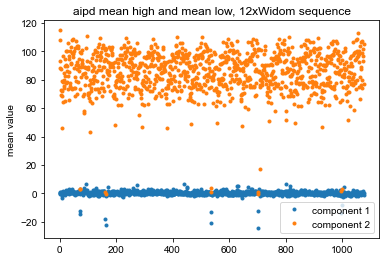

In [210]:
plt.title('aipd cutoffs, 12xWidom sequence')
plt.plot(smmfd['cutoff'], ".")
plt.ylabel('residual cutoff value')

plt.figure()
plt.title('aipd mean high and mean low, 12xWidom sequence')
plt.ylabel('mean value')
plt.plot(smmfd['meanlow'], '.', label='component 1')
plt.plot(smmfd['meanhigh'], '.', label='component 2')
plt.legend()

100%|██████████| 1077/1077 [00:03<00:00, 303.21it/s]


1046
31


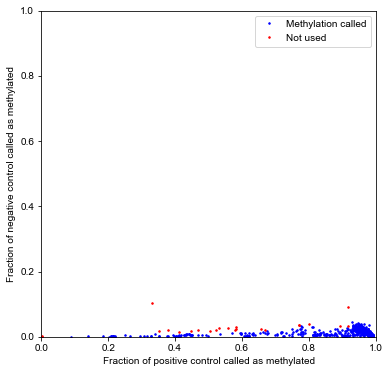

In [205]:

#smmfd = pd.read_csv('/home/cmoore/results/pacbio/Cyp3a11_models_controls/smmfd_weights_ccs4.99.csv')
#smmfd = pd.read_csv('/home/cmoore/results/pacbio/230720_Hmgb1_acf/smmfd_NNtrained20230728.csv')


goodbase, badbase = thresholder(negResiduals, posResiduals)

#binarize neg, positive control and set hmm 

posmethpred = binarizer(posResiduals)
negmethpred = binarizer(negResiduals)




In [215]:
smmfd

basei  threshold   meanlow    meanhigh  weighthigh    lowcut   lowprob  \
0         0       55.9  1.249113  108.109946    0.491509  0.000013  0.000013   
1         1       42.0  0.232130   87.987973    0.485390  0.998970  0.000989   
2         2       55.8 -0.230086  114.761475    0.494578  0.999995  0.000004   
3         3       45.8  0.251578   92.794467    0.487454  0.000186  0.000177   
4         4       35.7  0.031034   69.527004    0.479739  0.999529  0.000439   
...     ...        ...       ...         ...         ...       ...       ...   
1072   1072       50.8  0.254678  101.811399    0.474005  0.999924  0.000072   
1073   1073       48.1  1.684897   96.491737    0.471898  0.000142  0.000136   
1074   1074       44.9 -0.004744   93.334099    0.444556  0.999707  0.000279   
1075   1075       52.5 -1.020304  105.120939    0.359944  0.000087  0.000084   
1076   1076       38.0  0.230580   77.279866    0.474372  0.000340  0.000323   

           aicd  cutoff  
0     66.599851    55.9  
1     32.624184    42.0  
2     64.802191    55.8  
3     41.119358    45.8  
4     28.784834    35.7  
...         ...     ...  
1072  45.295464    50.8  
1073  44.894448    48.1  
1074  38.455112    44.9  
1075  60.239520    52.5  
1076  46.377524    38.0  

[1077 rows x 9 columns]

In [211]:
from pomegranate import HiddenMarkovModel, State, BernoulliDistribution


# get the indices of adenines where methylation was predicted
goodInd = np.sum(np.isnan(negmethpred), axis=0) < negmethpred.shape[0]

refis = {n: np.array([b is n for b in refseq]) for n in ['A','C','G','T']}

abaseInd = np.nonzero(np.logical_or(refis['A'], refis['T']))[0]

goodBase = abaseInd[goodInd]

goodIndInd = np.nonzero(goodInd)[0]


# Find the probability of each good base being predicted as methylated in negative and positive controls  
posmprob = np.full((len(abaseInd)), np.nan)
for i in range(len(abaseInd)):
    if goodInd[i]:
        hasmeasure = ~np.isnan(posmethpred[:,i])
        posmprob[i] = (np.sum(posmethpred[hasmeasure,i] == 1) + .5) / (np.sum(hasmeasure) + .5)

negmprob = np.full((len(abaseInd)), np.nan)
for i in range(len(abaseInd)):
    if goodInd[i]:
        hasmeasure = ~np.isnan(negmethpred[:,i])
        negmprob[i] = (np.sum(negmethpred[hasmeasure,i] == 1) + .5) / (np.sum(hasmeasure) + .5)


In [212]:
# now create an HMM model with an accessible and inaccessible state for every predicted adenine
# Incorporating the probabilities from the negative and positive controls as expectations for methylation being
# predicted in either accessible or inaccessible states

AcAd = []
InacAd = []

for ib, b in enumerate(goodIndInd):
    AcAd.append(State(BernoulliDistribution(posmprob[b]), name="Ac_{0}".format(ib)))
    InacAd.append(State(BernoulliDistribution(negmprob[b]), name="Inac_{0}".format(ib)))
    
model = HiddenMarkovModel()
model.add_states(AcAd)
model.add_states(InacAd)
model.add_transition(model.start, AcAd[0], 0.5)
model.add_transition(model.start, InacAd[0], 0.5)

for b in np.arange(len(goodIndInd)-1):
    dist = abaseInd[goodIndInd[b+1]] - abaseInd[goodIndInd[b]]
    stayInacP = (1 - 1/1000)**dist
    model.add_transition(InacAd[b], InacAd[b+1], stayInacP)
    model.add_transition(InacAd[b], AcAd[b+1], 1 - stayInacP)
    stayAcP = (1 - 1/1000)**dist
    model.add_transition(AcAd[b], AcAd[b+1], stayAcP)
    model.add_transition(AcAd[b], InacAd[b+1], 1 - stayAcP)
    
model.add_transition(AcAd[len(goodIndInd)-1], model.end, 1)
model.add_transition(InacAd[len(goodIndInd)-1], model.end, 1)
model.bake()

In [97]:
db


'/home/cmoore/results/pacbio/230720_Hmgb1_acf/ccs_split_12xwidom/ccs_align/'

In [126]:
# Now with the complete model, open up each sample and use viterbi to find the most likely sequence of accessible
# and inaccessible states given the observed methylation predictions in each molecule

def hmm_solver(methpreds, sampleName):  
    refbases = np.arange(len(refseq))
    hmmRes = np.full((methpreds.shape[0], len(refseq)), np.nan)
    for im in tqdm(np.arange(methpreds.shape[0]), position=0, smoothing=0.001, mininterval=20):

        path = model.viterbi(methpreds[im,goodInd])

        pathRes = np.full(len(goodIndInd), np.nan)

        for p in path[1]:
            psplit = p[1].name.split('_')
            if len(psplit) > 1:
                if psplit[0] == 'Ac':
                    pathRes[int(psplit[1])] = 1
                if psplit[0] == 'Inac':
                    pathRes[int(psplit[1])] = 0

        hmmRes[im,:] = np.interp(refbases, goodBase, pathRes)
        
    np.save('/home/cmoore/results/pacbio/230720_Hmgb1_acf/ccs_split_12xwidom/ccs_align/' + sampleName + '_HMM.npy',
            arr = hmmRes)
        
    heatmapper(hmmRes, sampleName) #graph it and save the heatmap 
    
    return(hmmRes)
    
def heatmapper(hmmRes, sampleName):
    cmapbin = matplotlib.colors.LinearSegmentedColormap.from_list('custom cmap', ['#8ae0e3','#722685'], 3) #['midnightblue', 'coral']
    bounds = np.array([-0.5, .5, 1.5])
    norm = matplotlib.colors.BoundaryNorm(bounds, cmapbin.N)
    
    plt.figure(figsize=(12,12))
    plt.title(sampleName)
    plt.imshow(hmmRes, aspect='auto', interpolation='none',cmap = cmapbin, norm=norm)
    plt.ylabel('Molecules')
    plt.xlabel('Position along molecule')
    
    


100%|██████████| 1000/1000 [00:52<00:00, 18.90it/s]


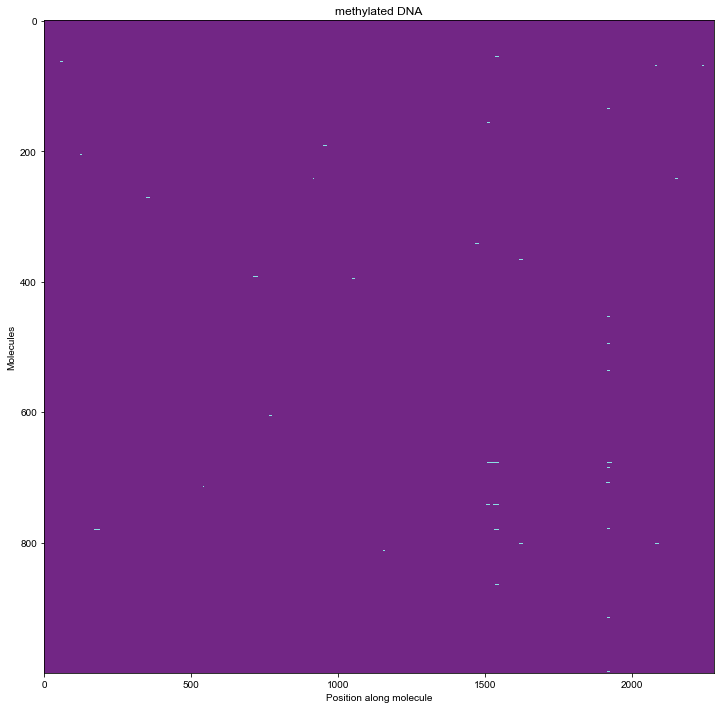

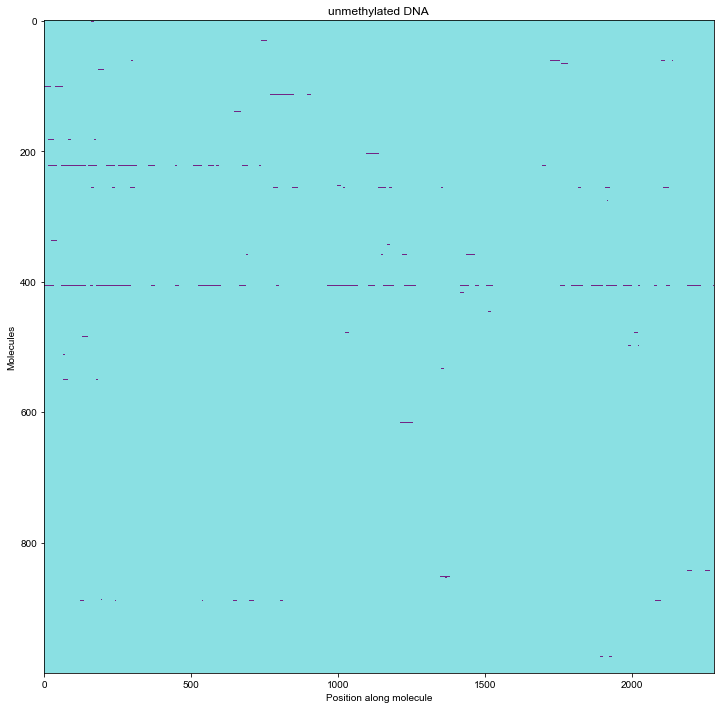

In [213]:
#make heat maps for controls 

hmmArr = hmm_solver(posmethpred[:1000], 'methylated DNA')
hmmArr = hmm_solver(negmethpred[:1000], 'unmethylated DNA')



In [ ]:
db = '/home/cmoore/results/pacbio/230720_Hmgb1_acf/ccs_split_12xwidom/ccs_align/'
filelist = {'100nM':'ccs.Hmgb1_100nM--Hmgb1_100nM.bam', '500nM':'ccs.Hmgb1_500nM--Hmgb1_500nM.bam', "2.5uM":'ccs.Hmgb1_2_5uM--Hmgb1_2_5uM.bam'}
arrays = {}
for file in filelist:
    fullname = db+filelist[file]
    binarized_arr, hmmArr = main_read_parser(fullname, svdmodel, NNmodel, file)
    arrays[file] = hmmArr


  0%|          | 0/18 [00:00<?, ?it/s]

total reads:  164254


  6%|▌         | 1/18 [00:17<05:00, 17.70s/it]

good alignments out of 10000: 8050


 11%|█         | 2/18 [00:35<04:42, 17.67s/it]

good alignments out of 10000: 7981


 17%|█▋        | 3/18 [00:52<04:23, 17.55s/it]

good alignments out of 10000: 7901


 22%|██▏       | 4/18 [01:10<04:05, 17.53s/it]

good alignments out of 10000: 7906


 28%|██▊       | 5/18 [01:27<03:46, 17.45s/it]

good alignments out of 10000: 7943


 33%|███▎      | 6/18 [01:45<03:29, 17.50s/it]

good alignments out of 10000: 7948


 39%|███▉      | 7/18 [02:02<03:13, 17.55s/it]

good alignments out of 10000: 7971


 44%|████▍     | 8/18 [02:20<02:56, 17.68s/it]

good alignments out of 10000: 8119


 50%|█████     | 9/18 [02:38<02:39, 17.74s/it]

good alignments out of 10000: 7969


 56%|█████▌    | 10/18 [02:56<02:22, 17.77s/it]

good alignments out of 10000: 8037


 61%|██████    | 11/18 [03:14<02:04, 17.73s/it]

good alignments out of 10000: 7981


 67%|██████▋   | 12/18 [03:31<01:46, 17.71s/it]

good alignments out of 10000: 8054


 72%|███████▏  | 13/18 [03:50<01:29, 17.88s/it]

good alignments out of 10000: 8074


 78%|███████▊  | 14/18 [04:07<01:11, 17.79s/it]

good alignments out of 10000: 8006


 83%|████████▎ | 15/18 [04:25<00:53, 17.81s/it]

good alignments out of 10000: 8134


 89%|████████▉ | 16/18 [04:39<00:33, 16.75s/it]

good alignments out of 10000: 6382


 94%|█████████▍| 17/18 [04:43<00:16, 16.66s/it]

good alignments out of 10000: 1333


indices (array([     0,      0,      0, ..., 127788, 127788, 127788]), array([   0,    1,    2, ..., 3476, 3477, 3478]))


 44%|████▍     | 55975/127789 [56:45<1:12:40, 16.47it/s]

In [102]:
arrays.keys()

dict_keys(['100nM', '500nM', '2.5uM'])

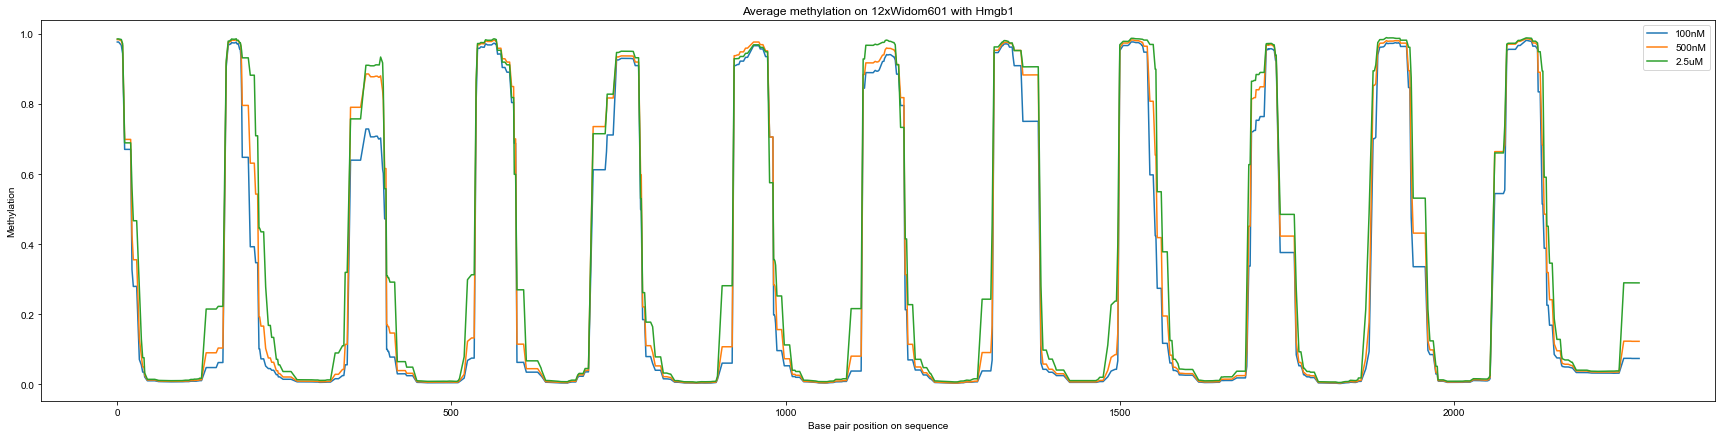

In [103]:
plt.figure(figsize=(30,7))
plt.title('Average methylation on 12xWidom601 with Hmgb1')
plt.ylabel('Methylation')
plt.xlabel('Base pair position on sequence')
for file in arrays:

    #hmmArr = np.load(db + sampleName + '_HMM.npy')
    plt.plot(np.nanmean(arrays[file], axis=0), label=file)

plt.legend()

  0%|          | 0/2 [00:00<?, ?it/s]

total reads:  134783


 50%|█████     | 1/2 [00:10<00:10, 10.15s/it]

good alignments out of 10000: 4078


indices (array([   0,    0,    0, ..., 4077, 4077, 4077]), array([   0,    1,    2, ..., 3476, 3477, 3478]))


100%|██████████| 1000/1000 [01:16<00:00, 13.02it/s]


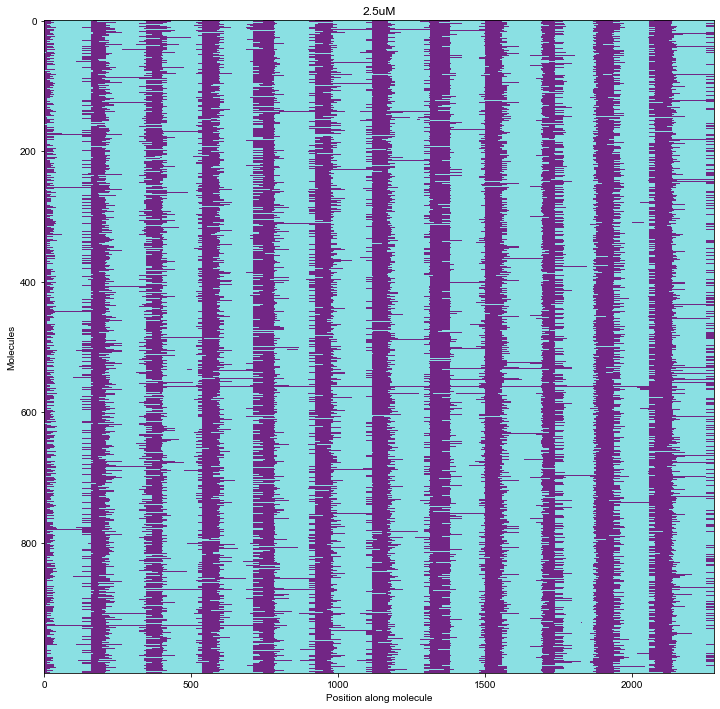

In [83]:
db = '/home/cmoore/results/pacbio/230720_Hmgb1_acf/ccs_split_12xwidom/ccs_align/'
filelist = {"2.5uM":'ccs.Hmgb1_2_5uM--Hmgb1_2_5uM.bam'}

for file in filelist:
    fullname = db+filelist[file]
    binarized_arr, hmmArr = main_read_parser(fullname, svdmodel, NNmodel, file)


  0%|          | 0/7 [00:00<?, ?it/s]

total reads:  54186


 86%|████████▌ | 6/7 [01:49<00:18, 18.28s/it]


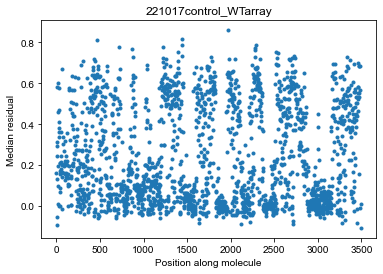

100%|██████████| 1000/1000 [02:45<00:00,  6.05it/s]


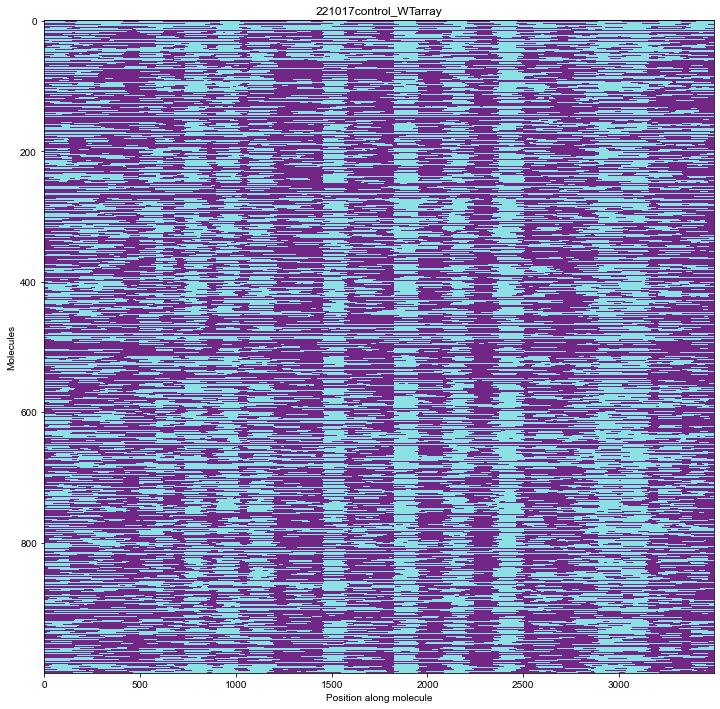

In [26]:
binarized_arr, hmmArr = main_read_parser('/home/cmoore/results/pacbio/221017_ACFHP1RSC_WTH3k9me3Cyp/ccs_align/ccs.221011_WT_Cntrl--221011_WT_Cntrl.bam', svdmodel, NNmodel, '221017control_WTarray')

  0%|          | 0/5 [00:00<?, ?it/s]

total reads:  34886


 80%|████████  | 4/5 [01:07<00:16, 16.88s/it]


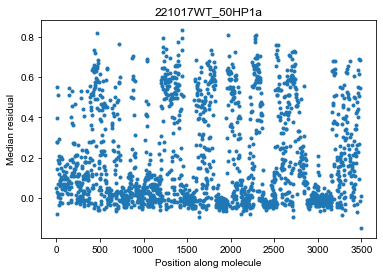

100%|██████████| 1000/1000 [02:30<00:00,  6.62it/s]


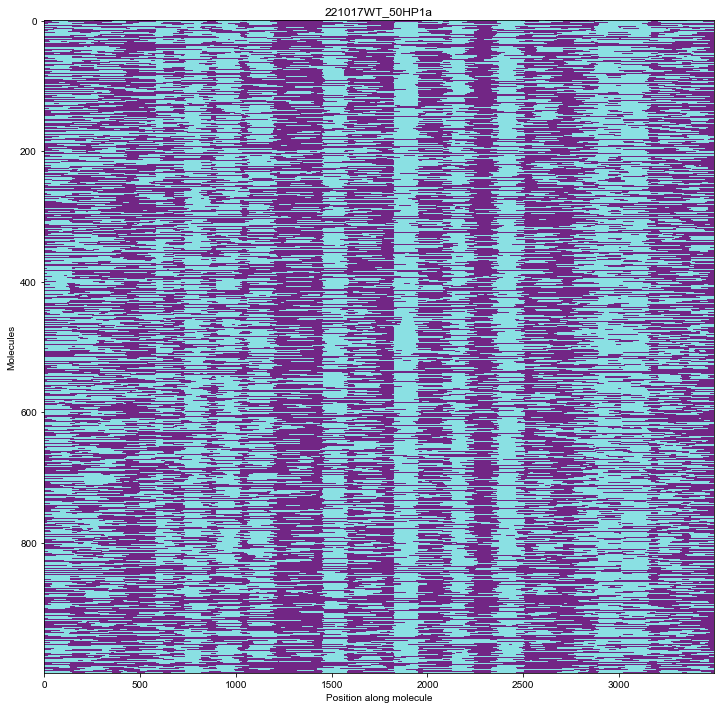

In [27]:
binarized_arr, hmmArr = main_read_parser('/home/cmoore/results/pacbio/221017_ACFHP1RSC_WTH3k9me3Cyp/ccs_align/ccs.221011_WT_50HP1a--221011_WT_50HP1a.bam', svdmodel, NNmodel, '221017WT_50HP1a')

  0%|          | 0/6 [00:00<?, ?it/s]

total reads:  43688


 83%|████████▎ | 5/6 [01:29<00:17, 17.95s/it]


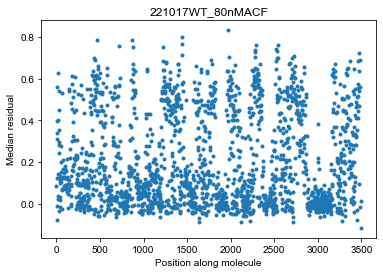

100%|██████████| 1000/1000 [02:12<00:00,  7.56it/s]


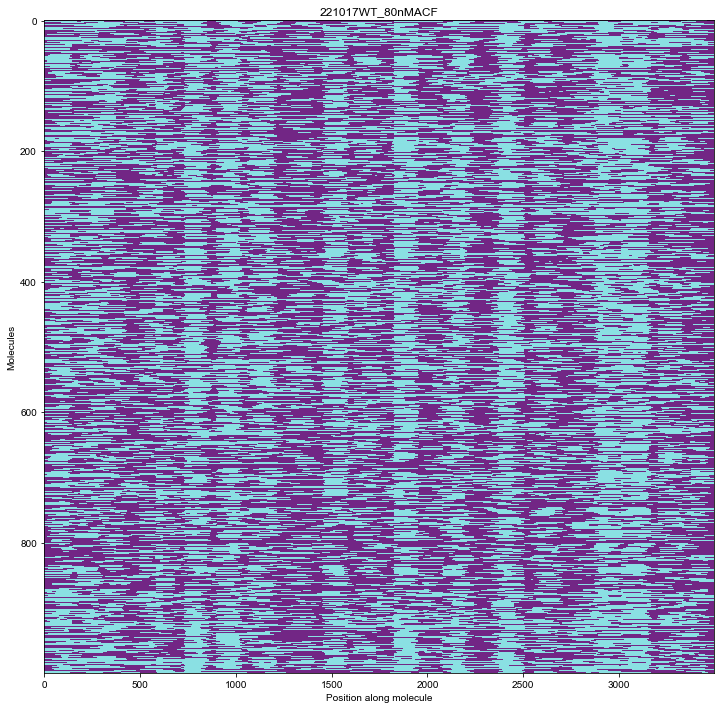

In [28]:
binarized_arr, hmmArr = main_read_parser('/home/cmoore/results/pacbio/221017_ACFHP1RSC_WTH3k9me3Cyp/ccs_align/ccs.221011_WT_80ACF__ATP--221011_WT_80ACF__ATP.bam', svdmodel, NNmodel, '221017WT_80nMACF')

  0%|          | 0/7 [00:00<?, ?it/s]

total reads:  51450


 86%|████████▌ | 6/7 [01:39<00:16, 16.51s/it]


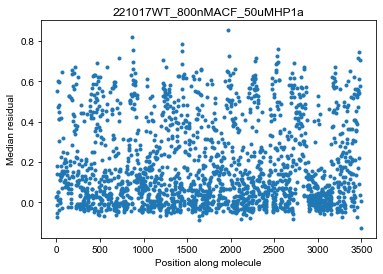

100%|██████████| 1000/1000 [02:10<00:00,  7.64it/s]


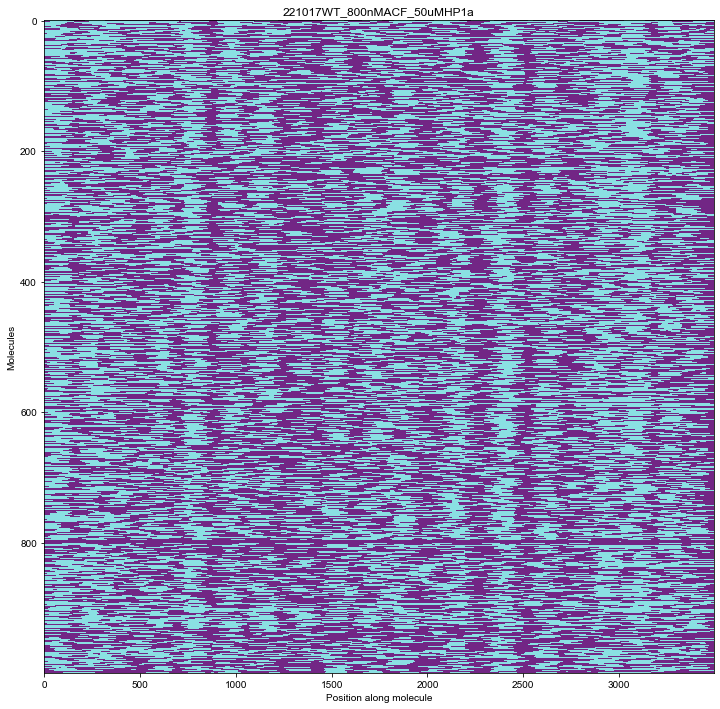

In [29]:
binarized_arr, hmmArr = main_read_parser('/home/cmoore/results/pacbio/221017_ACFHP1RSC_WTH3k9me3Cyp/ccs_align/ccs.221011_WT_800ACF_50HP1a_ATP--221011_WT_800ACF_50HP1a_ATP.bam', svdmodel, NNmodel, '221017WT_800nMACF_50uMHP1a')

  0%|          | 0/6 [00:00<?, ?it/s]

total reads:  40624


 83%|████████▎ | 5/6 [01:23<00:16, 16.73s/it]


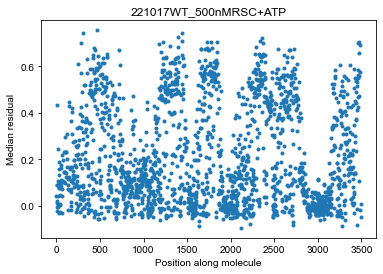

100%|██████████| 1000/1000 [02:11<00:00,  7.59it/s]


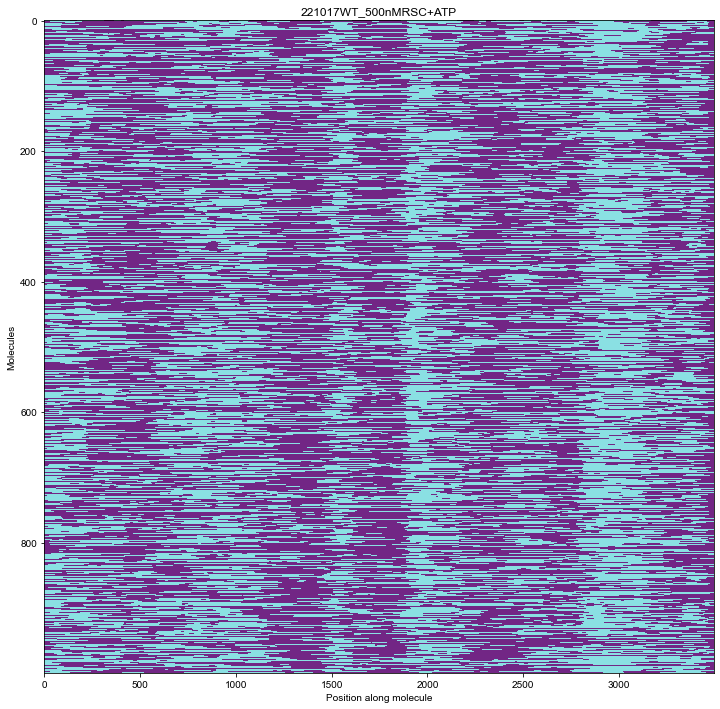

In [30]:
binarized_arr, hmmArr = main_read_parser('/home/cmoore/results/pacbio/221017_ACFHP1RSC_WTH3k9me3Cyp/ccs_align/ccs.221011_WT_RSC_ATP--221011_WT_RSC_ATP.bam', svdmodel, NNmodel, '221017WT_500nMRSC+ATP')

  0%|          | 0/4 [00:00<?, ?it/s]

total reads:  29771


 75%|███████▌  | 3/4 [00:57<00:19, 19.09s/it]


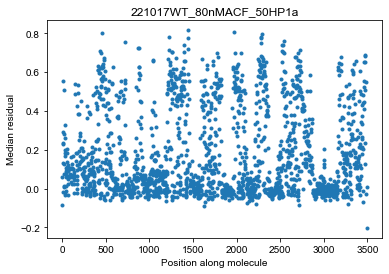

100%|██████████| 1000/1000 [02:10<00:00,  7.65it/s]


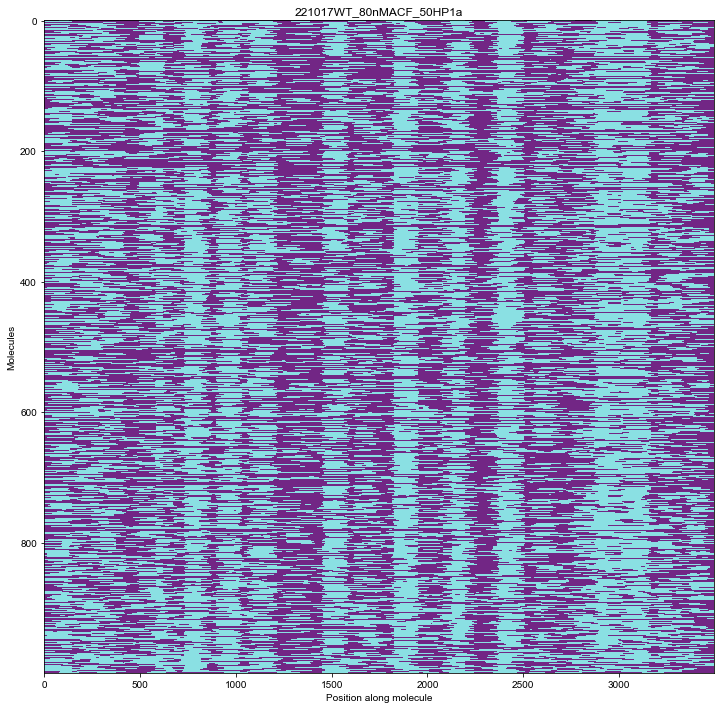

In [31]:
binarized_arr, hmmArr = main_read_parser('/home/cmoore/results/pacbio/221017_ACFHP1RSC_WTH3k9me3Cyp/ccs_align/ccs.221011_WT_80ACF_50HP1a_ATP--221011_WT_80ACF_50HP1a_ATP.bam', svdmodel, NNmodel, '221017WT_80nMACF_50HP1a')

  0%|          | 0/7 [00:00<?, ?it/s]

total reads:  56464


 86%|████████▌ | 6/7 [01:49<00:18, 18.24s/it]


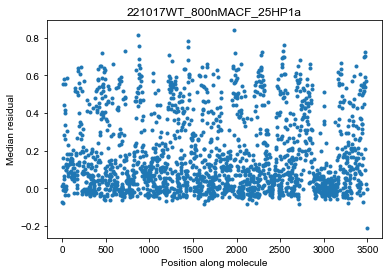

100%|██████████| 1000/1000 [02:10<00:00,  7.68it/s]


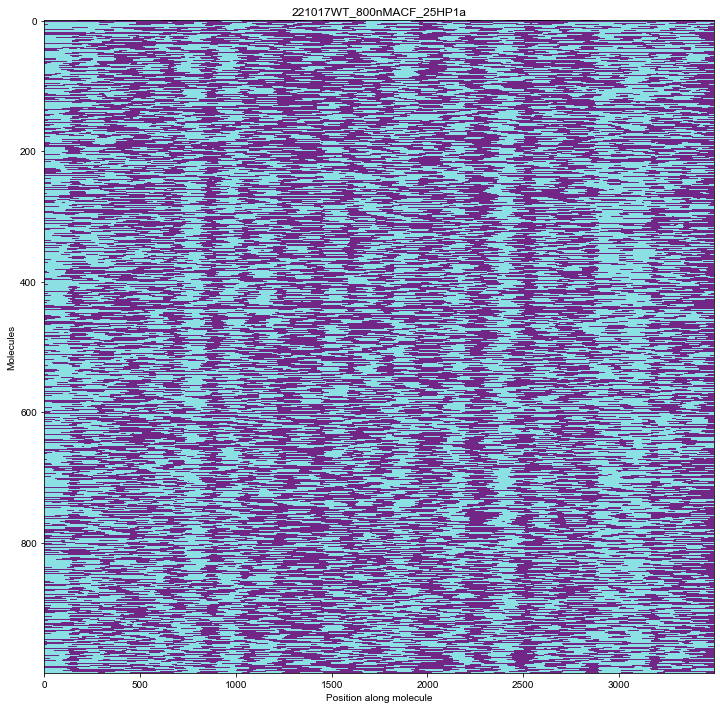

In [32]:
binarized_arr, hmmArr = main_read_parser('/home/cmoore/results/pacbio/221017_ACFHP1RSC_WTH3k9me3Cyp/ccs_align/ccs.221011_WT_800ACF_25HP1a_ATP--221011_WT_800ACF_25HP1a_ATP.bam', svdmodel, NNmodel, '221017WT_800nMACF_25HP1a')

  0%|          | 0/5 [00:00<?, ?it/s]

total reads:  36253


 80%|████████  | 4/5 [01:11<00:17, 17.88s/it]


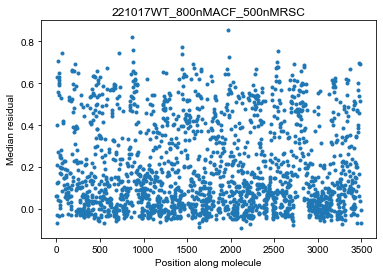

100%|██████████| 1000/1000 [02:10<00:00,  7.64it/s]


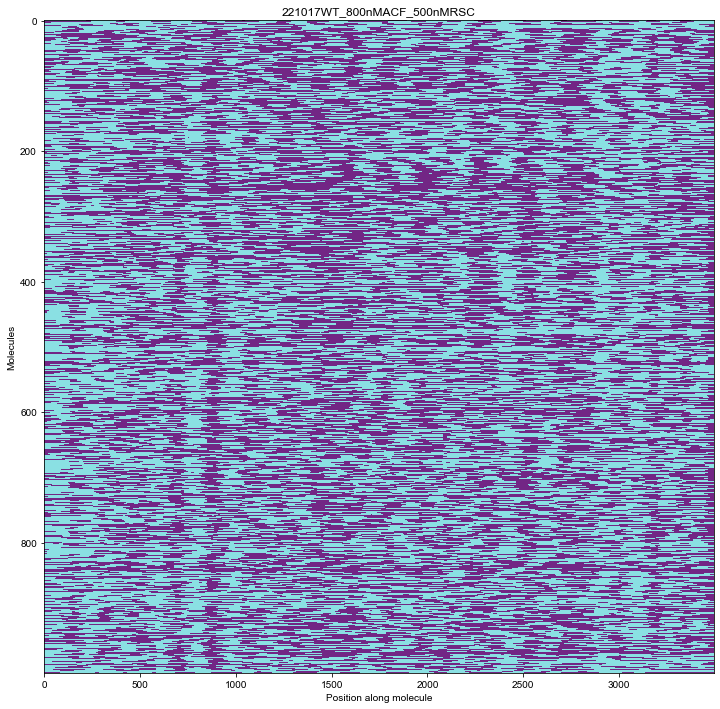

In [33]:
binarized_arr, hmmArr = main_read_parser('/home/cmoore/results/pacbio/221017_ACFHP1RSC_WTH3k9me3Cyp/ccs_align/ccs.221011_WT_800ACF_RSC_ATP--221011_WT_800ACF_RSC_ATP.bam', svdmodel, NNmodel, '221017WT_800nMACF_500nMRSC')

  0%|          | 0/15 [00:00<?, ?it/s]

total reads:  138275


 93%|█████████▎| 14/15 [04:28<00:19, 19.15s/it]


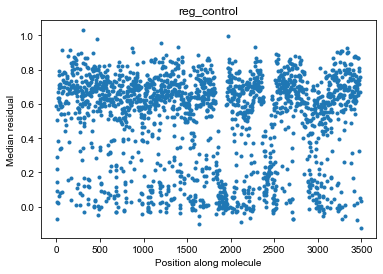

  0%|          | 0/18 [00:00<?, ?it/s]

total reads:  163689


 94%|█████████▍| 17/18 [05:16<00:18, 18.64s/it]


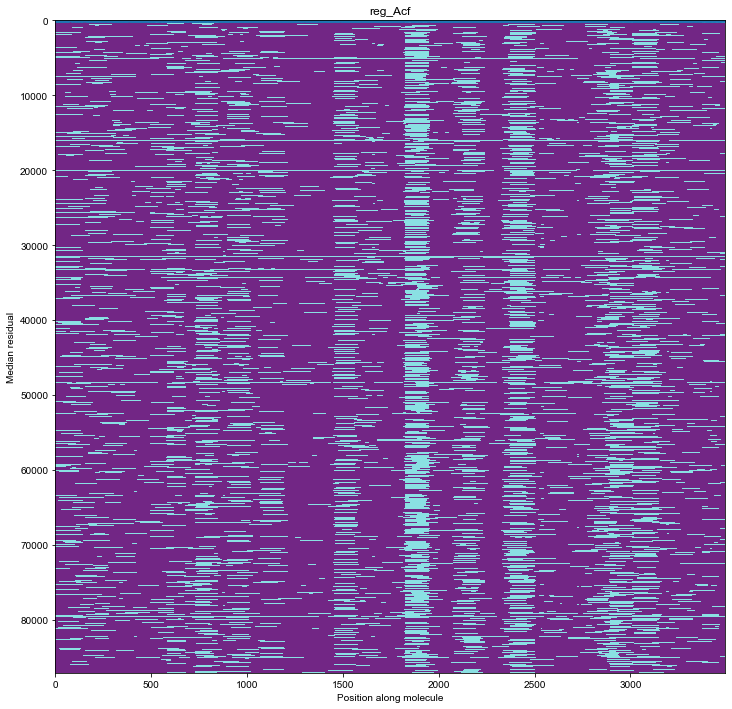

  0%|          | 0/16 [00:00<?, ?it/s]

total reads:  143007


 94%|█████████▍| 15/16 [04:39<00:18, 18.66s/it]


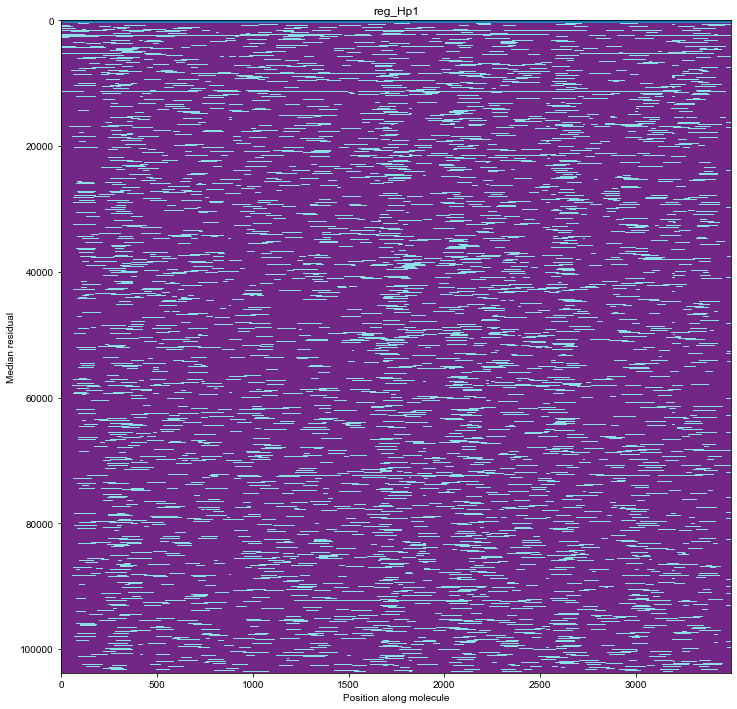

  0%|          | 0/18 [00:00<?, ?it/s]

total reads:  167462


 94%|█████████▍| 17/18 [05:23<00:19, 19.00s/it]


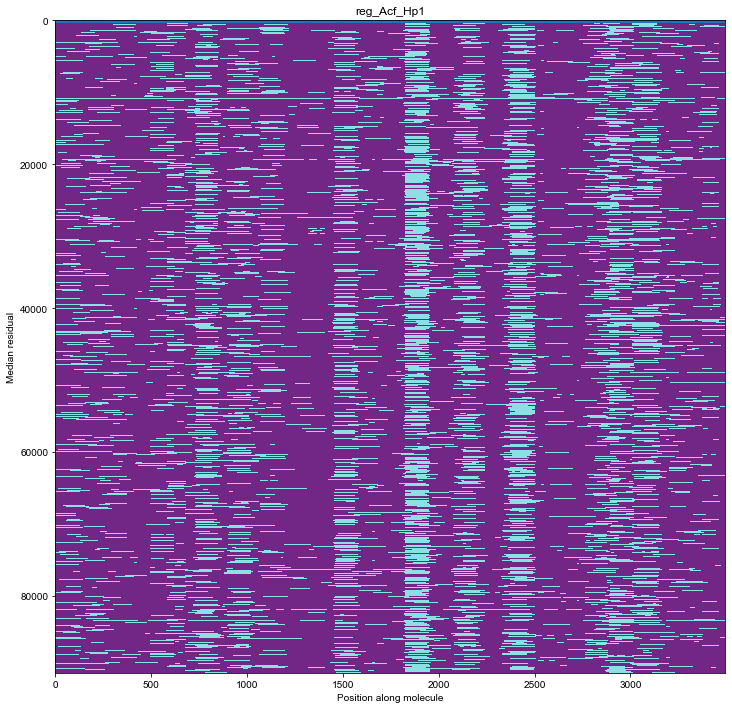

  0%|          | 0/16 [00:00<?, ?it/s]

total reads:  143544


 94%|█████████▍| 15/16 [04:42<00:18, 18.80s/it]


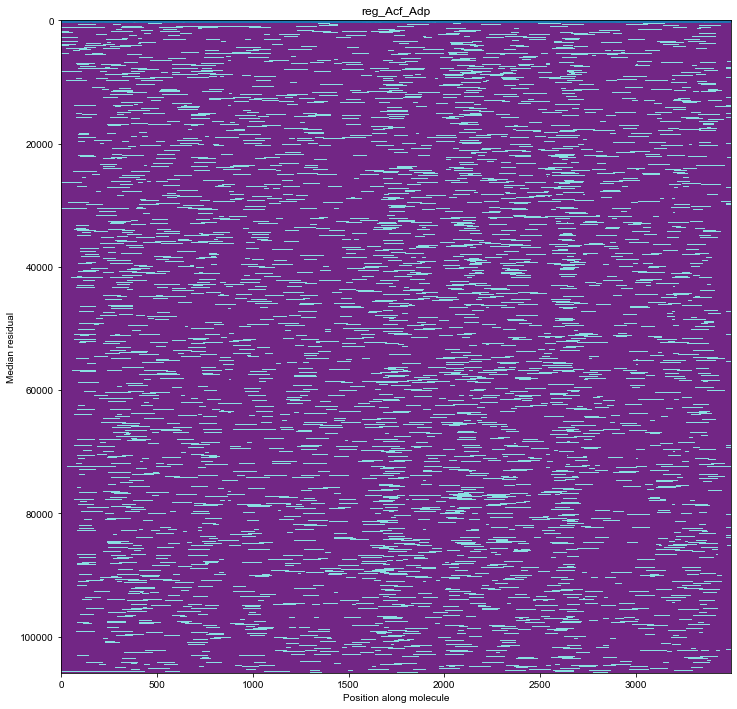

100%|██████████| 91584/91584 [3:19:48<00:00,  7.64it/s]  


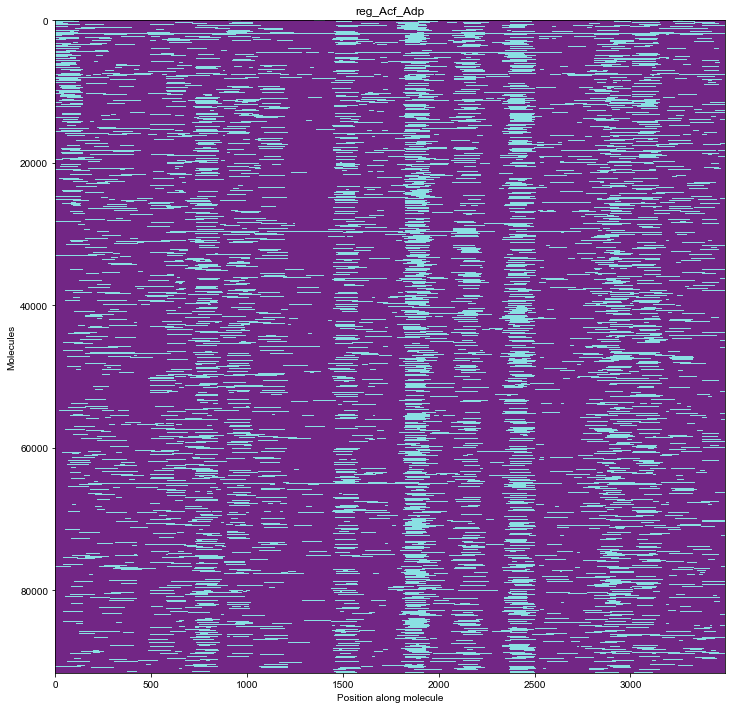

In [69]:
#process the in solution remodeling stuff from 220909
db = '/home/cmoore/results/pacbio/220908_slnACF_HP1a_GPCctrl/ccs_align/'

reg_control = 'ccs.regOct_control--regOct_control.bam'
reg_Acf ='ccs.regOct_ACF--regOct_ACF.bam'
reg_Hp1 = 'ccs.regOct_HP1--regOct_HP1.bam'
reg_Acf_Hp1 = 'ccs.regOct_ACF_HP1--regOct_ACF_HP1.bam'
reg_Acf_Adp = 'ccs.regOct_ACF_ADP--regOct_ACF_ADP.bam'
H3k9_control = 'ccs.H3K9_control--H3K9_control.bam'
H3k9_Acf = 'ccs.H3K9_ACF--H3K9_ACF.bam'
H3k9_Hp1 = 'ccs.H3K9_HP1--H3K9_HP1.bam'
H3k9_Acf_Hp1 = 'ccs.H3K9_ACF_HP1--H3K9_ACF_HP1.bam'
H3k9_Acf_Adp = 'ccs.H3K9_ACF_ADP--H3K9_ACF_ADP.bam'

samples = {'reg_control':reg_control, 'reg_Acf':reg_Acf, 'reg_Hp1':reg_Hp1, 'reg_Acf_Hp1':reg_Acf_Hp1, 'reg_Acf_Adp':reg_Acf_Adp, 'H3k9_control':H3k9_control, 'H3k9_Acf':H3k9_Acf, 'H3k9_Hp1':H3k9_Hp1, 'H3k9_Acf_Hp1':H3k9_Acf_Hp1, 'H3k9_Acf_Adp':H3k9_Acf_Adp}

for sampleName in samples:
    if samples[sampleName] in samps:
        continue
    fullFile = db + samples[sampleName]
    binarized_arr, hmmArr = main_read_parser(fullFile, svdmodel, NNmodel, sampleName)
    #hmmArr = hmm_solver(binarized_arr[:1000], sampleName)
    

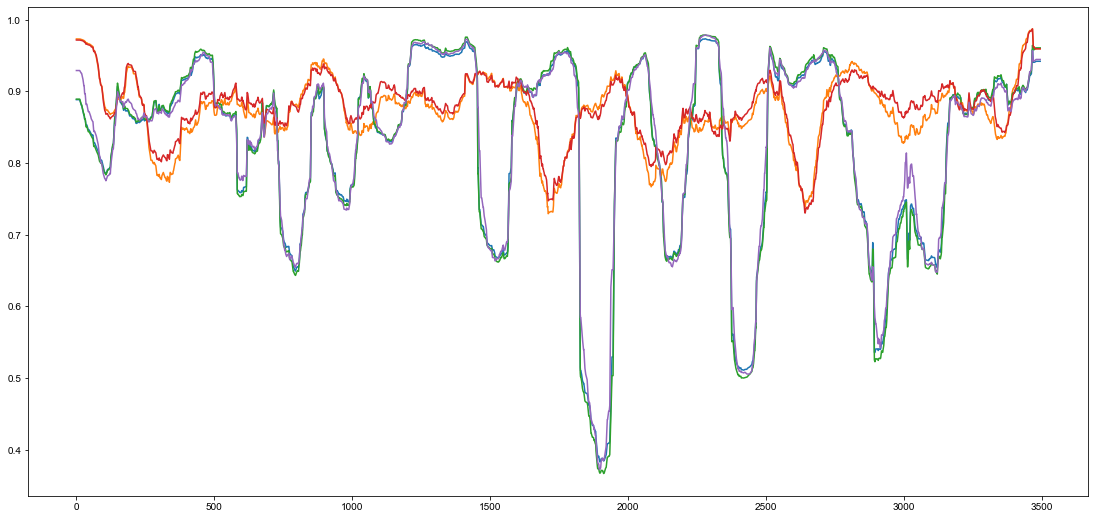

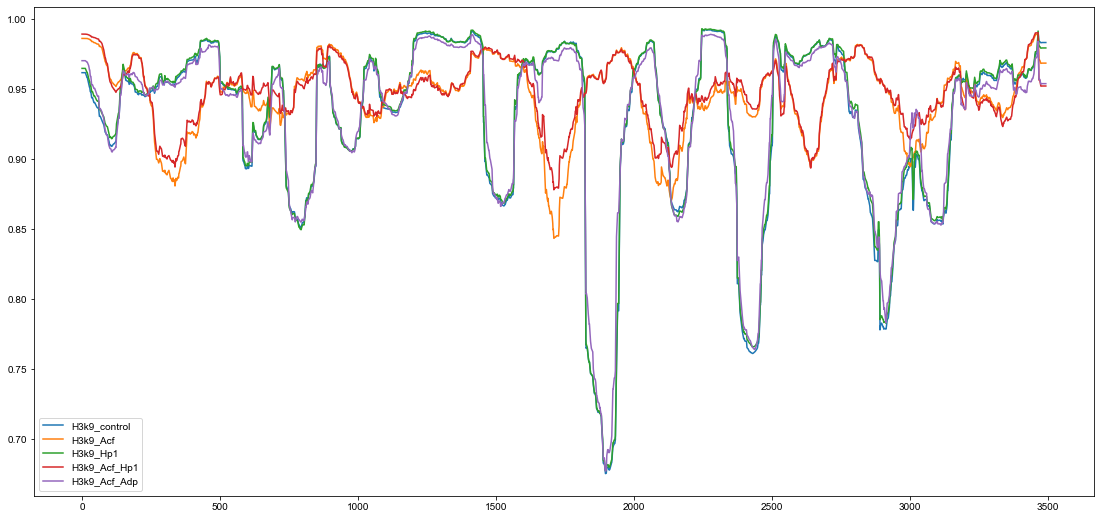

In [72]:
# m6a_chrom25_arr = np.load('/home/cmoore/results/pacbio/220627_cardamomA01_CM/2.5ugoct_080422chromatin_Adenines_HMM.npy')
# m6a_chrom385_arr = np.load('/home/cmoore/results/pacbio/220627_cardamomA01_CM/3.85ugoct_080422chromatin_Adenines_HMM.npy')
# tentoone_arr = np.load('/home/cmoore/results/pacbio/211101_CM_Cyp3a11_HP1/211101_CM_Cyp3a11_HP1_Cyp3a11_10to_rep1_HMM.npy')
# sixtoone_arr = np.load('/home/cmoore/results/pacbio/211101_CM_Cyp3a11_HP1/211101_CM_Cyp3a11_HP1_Cyp3a11_6to_rep1_HMM.npy')
db = '/home/cmoore/results/pacbio/220908_slnACF_HP1a_GPCctrl/heatmaps/'

plt.figure(figsize=(19,9))
for sampleName in samples:
    if sampleName == 'H3k9_control':
        plt.figure(figsize=(19,9))
    hmmArr = np.load(db + sampleName + '_HMM.npy')
    plt.plot(np.nanmean(hmmArr, axis=0), label=sampleName)

plt.legend()

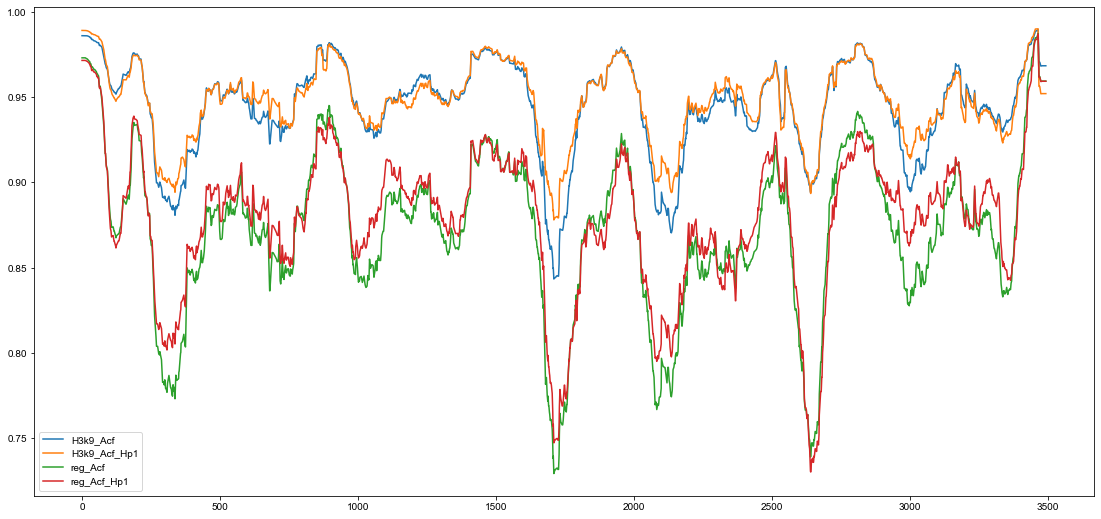

In [73]:
#just plot the ACf and ACF_HP1 samples 

plotter = ['H3k9_Acf', 'H3k9_Acf_Hp1', 'reg_Acf', 'reg_Acf_Hp1']
plt.figure(figsize=(19,9))
for sampleName in plotter:   
    hmmArr = np.load(db + sampleName + '_HMM.npy')
    plt.plot(np.nanmean(hmmArr, axis=0), label=sampleName)

plt.legend()

In [ ]:
#plots 

  0%|          | 0/16 [00:00<?, ?it/s]

total reads:  142129


 94%|█████████▍| 15/16 [04:34<00:18, 18.27s/it]


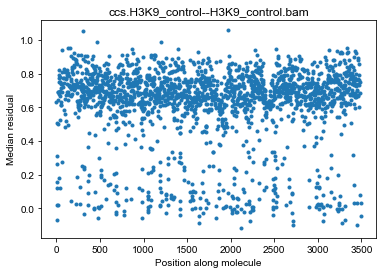

  0%|          | 0/15 [00:00<?, ?it/s]

total reads:  137415


 93%|█████████▎| 14/15 [04:21<00:18, 18.69s/it]


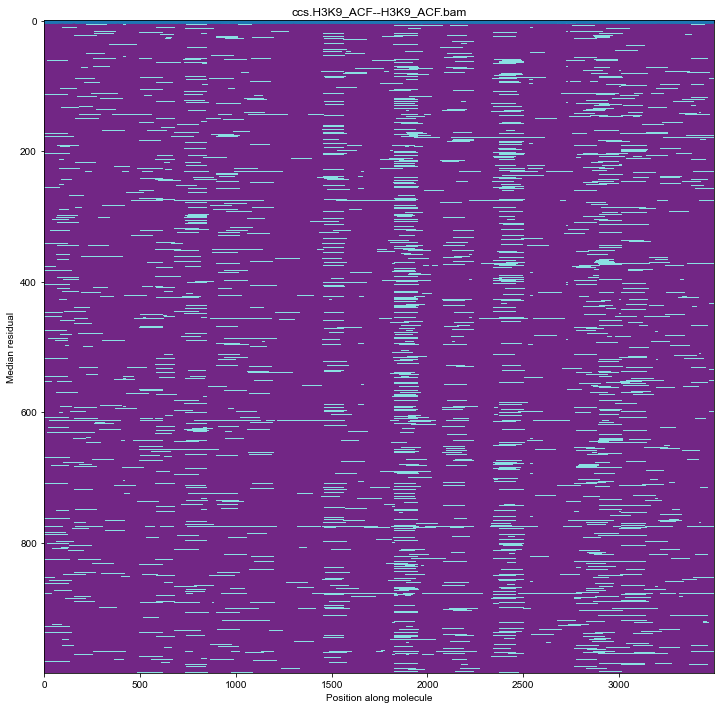

  0%|          | 0/13 [00:00<?, ?it/s]

total reads:  118154


 92%|█████████▏| 12/13 [03:44<00:18, 18.69s/it]


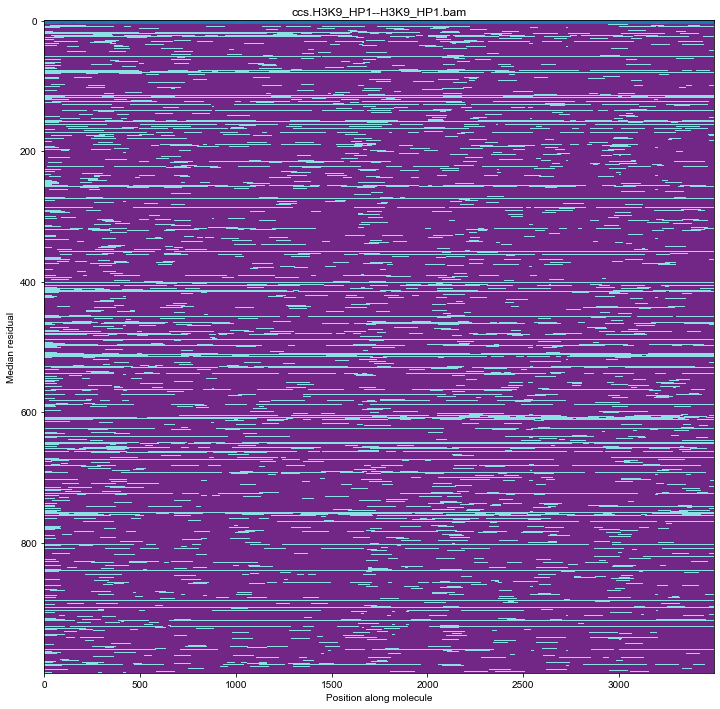

  0%|          | 0/14 [00:00<?, ?it/s]

total reads:  125899


 93%|█████████▎| 13/14 [03:59<00:18, 18.44s/it]


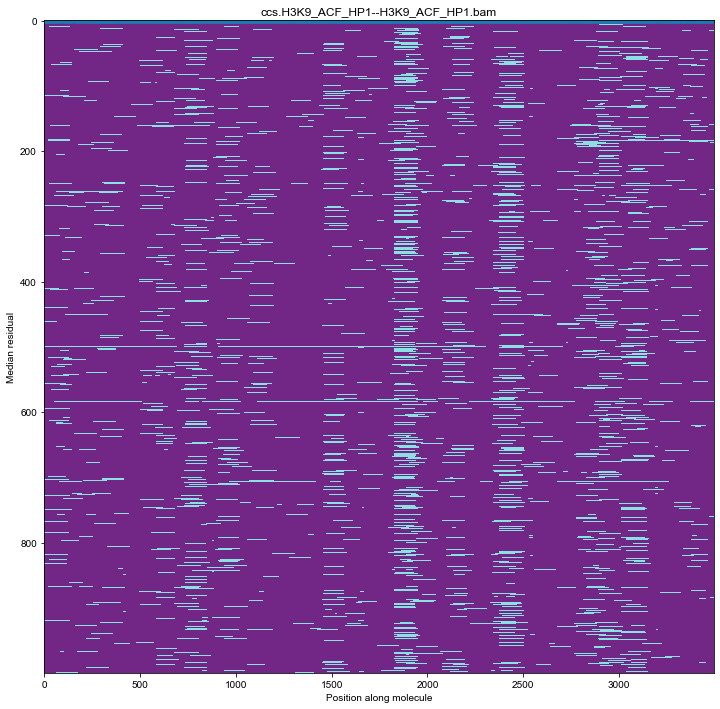

  0%|          | 0/13 [00:00<?, ?it/s]

total reads:  116753


 92%|█████████▏| 12/13 [03:39<00:18, 18.33s/it]


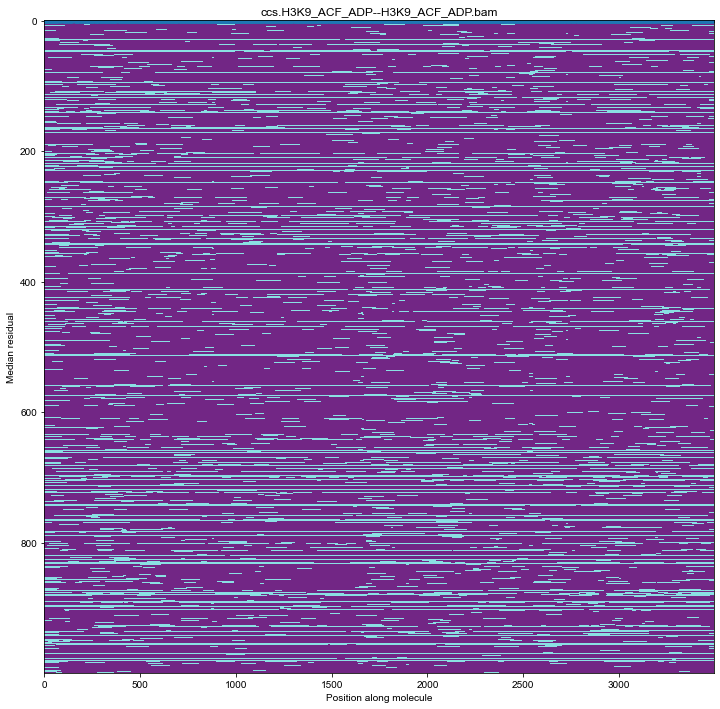

100%|██████████| 1000/1000 [01:55<00:00,  8.69it/s]


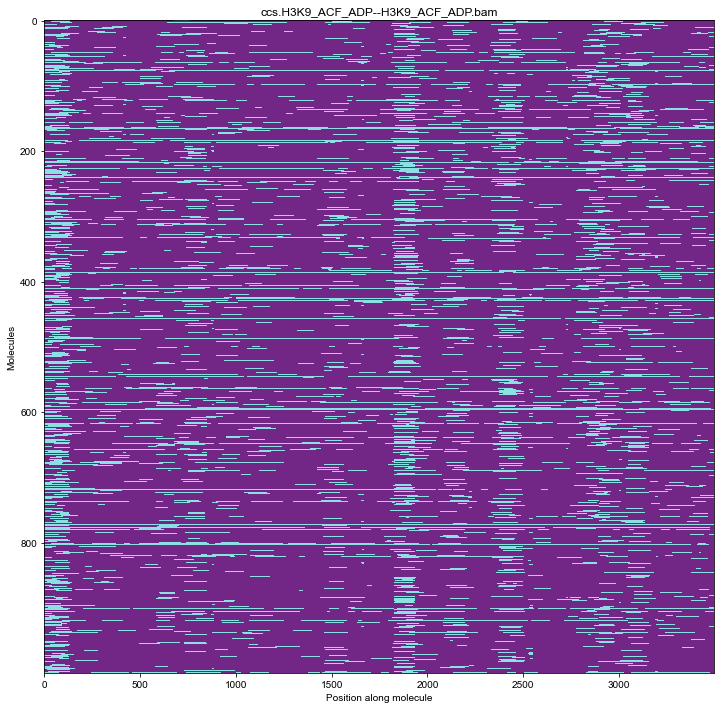

In [63]:
samps = [H3k9_control, H3k9_Acf, H3k9_Hp1, H3k9_Acf_Hp1, H3k9_Acf_Adp]

for samp in samps:
    name = db + samp
    binarized_arr = main_read_parser(name, svdmodel, NNmodel, samp)
    hmmArr = hmm_solver(binarized_arr[:1000], samp)
    

  0%|          | 0/18 [00:00<?, ?it/s]

total reads:  163689


 94%|█████████▍| 17/18 [05:23<00:19, 19.05s/it]


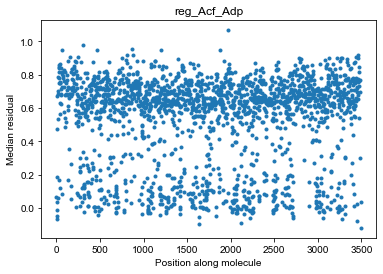

100%|██████████| 1000/1000 [01:59<00:00,  8.35it/s]


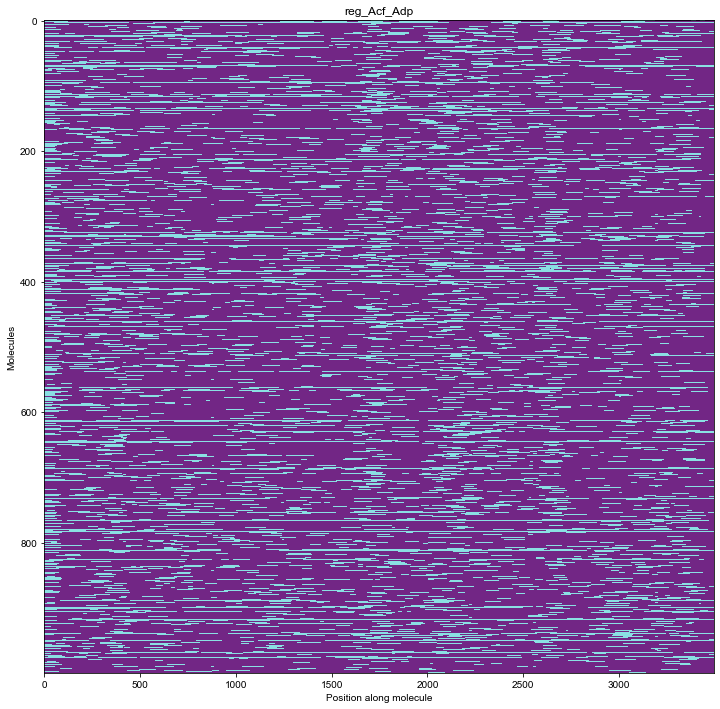

In [60]:

fullFile = db + reg_Acf
binarized_arr = main_read_parser(fullFile, svdmodel, NNmodel, sampleName)
hmmArr = hmm_solver(binarized_arr[:1000], sampleName)

  0%|          | 0/21 [00:00<?, ?it/s]

total reads:  190866


 95%|█████████▌| 20/21 [06:22<00:19, 19.10s/it]


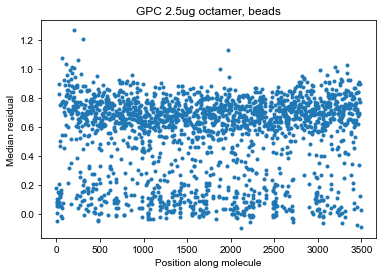

  0%|          | 0/19 [00:00<?, ?it/s]

total reads:  177247


 95%|█████████▍| 18/19 [05:09<00:17, 17.18s/it]


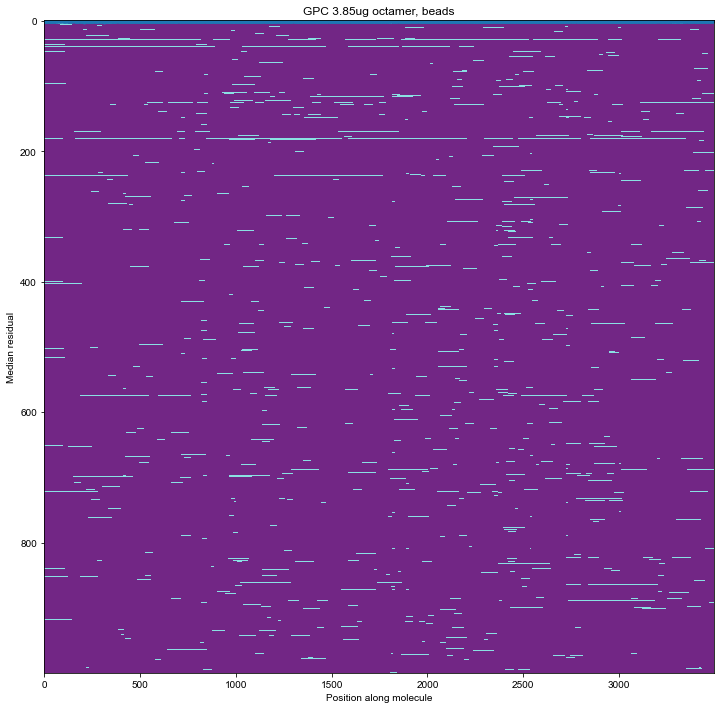

100%|██████████| 1000/1000 [02:14<00:00,  7.45it/s]


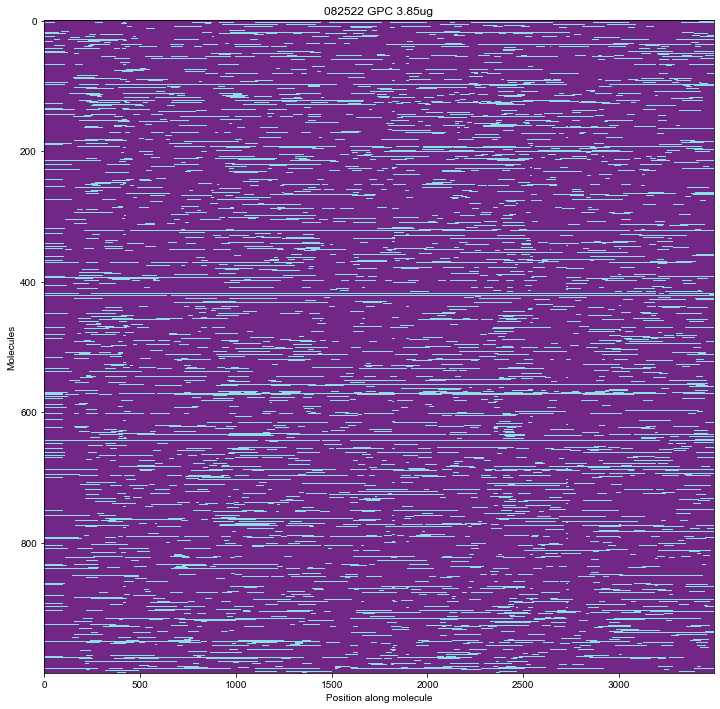

In [38]:
#do gpc stuff with the A only models

database = '/home/cmoore/data/r64182_20220825_221256/1_B03/align/'

GPCoct_2_5 = database + 'ccs.align.CM_GPC_2_5oct.bam'
GPCoct_2_5_arr = main_read_parser(GPCoct_2_5, svdmodel, NNmodel, 'GPC 2.5ug octamer, beads')
hmmArr = hmm_solver(GPCoct_2_5_arr[:1000], '082522 GPC 2.5ug')

GPCoct_3_85 = database + 'ccs.align.CM_GPC_3_85oct.bam'
GPCoct_3_85_arr = main_read_parser(GPCoct_3_85, svdmodel, NNmodel, 'GPC 3.85ug octamer, beads')
hmmArr = hmm_solver(GPCoct_3_85_arr[:1000], '082522 GPC 3.85ug')


In [ ]:
#process 080422 GPC stuff with A background models 



100%|██████████| 1000/1000 [02:14<00:00,  7.45it/s]


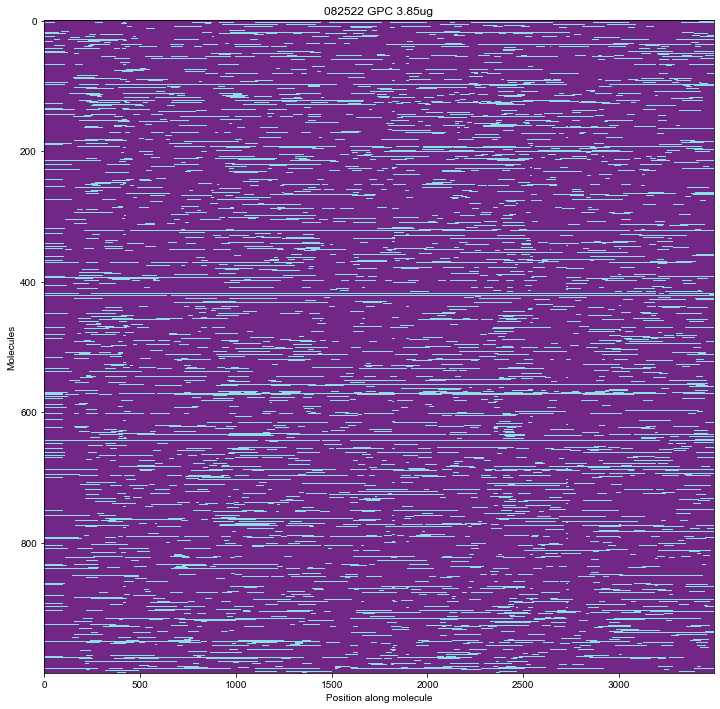

In [45]:
hmmArr385 = hmm_solver(GPCoct_3_85_arr[:1000], '082522 GPC 3.85ug')


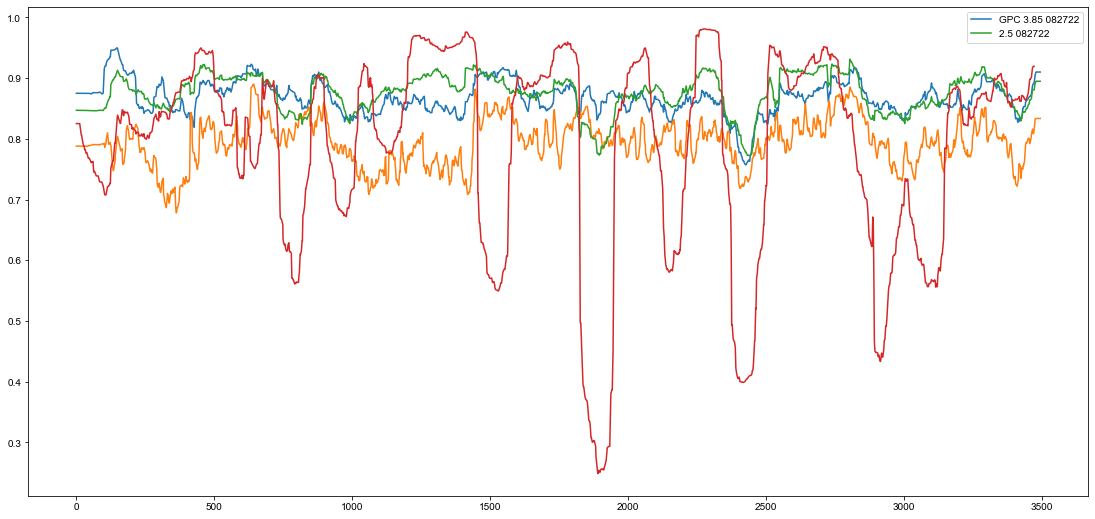

In [54]:
m6a_chrom25_arr = np.load('/home/cmoore/results/pacbio/220627_cardamomA01_CM/2.5ugoct_080422chromatin_Adenines_HMM.npy')
m6a_chrom385_arr = np.load('/home/cmoore/results/pacbio/220627_cardamomA01_CM/3.85ugoct_080422chromatin_Adenines_HMM.npy')
tentoone_arr = np.load('/home/cmoore/results/pacbio/211101_CM_Cyp3a11_HP1/211101_CM_Cyp3a11_HP1_Cyp3a11_10to_rep1_HMM.npy')
sixtoone_arr = np.load('/home/cmoore/results/pacbio/211101_CM_Cyp3a11_HP1/211101_CM_Cyp3a11_HP1_Cyp3a11_6to_rep1_HMM.npy')



plt.figure(figsize=(19,9))
plt.plot(np.nanmean(hmmArr385, axis=0), label='GPC 3.85 082722')
plt.plot(np.nanmean(m6a_chrom385_arr, axis=0), label='')
plt.plot(np.nanmean(hmmArr25061922, axis=0), label='2.5 082722')
plt.plot(np.nanmean(sixtoone_arr, axis=0))
plt.legend()

100%|██████████| 1000/1000 [02:14<00:00,  7.45it/s]


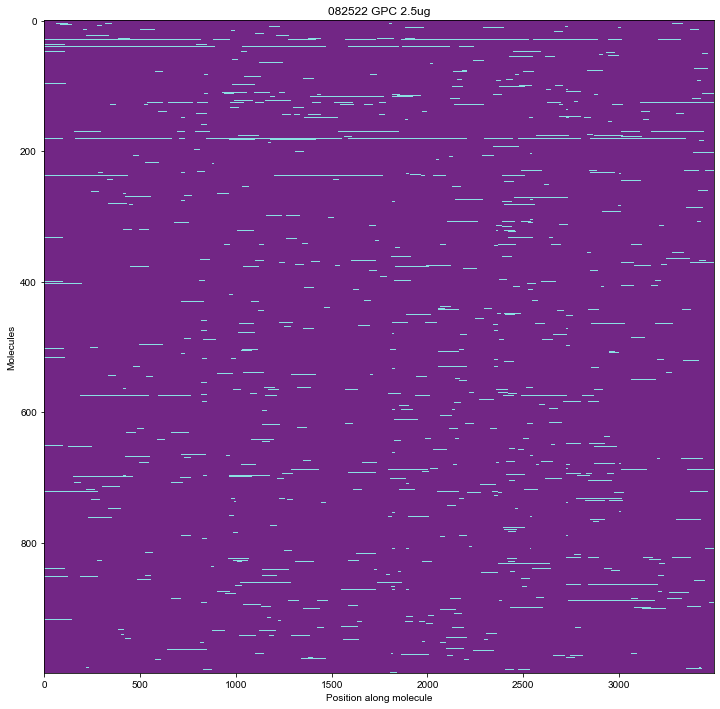

In [39]:
hmmArr = hmm_solver(GPCoct_2_5_arr[:1000], '082522 GPC 2.5ug')

  0%|          | 0/17 [00:00<?, ?it/s]

total reads:  154664


 94%|█████████▍| 16/17 [04:01<00:15, 15.06s/it]


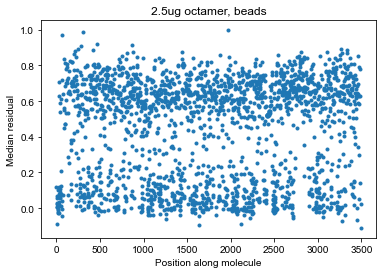

In [35]:
database = '/home/cmoore/data/r64182_20220825_221256/1_B03/align/'

oct_2_5 = database + 'ccs.align.CM_2_5oct.bam'
oct_2_5_arr = main_read_parser(oct_2_5, svdmodel, NNmodel, '2.5ug octamer, beads')



  0%|          | 0/25 [00:00<?, ?it/s]

total reads:  238916


 96%|█████████▌| 24/25 [08:20<00:20, 20.84s/it]


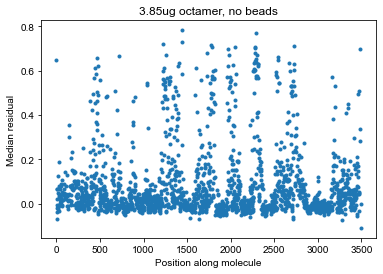

In [27]:
database = '/home/cmoore/results/pacbio/220812_CypACFCardamom/ccs_align/'

highoct = database + 'ccs.NB080422_3_85--NB080422_3_85.bam'
highoct_arr = main_read_parser(highoct, svdmodel, NNmodel, '3.85ug octamer, no beads')



  0%|          | 0/18 [00:00<?, ?it/s]

total reads:  163403


 94%|█████████▍| 17/18 [05:53<00:20, 20.82s/it]


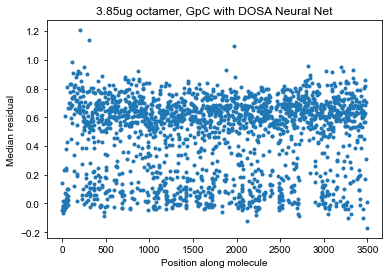

100%|██████████| 1000/1000 [02:20<00:00,  7.12it/s]


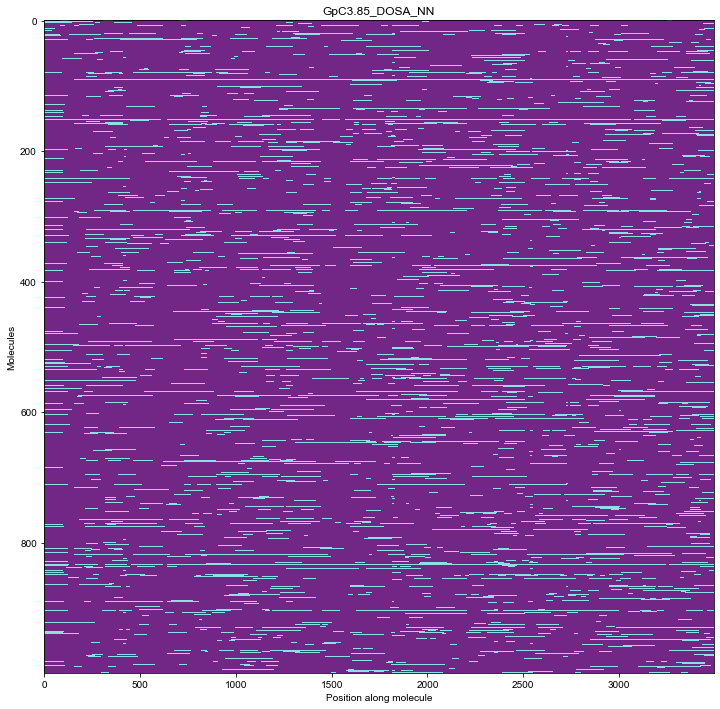

In [76]:
#process GpC adenines with m6a models 

database = '/home/cmoore/results/pacbio/220812_CypACFCardamom/ccs_align/'

highoct = database + 'ccs.GpC_080422_3_85--GpC_080422_3_85.bam'
highoct_arr = main_read_parser(highoct, svdmodel, NNmodel, '3.85ug octamer, GpC with DOSA Neural Net')

hmmArr = hmm_solver(highoct_arr[:1000], 'GpC3.85_DOSA_NN')


In [ ]:
plotResiduals(highoct_arr, abaseInd, 'GPC 3.85 DOSA NN')

  0%|          | 0/23 [00:00<?, ?it/s]

total reads:  213080


 96%|█████████▌| 22/23 [07:40<00:20, 20.95s/it]


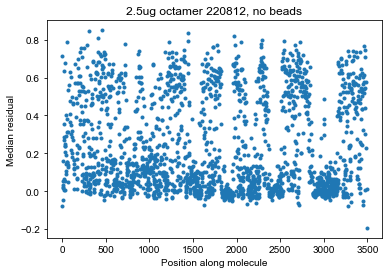

In [33]:
database = '/home/cmoore/results/pacbio/220812_CypACFCardamom/ccs_align/'

lowoct0812NoBeads = database + 'ccs.NB080422_2_5--NB080422_2_5.bam'
lowoct0812NoBeads_arr = main_read_parser(lowoct0812NoBeads, svdmodel, NNmodel, '2.5ug octamer 220812, no beads')



  0%|          | 0/21 [00:00<?, ?it/s]

total reads:  198303


 95%|█████████▌| 20/21 [07:07<00:21, 21.37s/it]


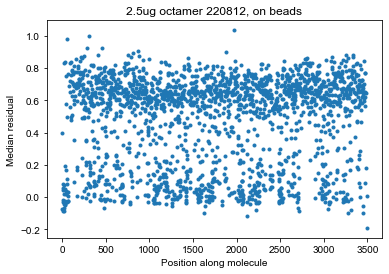

  0%|          | 0/22 [00:00<?, ?it/s]

total reads:  204158


 95%|█████████▌| 21/22 [07:14<00:20, 20.70s/it]


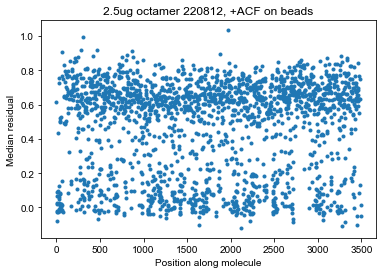

In [34]:
database = '/home/cmoore/results/pacbio/220812_CypACFCardamom/ccs_align/'

lowoct0812Beads = database + 'ccs.080422_2_5--080422_2_5.bam'
lowoct0812Beads_arr = main_read_parser(lowoct0812Beads, svdmodel, NNmodel, '2.5ug octamer 220812, on beads')

lowoct0812ACFBeads = database + 'ccs.080422_2_5ACF--080422_2_5ACF.bam'
lowoct0812ACFBeads_arr = main_read_parser(lowoct0812ACFBeads, svdmodel, NNmodel, '2.5ug octamer 220812, +ACF on beads')


  0%|          | 0/21 [00:00<?, ?it/s]

total reads:  193891


 95%|█████████▌| 20/21 [06:57<00:20, 20.88s/it]


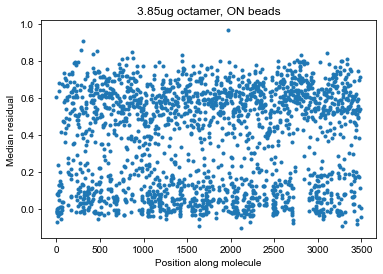

In [23]:
database = '/home/cmoore/results/pacbio/220812_CypACFCardamom/ccs_align/'

highoctBeads = database + 'ccs.080422_3_85--080422_3_85.bam'
highoctBeads_arr = main_read_parser(highoctBeads, svdmodel, NNmodel, '3.85ug octamer, ON beads')



  0%|          | 0/19 [00:00<?, ?it/s]

total reads:  179381


 95%|█████████▍| 18/19 [04:54<00:16, 16.35s/it]


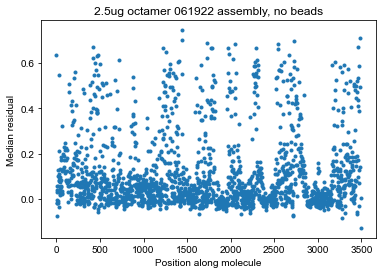

In [24]:
database = '/home/cmoore/results/pacbio/220812_CypACFCardamom/ccs_align/'

oldregnobeads = database + 'ccs.NB061922_2_5--NB061922_2_5.bam'
oldregnobeads_arr = main_read_parser(oldregnobeads, svdmodel, NNmodel, '2.5ug octamer 061922 assembly, no beads')



  0%|          | 0/26 [00:00<?, ?it/s]

total reads:  242607


 96%|█████████▌| 25/26 [08:35<00:20, 20.63s/it]


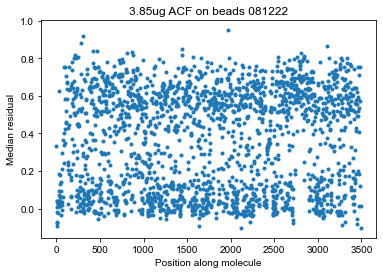

In [29]:
database = '/home/cmoore/results/pacbio/220812_CypACFCardamom/ccs_align/'

acf385oct = database + 'ccs.080422_3_85ACF--080422_3_85ACF.bam'
oldregnobeads_arr = main_read_parser(acf385oct, svdmodel, NNmodel, '3.85ug ACF on beads 081222')



  0%|          | 0/19 [00:00<?, ?it/s]

total reads:  172599


 95%|█████████▍| 18/19 [03:56<00:13, 13.13s/it]


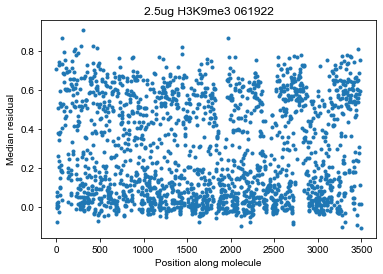

In [36]:
#database = '/home/cmoore/results/pacbio/220812_CypACFCardamom/ccs_align/'

h3k9me3oct = database + 'ccs.NB061922_H3K9me3--NB061922_H3K9me3.bam'
h3k9me3oct_arr = main_read_parser(h3k9me3oct, svdmodel, NNmodel, '2.5ug H3K9me3 061922')



100%|██████████| 1000/1000 [02:17<00:00,  7.27it/s]


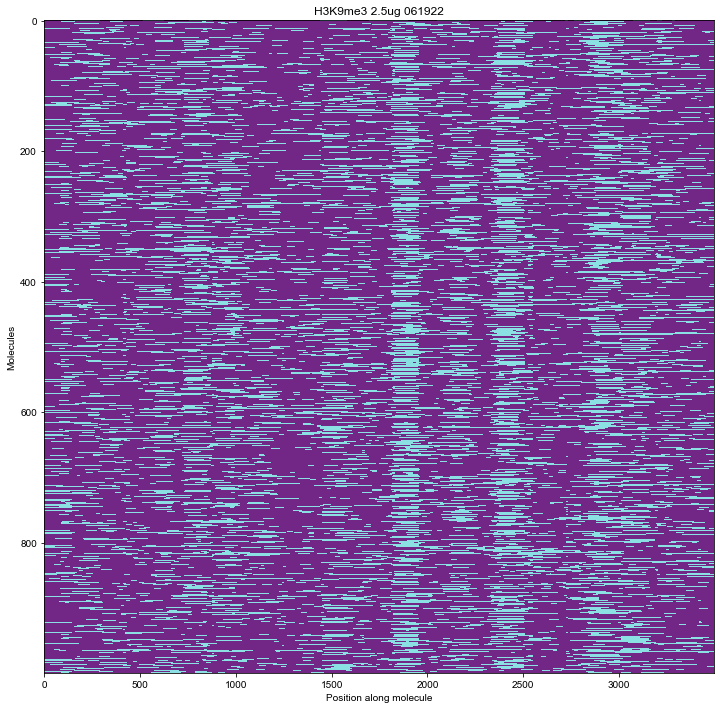

In [37]:
hmmArr = hmm_solver(h3k9me3oct_arr[:1000], 'H3K9me3 2.5ug 061922')

100%|██████████| 5000/5000 [11:11<00:00,  7.44it/s]


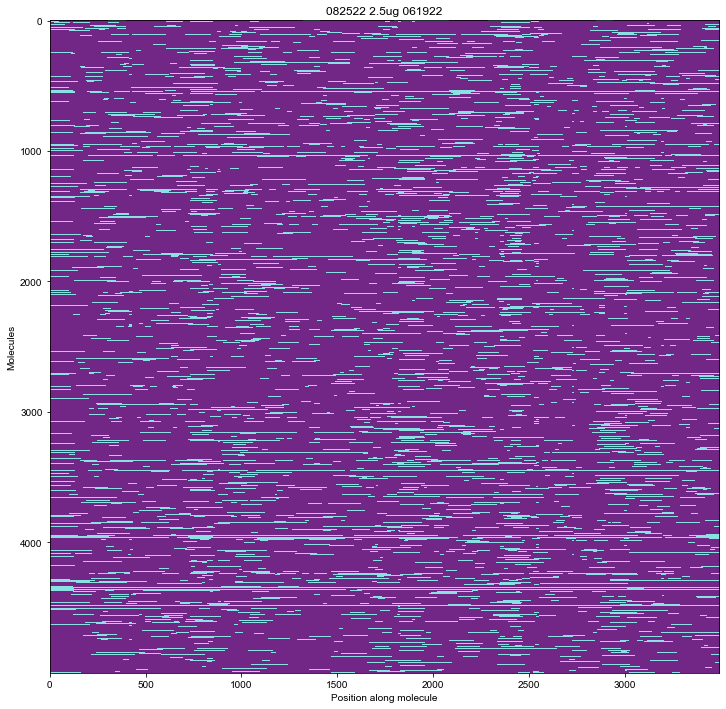

In [50]:
hmmArr25061922 = hmm_solver(oct_2_5_arr[:5000], '082522 2.5ug 061922')

100%|██████████| 2000/2000 [04:54<00:00,  6.78it/s]


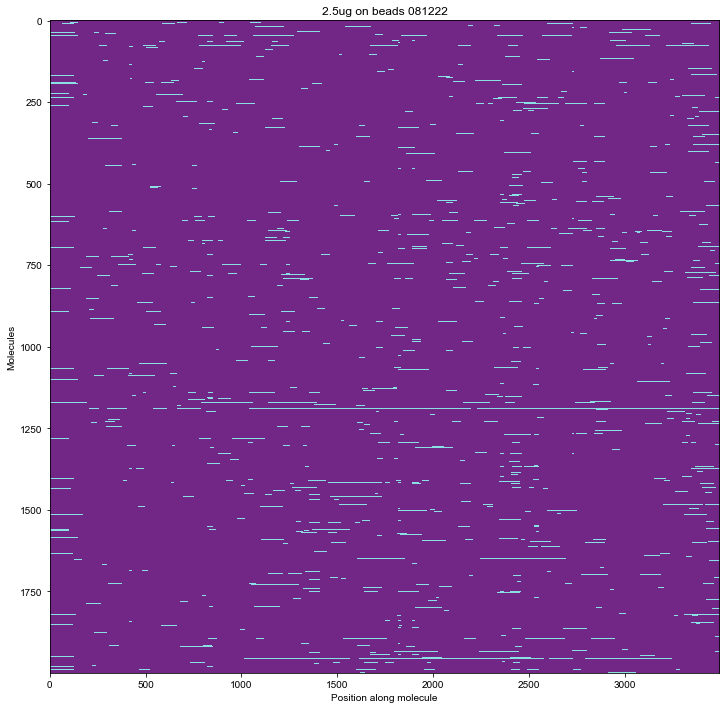

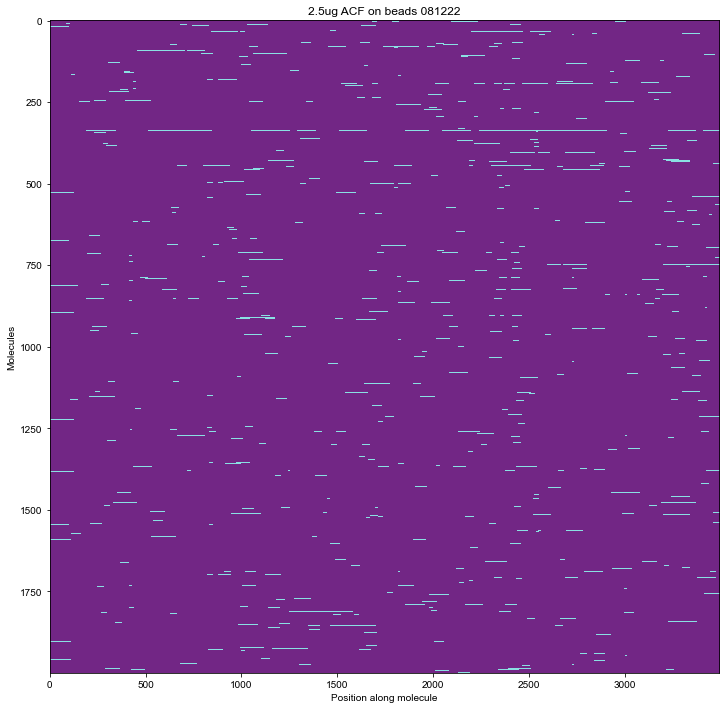

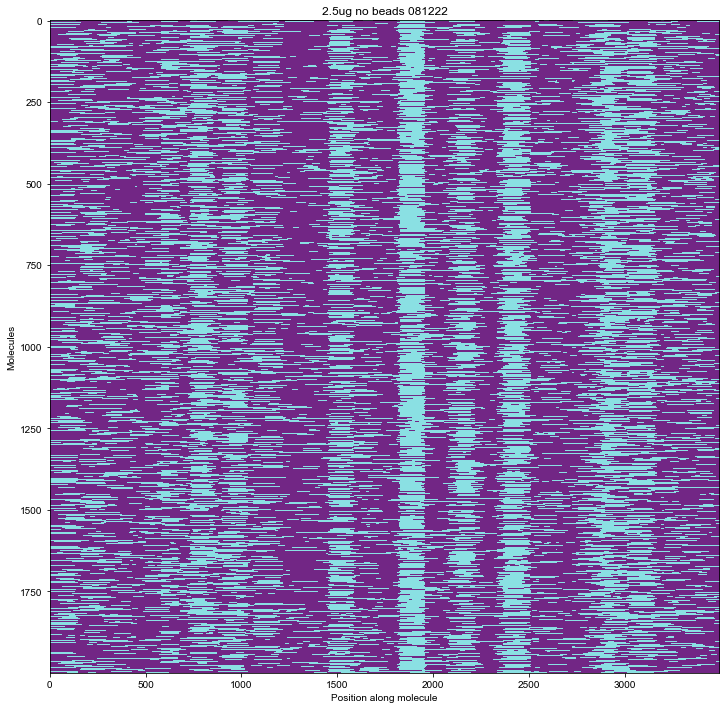

In [35]:
hmmArr = hmm_solver(lowoct0812Beads_arr[:2000], '2.5ug on beads 081222')
hmmArr = hmm_solver(lowoct0812ACFBeads_arr[:2000], '2.5ug ACF on beads 081222')
hmmArr = hmm_solver(lowoct0812NoBeads_arr[:2000], '2.5ug no beads 081222')

100%|██████████| 2000/2000 [04:45<00:00,  7.00it/s]


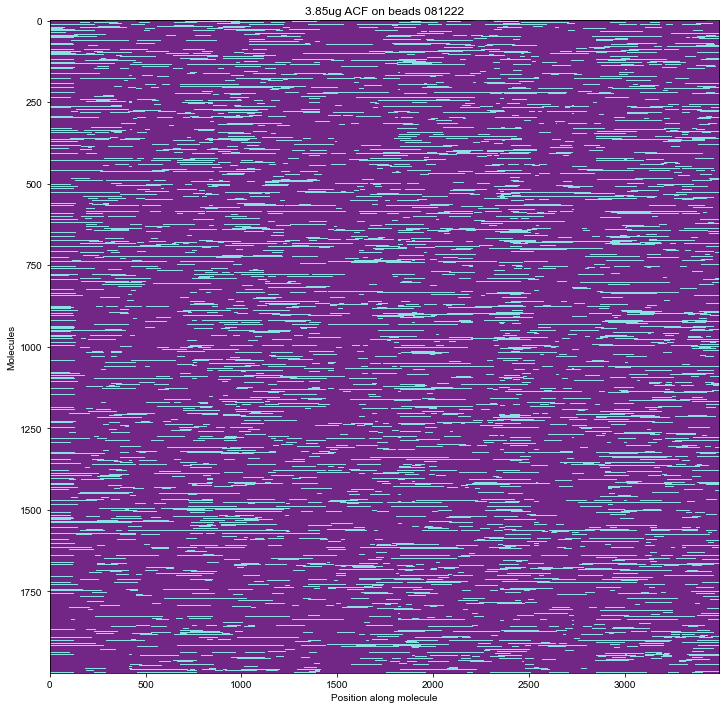

In [31]:
hmmArr = hmm_solver(oldregnobeads_arr[:2000], '3.85ug ACF on beads 081222')

100%|██████████| 500/500 [01:11<00:00,  7.01it/s]


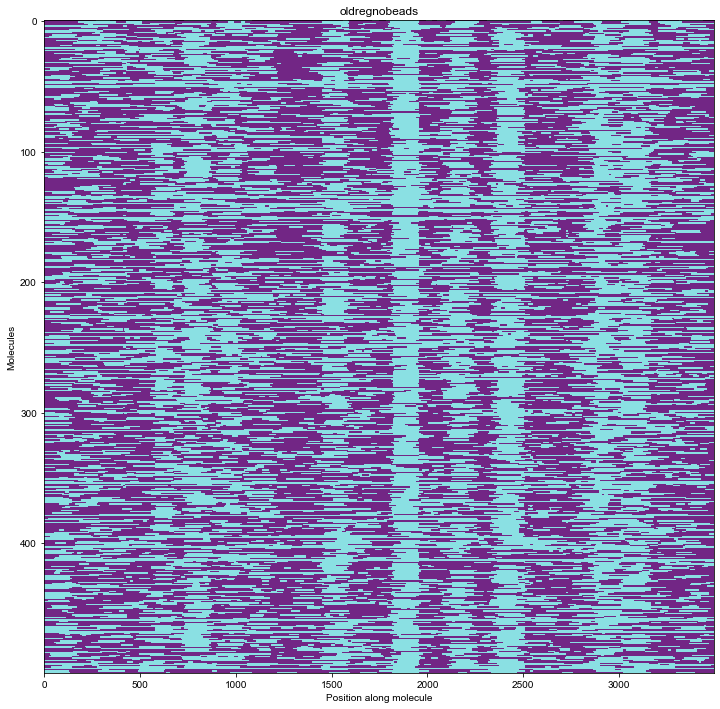

In [25]:
hmmArr = hmm_solver(oldregnobeads_arr[:500], 'oldregnobeads')

100%|██████████| 2000/2000 [06:02<00:00,  5.51it/s]


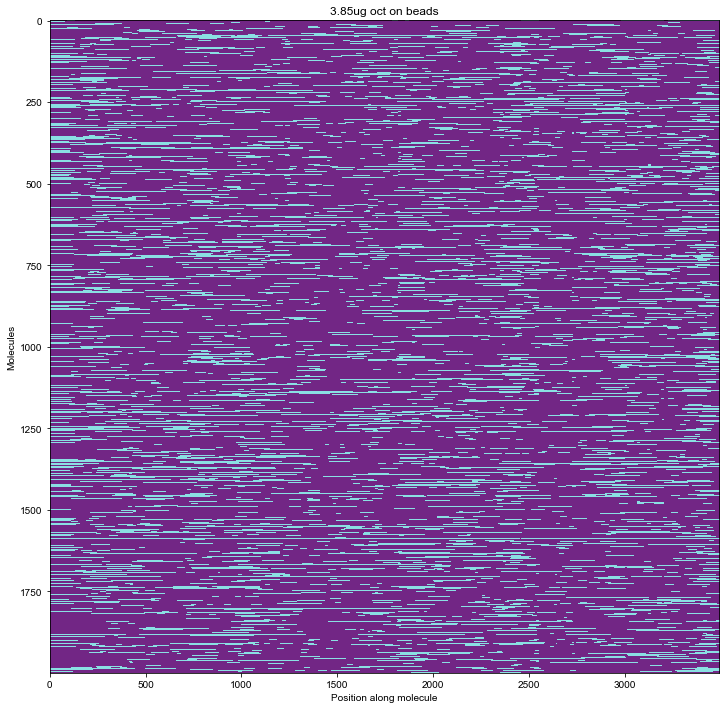

In [32]:
hmmArr = hmm_solver(highoctBeads_arr[:2000], '3.85ug oct on beads')

100%|██████████| 500/500 [01:09<00:00,  7.24it/s]


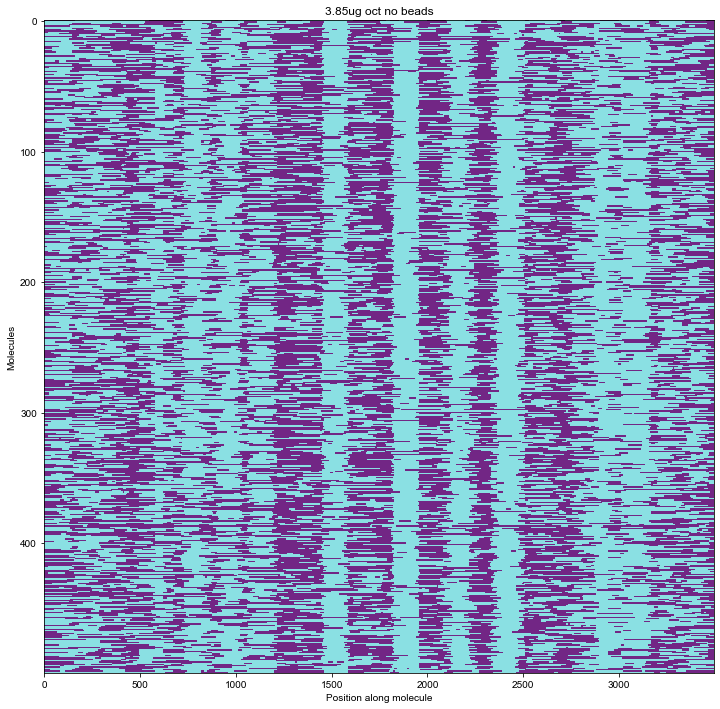

In [28]:
hmmArr = hmm_solver(highoct_arr[:500], '3.85ug oct no beads')

In [ ]:
database = '/home/cmoore/results/pacbio/220627_ACF_Hp1a_CM/ccs4.99_scottdemux_align/220627_Cyp_ACF_HP1a_CM.ccs_6.4.99.demux.'

H3K9chrom0613bam = database + '0613_H3K9chrom--0613_H3K9chrom.bam'



  0%|          | 0/4 [00:00<?, ?it/s]

total reads:  26905


 75%|███████▌  | 3/4 [00:52<00:17, 17.63s/it]


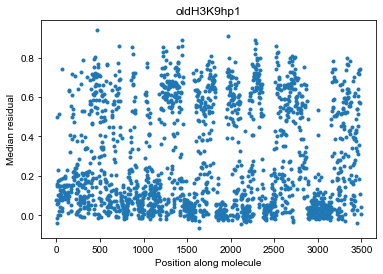

100%|██████████| 15494/15494 [38:05<00:00,  6.78it/s]


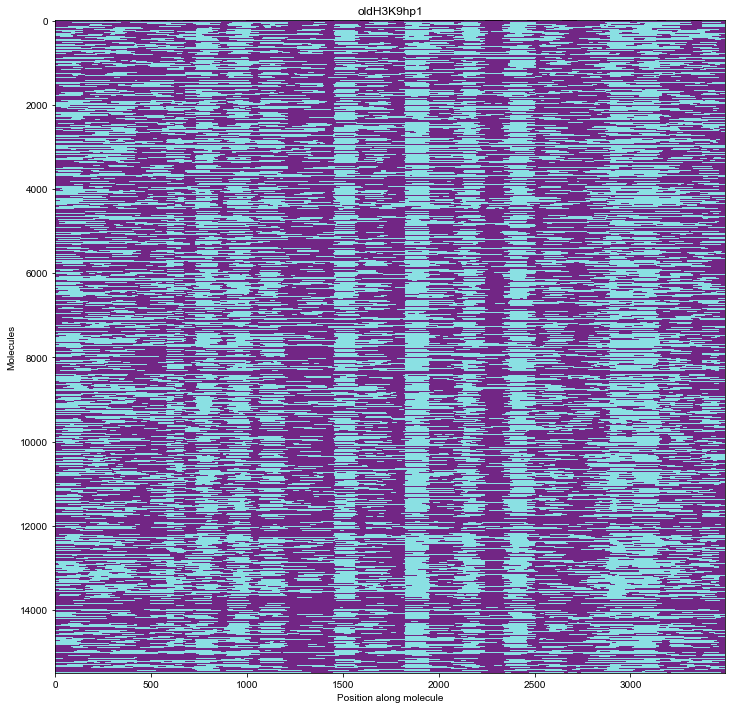

In [55]:
database = '/home/cmoore/results/pacbio/220627_ACF_Hp1a_CM/ccs4.99_align/'

oldH3K9hp1 = database + 'ccs.0613_H3K9chrom_HP1--0613_H3K9chrom_HP1.bam'
oldH3K9hp1_arr = main_read_parser(oldH3K9hp1, svdmodel, NNmodel, 'oldH3K9hp1')


  0%|          | 0/8 [00:00<?, ?it/s]

total reads:  65853


 88%|████████▊ | 7/8 [02:13<00:19, 19.06s/it]
<ipython-input-8-b03b17354214>:27: RuntimeWarning: Mean of empty slice
  notaipd = notaipd - np.nanmean(notaipd, axis=0) #each ipd has the molecule's mean ipd subtracted from it
/home/cmoore/miniconda3/envs/NN2/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


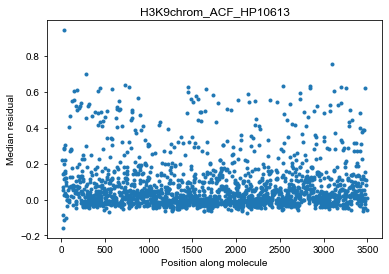

100%|██████████| 44491/44491 [1:52:31<00:00,  6.59it/s]


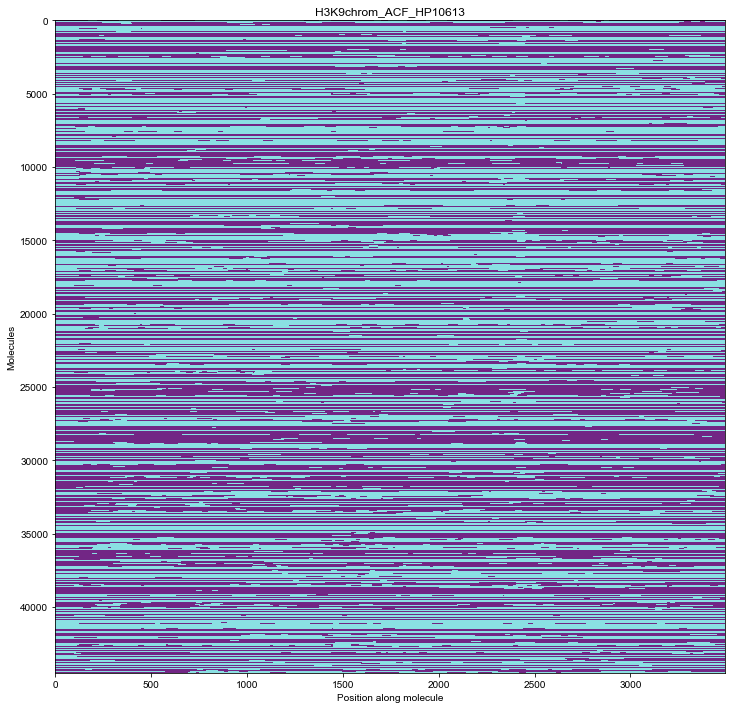

In [28]:
#now you're ready to process the samples 

#database = '/sadra/ramanilab/camillem/results/pacbio/220627_ACF_Hp1a_CM/ccs4.99_scottdemux_align/220627_Cyp_ACF_HP1a_CM.ccs_6.4.99.demux.'
database = '/home/cmoore/results/pacbio/220627_ACF_Hp1a_CM/ccs4.99_scottdemux_align/220627_Cyp_ACF_HP1a_CM.ccs_6.4.99.demux.'

chromACF0613bam = database + '0613_chromACF--0613_chromACF.bam'
H3K9chrom0613bam = database + '0613_H3K9chrom--0613_H3K9chrom.bam'
H3K9chrom_ACF0613bam = database + '0613_H3K9chrom_ACF--0613_H3K9chrom_ACF.bam'
H3K9chrom_ACF_HP10613bam = database + '0613_H3K9chrom_ACF_HP1--0613_H3K9chrom_ACF_HP1.bam'
H3K9chrom_HP10613bam = database + '0613_H3K9chrom_HP1--0613_H3K9chrom_HP1.bam'


H3K9chrom_ACF_HP10613_arr = main_read_parser(H3K9chrom_ACF_HP10613bam, svdmodel, NNmodel, 'H3K9chrom_ACF_HP10613')


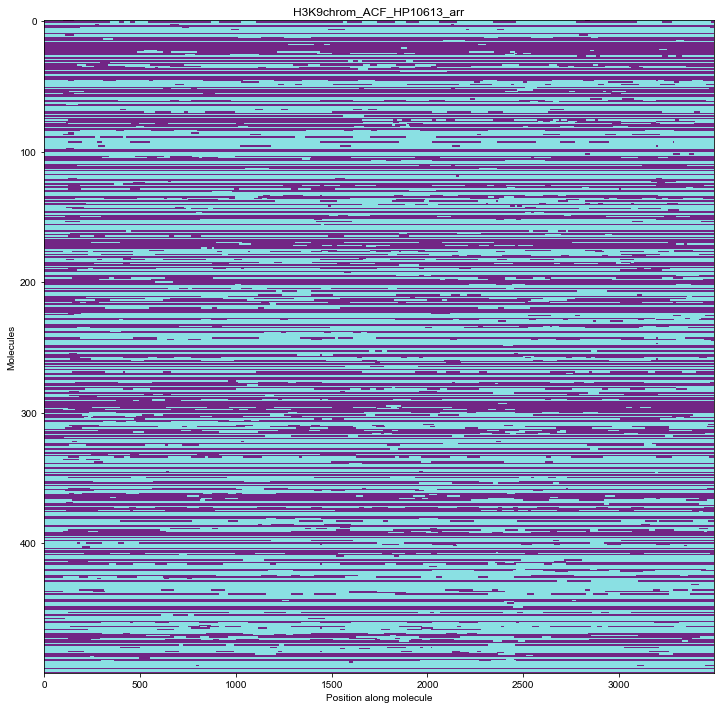

In [52]:
heatmapper(H3K9chrom_ACF_HP10613_arr[:500], 'H3K9chrom_ACF_HP10613_arr')

In [15]:
samplenames = ['chromACF0613', 'H3K9chrom0613', 'H3K9chrom_ACF0613', 'H3K9chrom_ACF_HP10613', 'H3K9chrom_HP10613', 'chrom220621', \

               'chrom_ACF0621',  'chrom_ACF_HP10621', 'chrom_HP10621']

print(samplenames)

#this will be formatted as [residuals, ipds, aipds]
samples = {}
for samp in samplenames:
    samples[samp] = []

print(samples)


['chromACF0613', 'H3K9chrom0613', 'H3K9chrom_ACF0613', 'H3K9chrom_ACF_HP10613', 'H3K9chrom_HP10613', 'chrom220621', 'chrom_ACF0621', 'chrom_ACF_HP10621', 'chrom_HP10621']
{'chromACF0613': [], 'H3K9chrom0613': [], 'H3K9chrom_ACF0613': [], 'H3K9chrom_ACF_HP10613': [], 'H3K9chrom_HP10613': [], 'chrom220621': [], 'chrom_ACF0621': [], 'chrom_ACF_HP10621': [], 'chrom_HP10621': []}


  0%|          | 0/13 [00:00<?, ?it/s]

total reads:  111971


 92%|█████████▏| 12/13 [05:46<00:28, 28.89s/it]


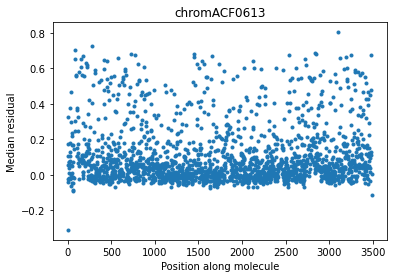

  0%|          | 0/23 [00:00<?, ?it/s]

total reads:  218680


 96%|█████████▌| 22/23 [11:19<00:30, 30.89s/it]


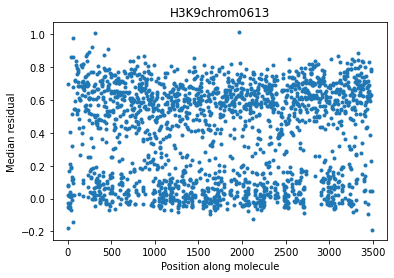

  0%|          | 0/6 [00:00<?, ?it/s]

total reads:  41066


 83%|████████▎ | 5/6 [01:59<00:23, 23.93s/it]


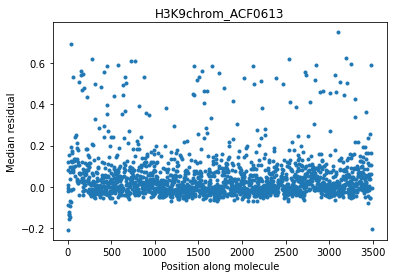

  0%|          | 0/8 [00:00<?, ?it/s]

total reads:  65853


 88%|████████▊ | 7/8 [03:12<00:27, 27.50s/it]
<ipython-input-12-b03b17354214>:27: RuntimeWarning: Mean of empty slice
  notaipd = notaipd - np.nanmean(notaipd, axis=0) #each ipd has the molecule's mean ipd subtracted from it
/sadra/ramanilab/camillem/miniconda3/envs/NN2/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


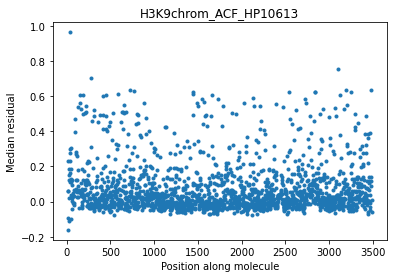

  0%|          | 0/22 [00:00<?, ?it/s]

total reads:  206544


 95%|█████████▌| 21/22 [09:13<00:26, 26.34s/it]


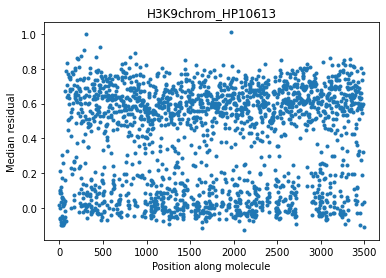

  0%|          | 0/27 [00:00<?, ?it/s]

total reads:  251127


 96%|█████████▋| 26/27 [11:12<00:25, 25.86s/it]


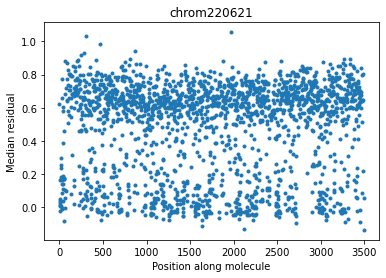

  0%|          | 0/16 [00:00<?, ?it/s]

total reads:  142635


 94%|█████████▍| 15/16 [05:10<00:20, 20.72s/it]


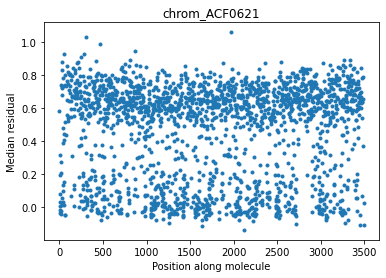

  0%|          | 0/9 [00:00<?, ?it/s]

total reads:  74302


 89%|████████▉ | 8/9 [02:43<00:20, 20.38s/it]


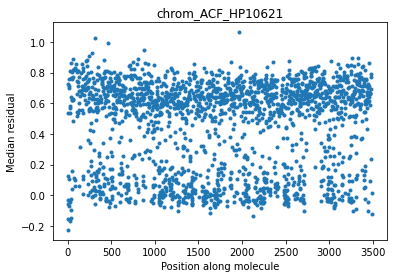

  0%|          | 0/24 [00:00<?, ?it/s]

total reads:  229115


 96%|█████████▌| 23/24 [09:25<00:24, 24.61s/it]


MemoryError: Unable to allocate 2.88 GiB for an array with shape (773228058,) and data type int32

In [16]:
database = '/sadra/ramanilab/camillem/results/pacbio/220627_ACF_Hp1a_CM/ccs4.99_scottdemux_align/220627_Cyp_ACF_HP1a_CM.ccs_6.4.99.demux.'

chromACF0613bam = database + '0613_chromACF--0613_chromACF.bam'
H3K9chrom0613bam = database + '0613_H3K9chrom--0613_H3K9chrom.bam'
H3K9chrom_ACF0613bam = database + '0613_H3K9chrom_ACF--0613_H3K9chrom_ACF.bam'
H3K9chrom_ACF_HP10613bam = database + '0613_H3K9chrom_ACF_HP1--0613_H3K9chrom_ACF_HP1.bam'
H3K9chrom_HP10613bam = database + '0613_H3K9chrom_HP1--0613_H3K9chrom_HP1.bam'

chrom220621bam = database + '0621_chrom--0621_chrom.bam'
chrom_ACF0621bam = database + '0621_chrom_ACF--0621_chrom_ACF.bam'
chrom_ACF_HP10621bam = database + '0621_chrom_ACF_HP1--0621_chrom_ACF_HP1.bam'
chrom_HP10621bam = database + '0621_chrom_HP1--0621_chrom_HP1.bam'

filelist = [chromACF0613bam, H3K9chrom0613bam, H3K9chrom_ACF0613bam, H3K9chrom_ACF_HP10613bam, \
            H3K9chrom_HP10613bam, chrom220621bam, chrom_ACF0621bam, chrom_ACF_HP10621bam, chrom_HP10621bam]

for sampIndex, sampfile in enumerate(filelist):
    sampname = samplenames[sampIndex]
    Residuals, Ipds, Aipd = read_parser(sampfile, svdmodel, NNmodel, sampname)
    samples[samplenames[sampIndex]].append(Residuals)
    samples[samplenames[sampIndex]].append(Ipds)
    samples[samplenames[sampIndex]].append(Aipd)
    
    


In [84]:
#save smmfd to look at cutoffs later

smmfd.to_csv(os.path.join('/sadra/ramanilab/camillem/results/pacbio/211101_CM_Cyp3a11_HP1/NNmodels/smmfd_weights_ccs4.99.csv'))



100%|██████████| 200/200 [00:20<00:00,  9.60it/s]
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


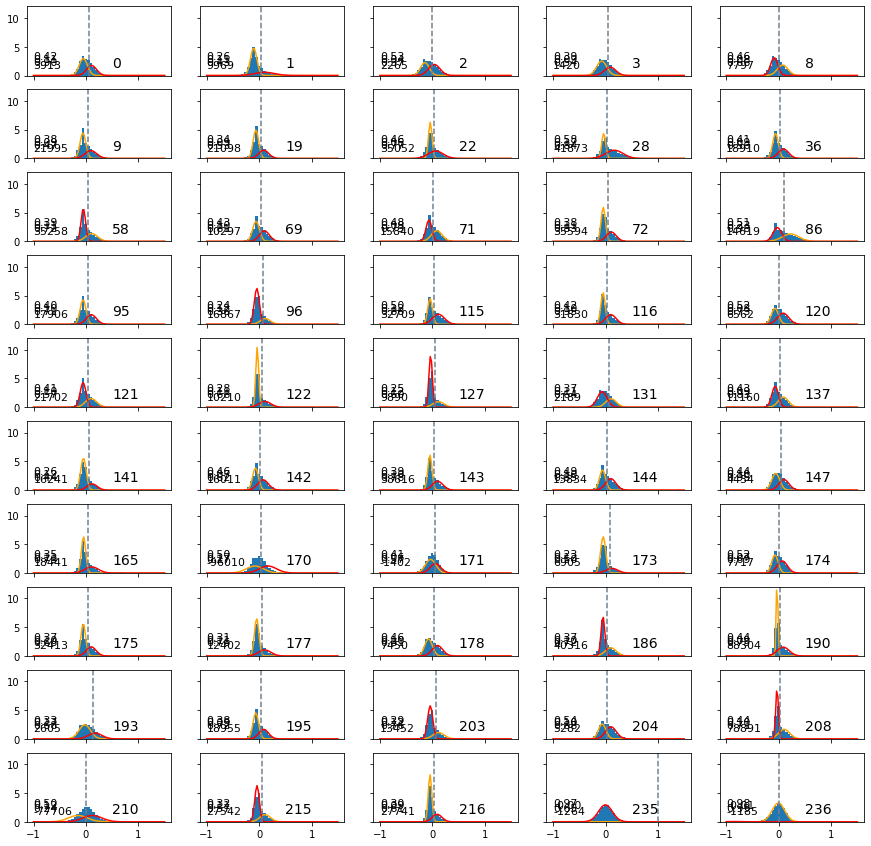

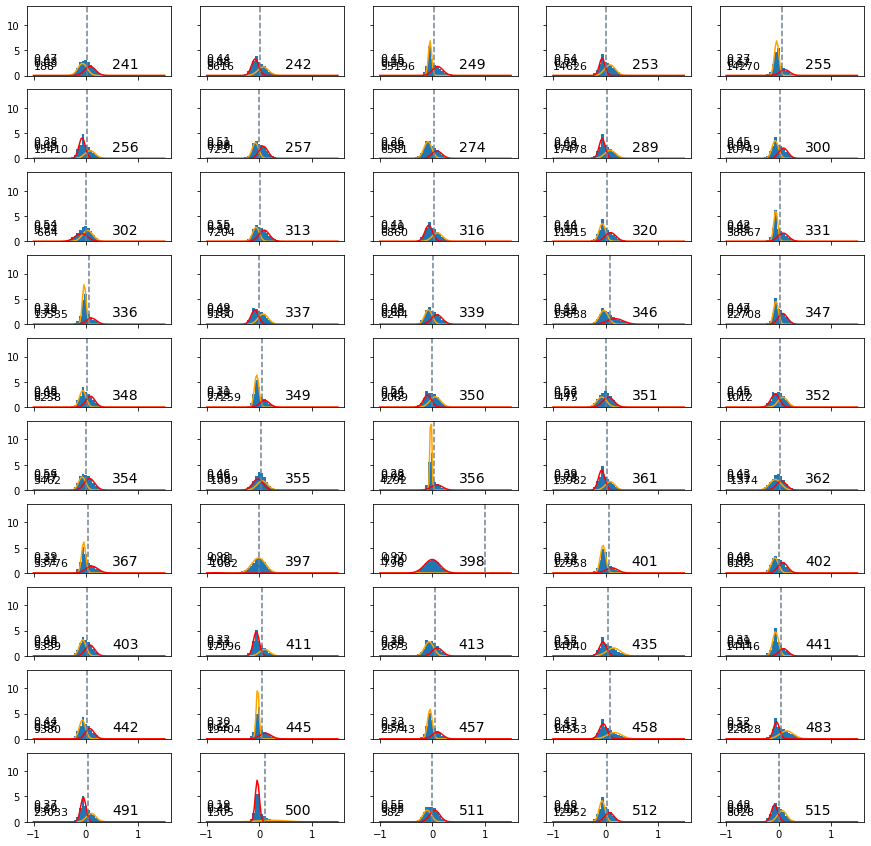

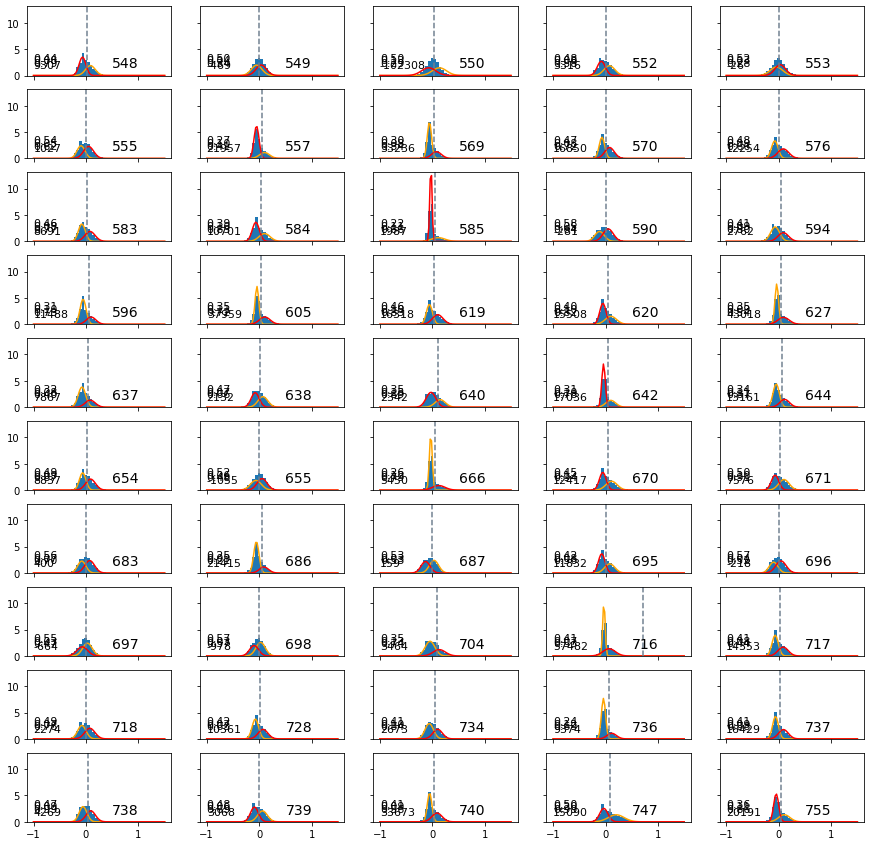

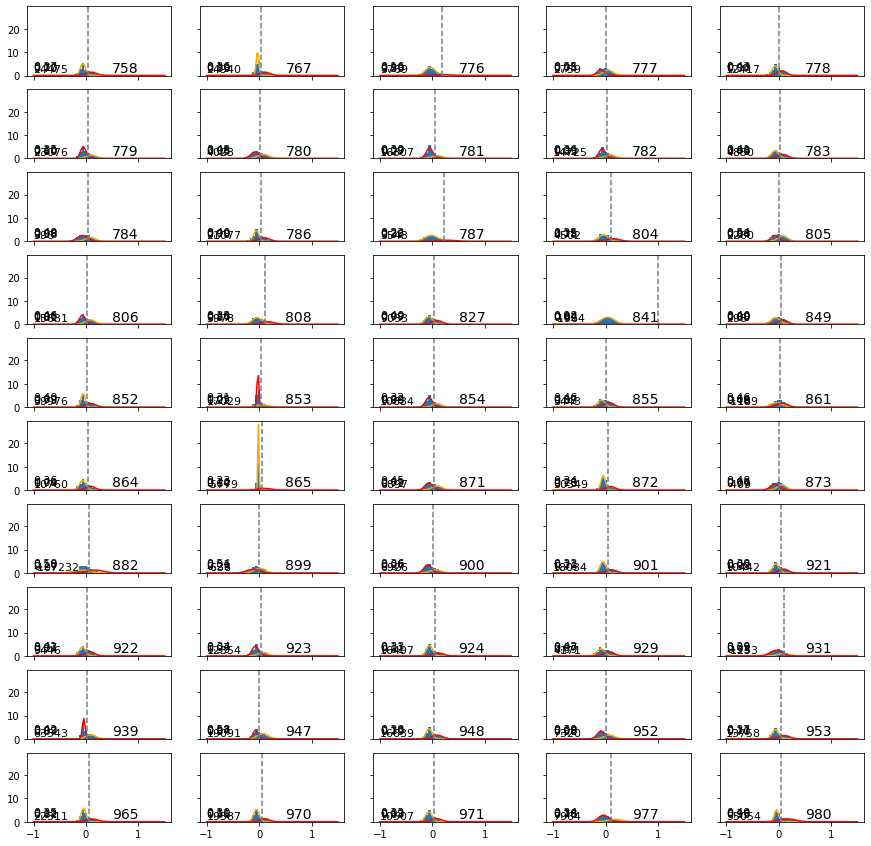

In [85]:
# Plot all the bad bases, look at distribution and confirm that there's no potential for usefully
# discriminating methylated from unmethylated adenines
from scipy import stats 

figw = 5
figh = 10
figind = 50

x=np.linspace(-1,1.5,100)

for b in tqdm(badbase[0:200], position=0):
    
    dat = concdat[:,b]
    usedat = dat[~np.isnan(dat)].reshape(-1,1)
    
    if figind >= (figw * figh):
        fig, ax = plt.subplots(figh, figw, figsize=(15, 15), sharex=True, sharey=True)
        figind = 0
        
    ax[int(figind / figw), figind % figw].hist(usedat, np.linspace(-1, 1.5, 50), density=True)
    for comp, col in [(0,'orange'), (1,'red')]:
        ax[int(figind / figw), figind % figw].plot(x, smmFitd[b].weights[comp]*stats.norm.pdf(x, loc=smmFitd[b].means[comp][0], scale=np.sqrt(smmFitd[b].covariances[comp][0][0])), color=col)
    #ax[int(figind / figw), figind % figw].axvline(x=cutoff, ls='--', color='slategray')
    ax[int(figind / figw), figind % figw].axvline(x=smmfd['cutoff'][b], ls='--', color='slategray')
    ax[int(figind / figw), figind % figw].text(.5,1.5, b, fontsize=14)
    ax[int(figind / figw), figind % figw].text(-1,2.8, '{:.2f}'.format(smmfd['weighthigh'][b]), fontsize=11)
    ax[int(figind / figw), figind % figw].text(-1,2.3, '{:.2f}'.format(smmfd['meanhigh'][b]), fontsize=11)
    ax[int(figind / figw), figind % figw].text(-1,1.8, '{:.2f}'.format(smmfd['lowprob'][b]), fontsize=11)
    ax[int(figind / figw), figind % figw].text(-1,1.3, '{:.0f}'.format(smmfd['aicd'][b]), fontsize=11)
    figind += 1
    #plt.xlabel('residual')

100%|██████████| 1000/1000 [01:56<00:00,  8.56it/s]


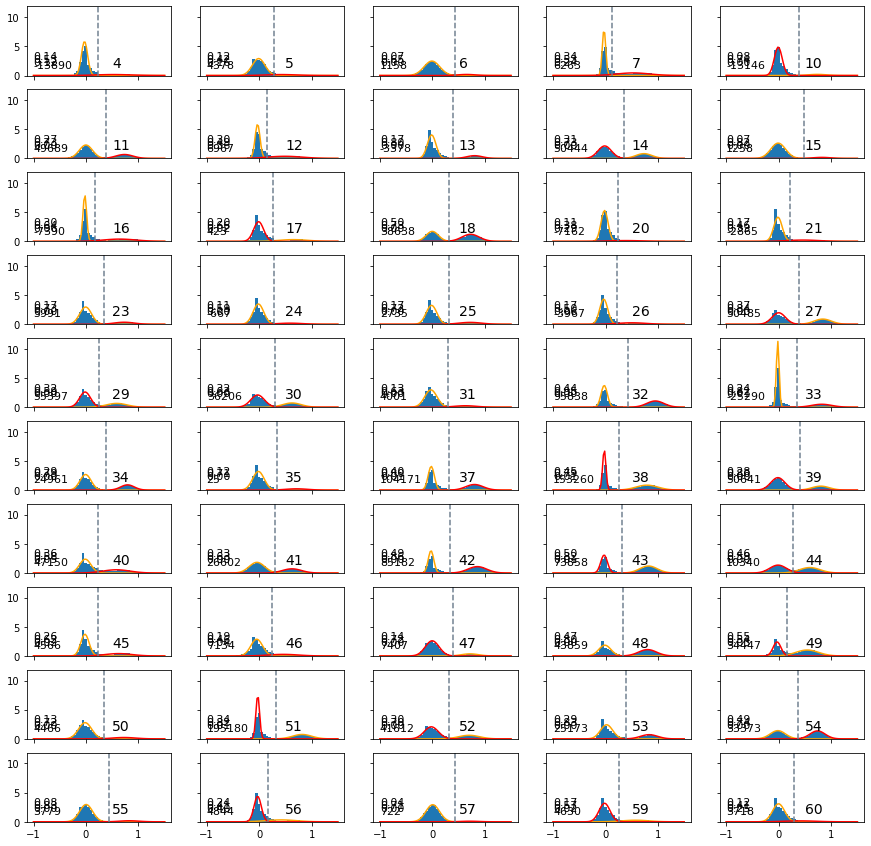

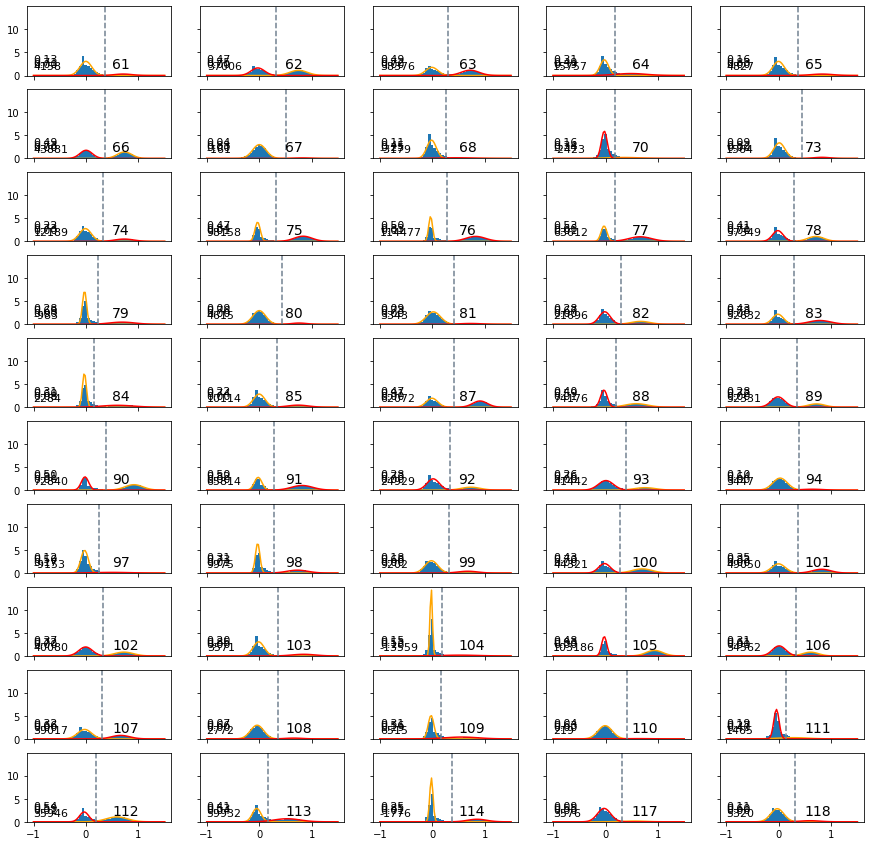

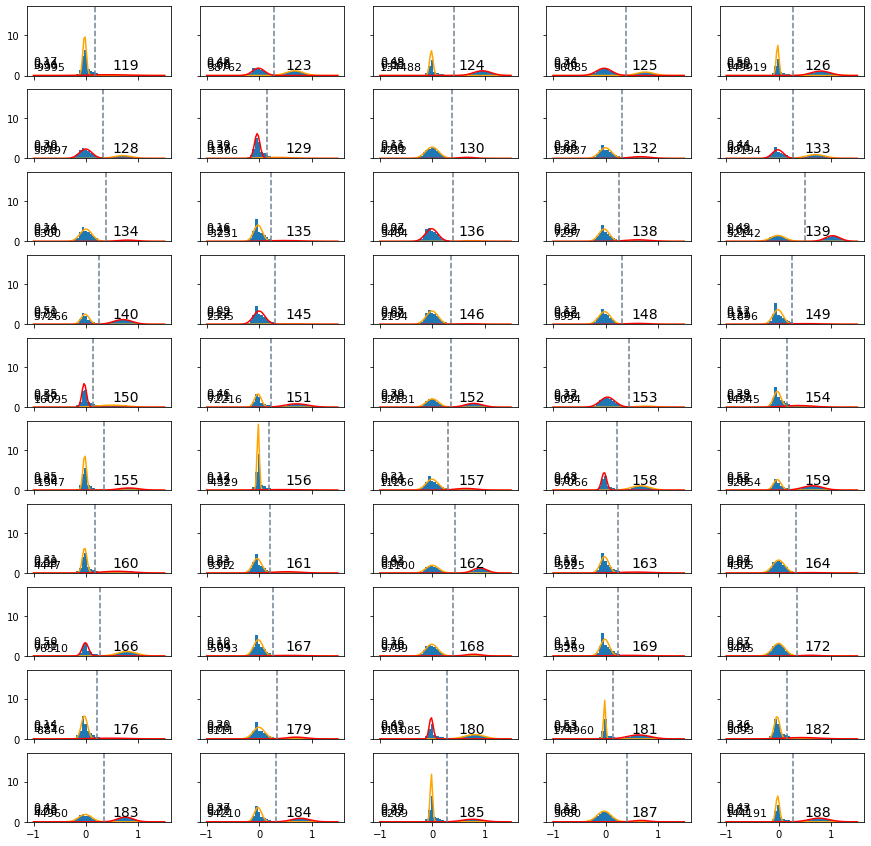

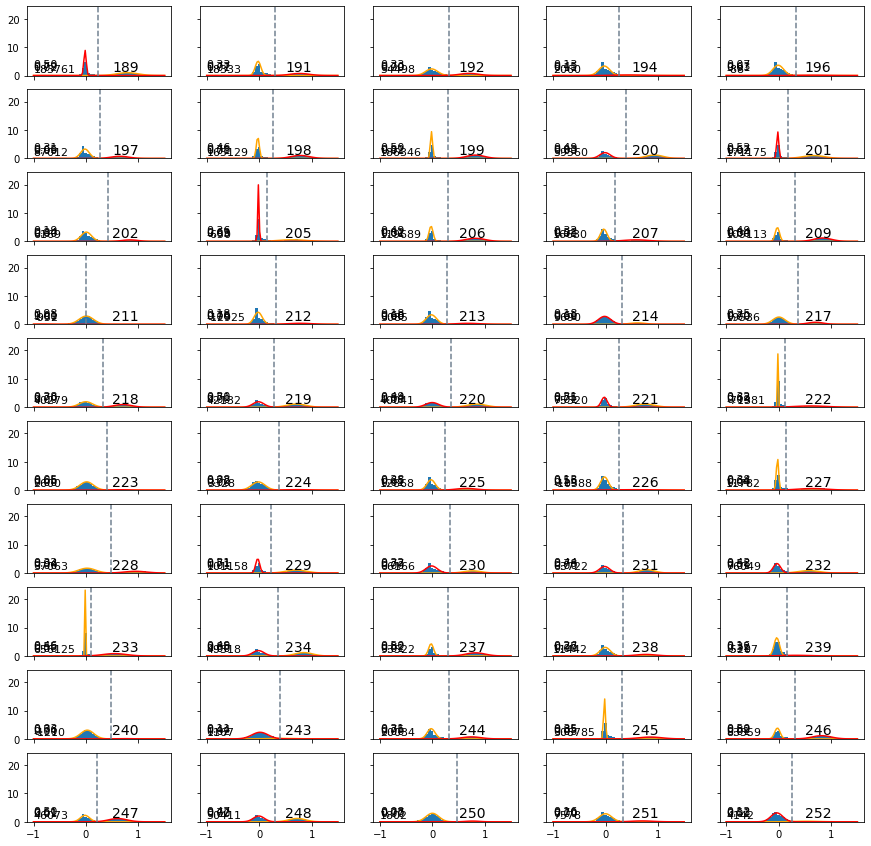

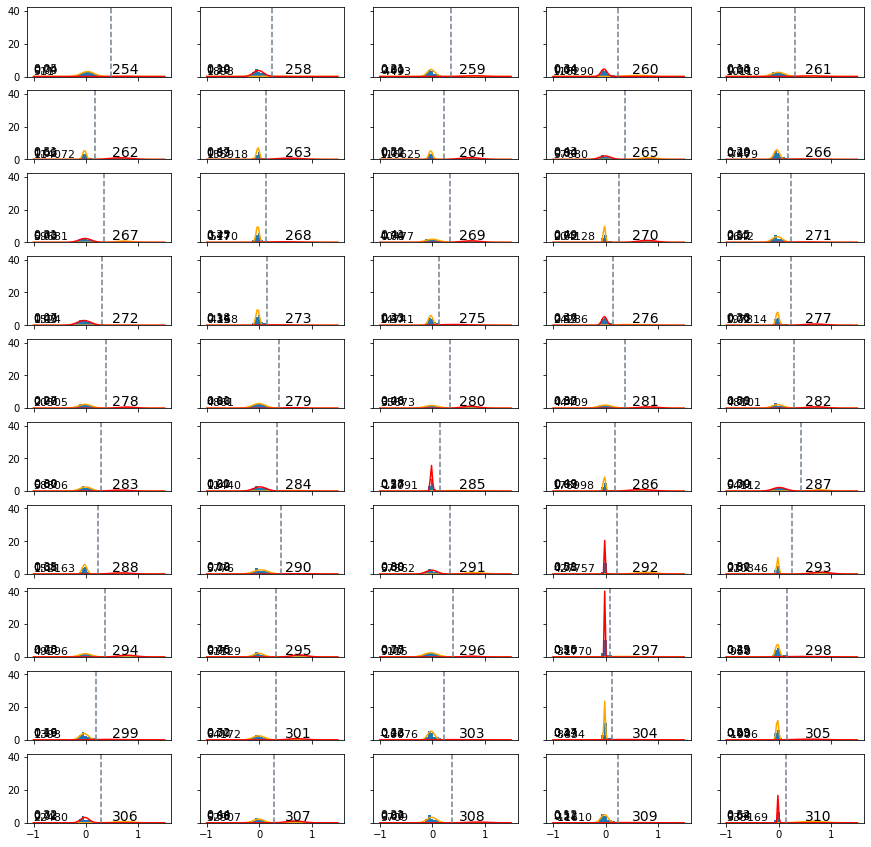

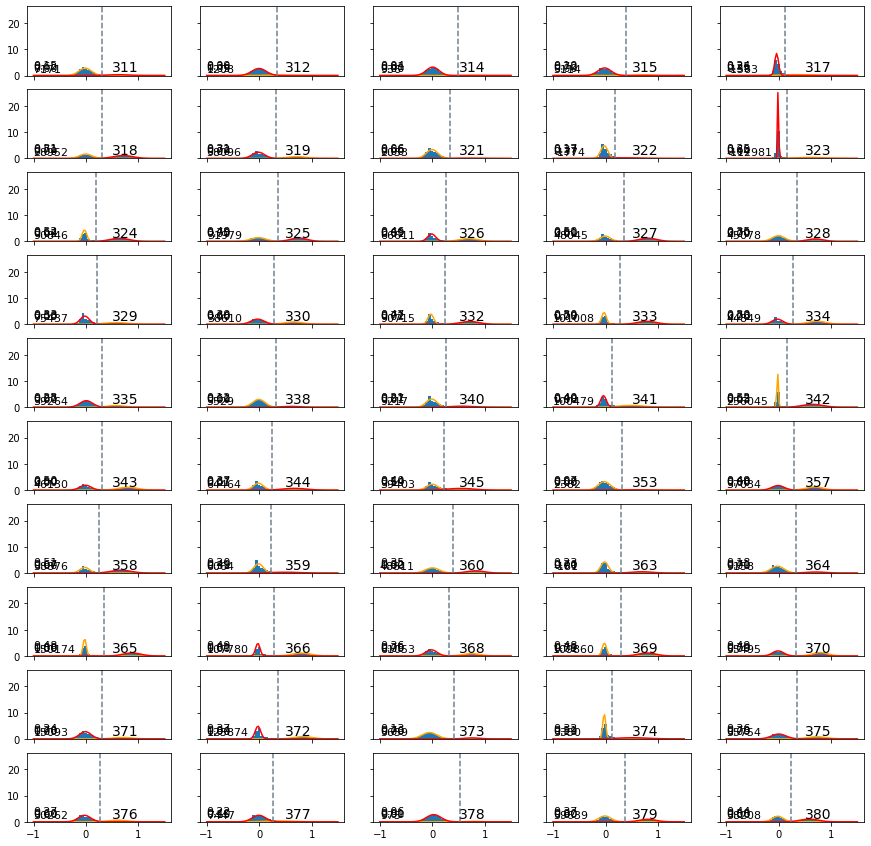

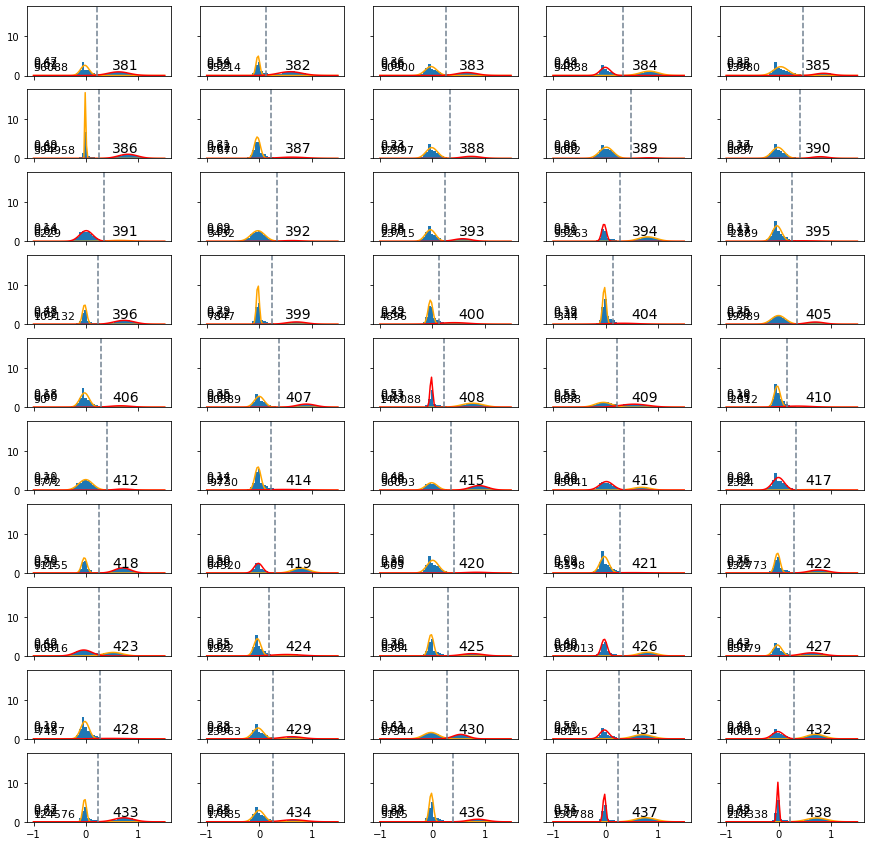

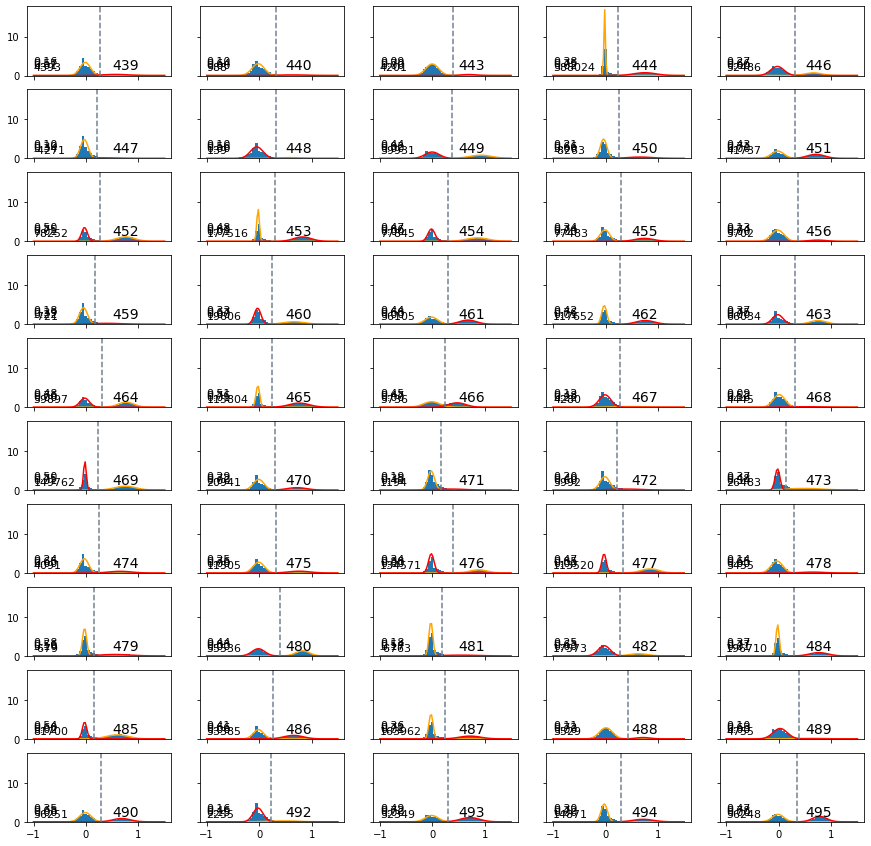

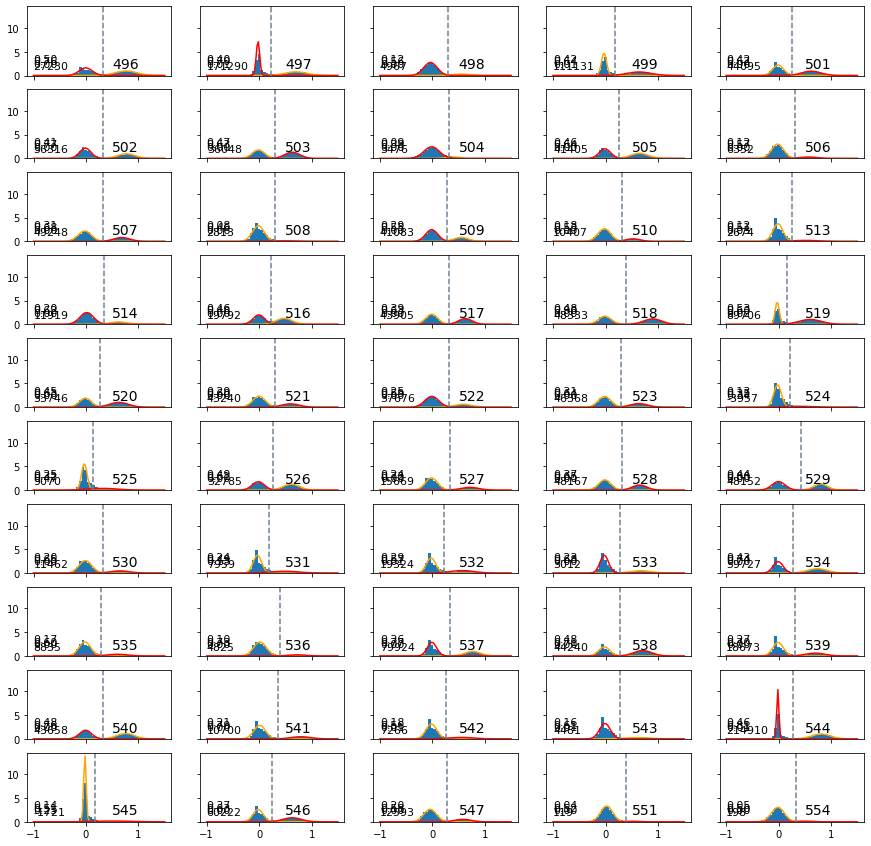

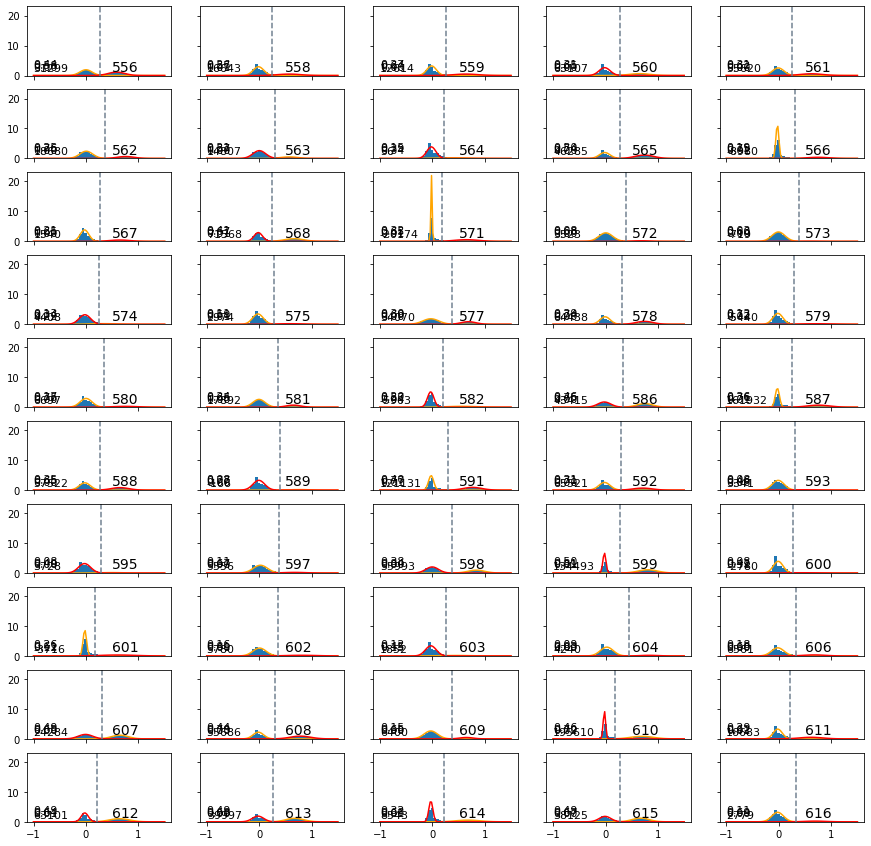

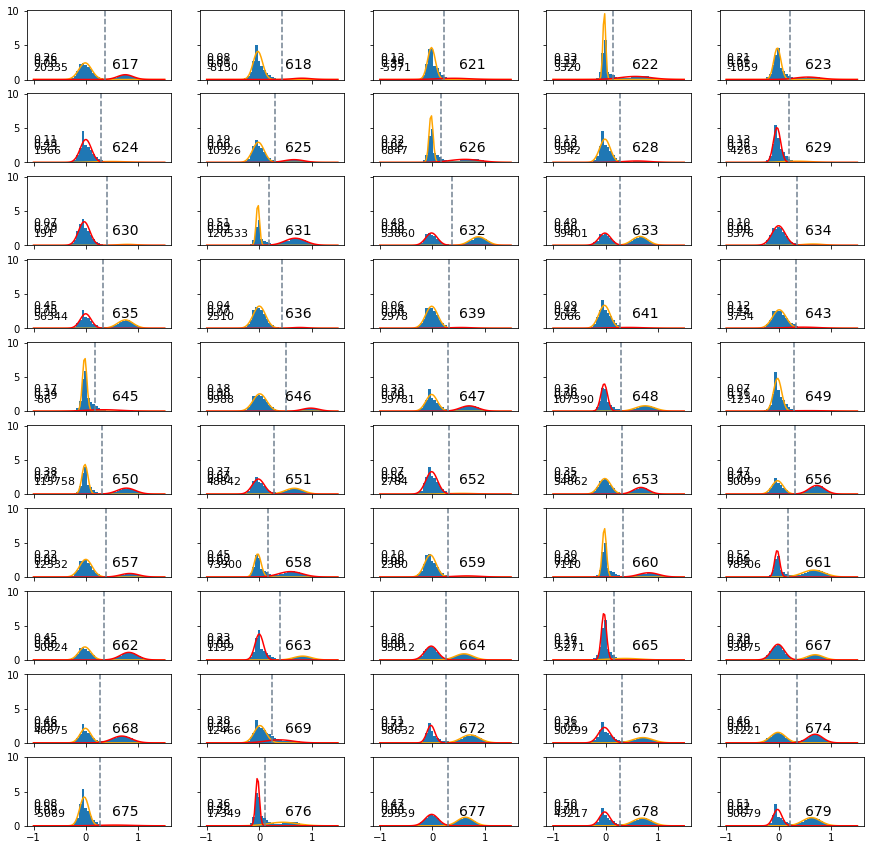

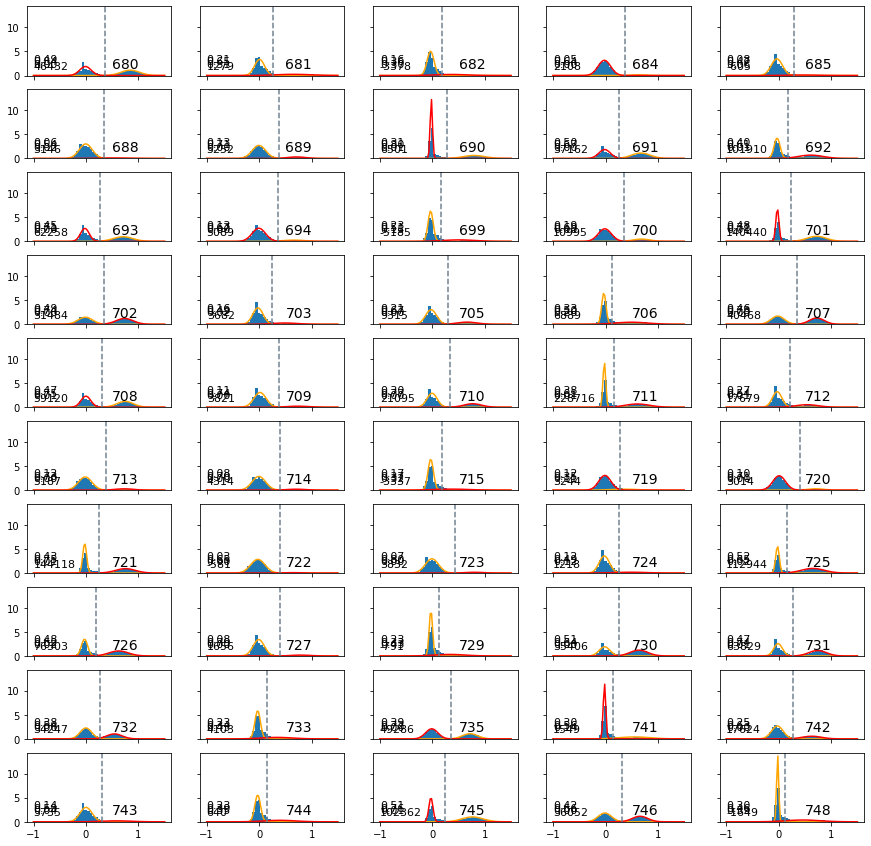

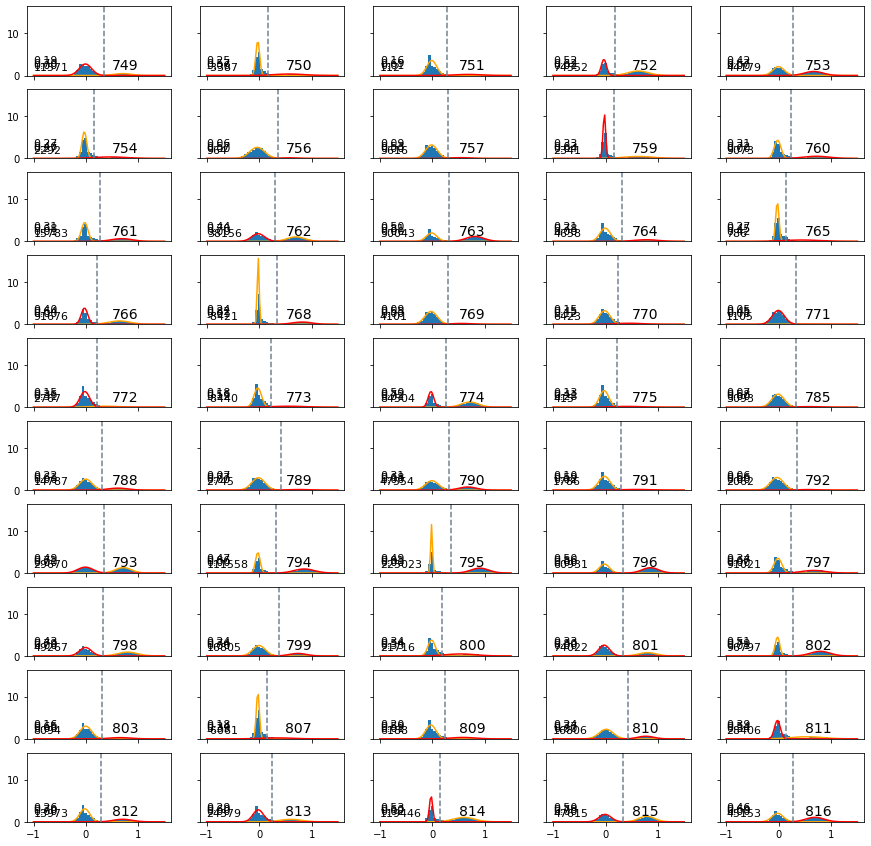

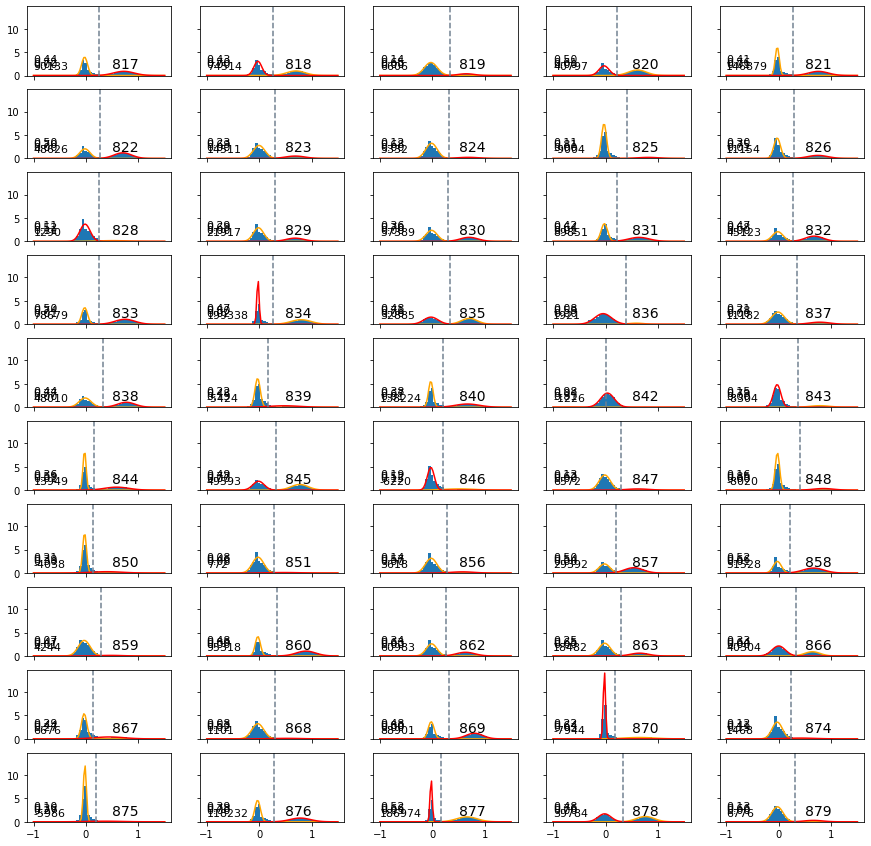

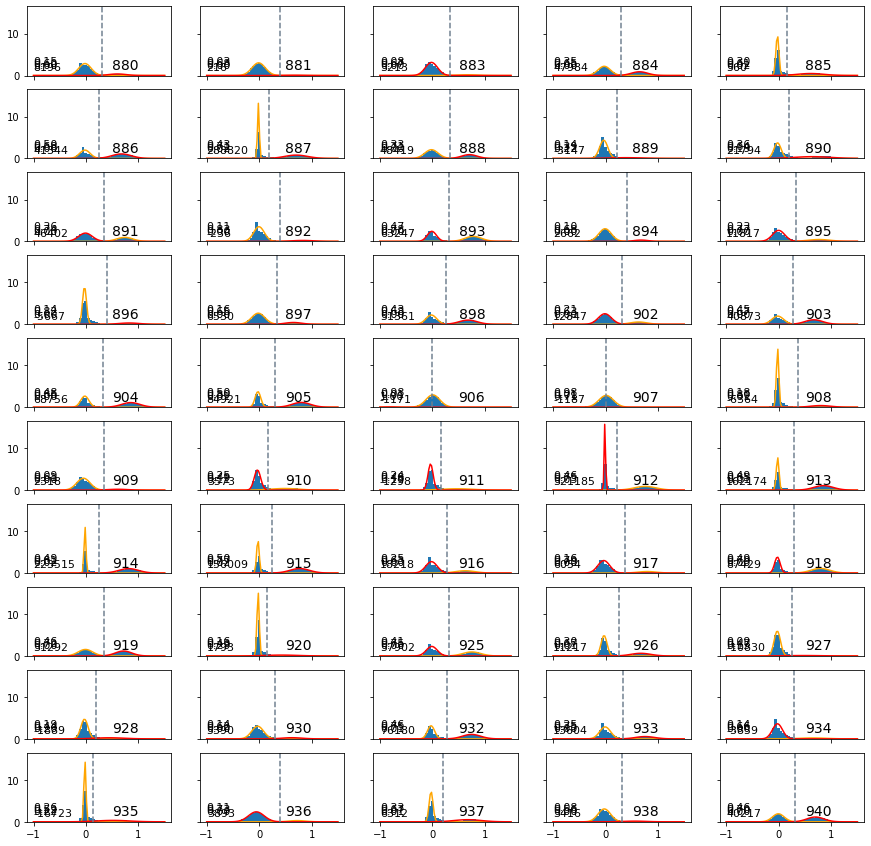

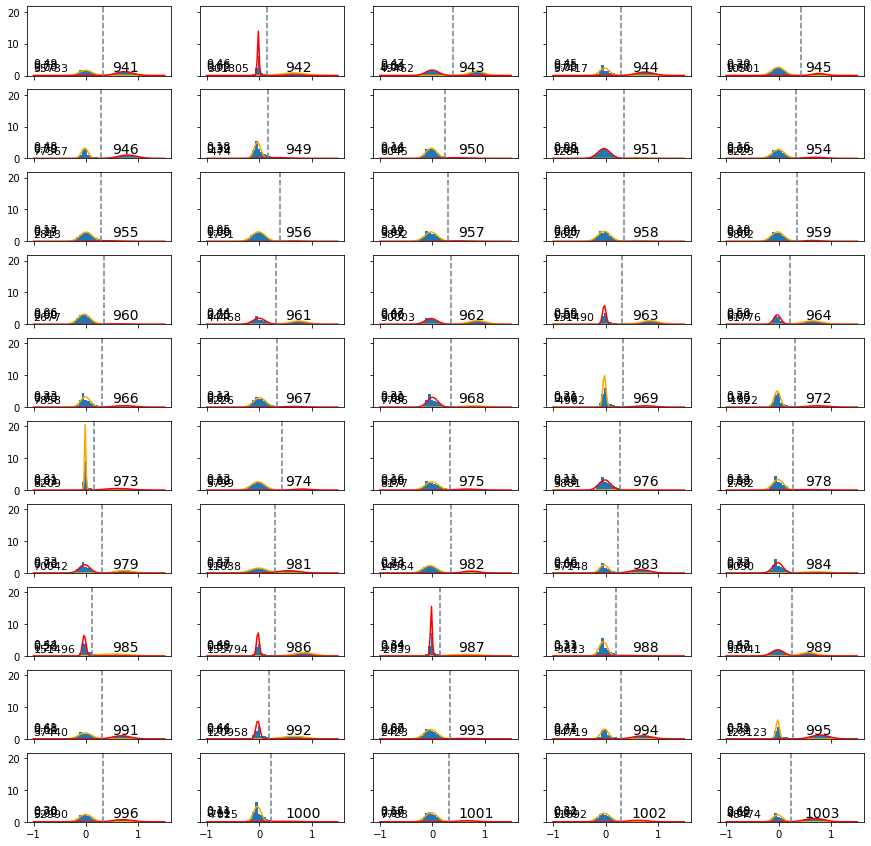

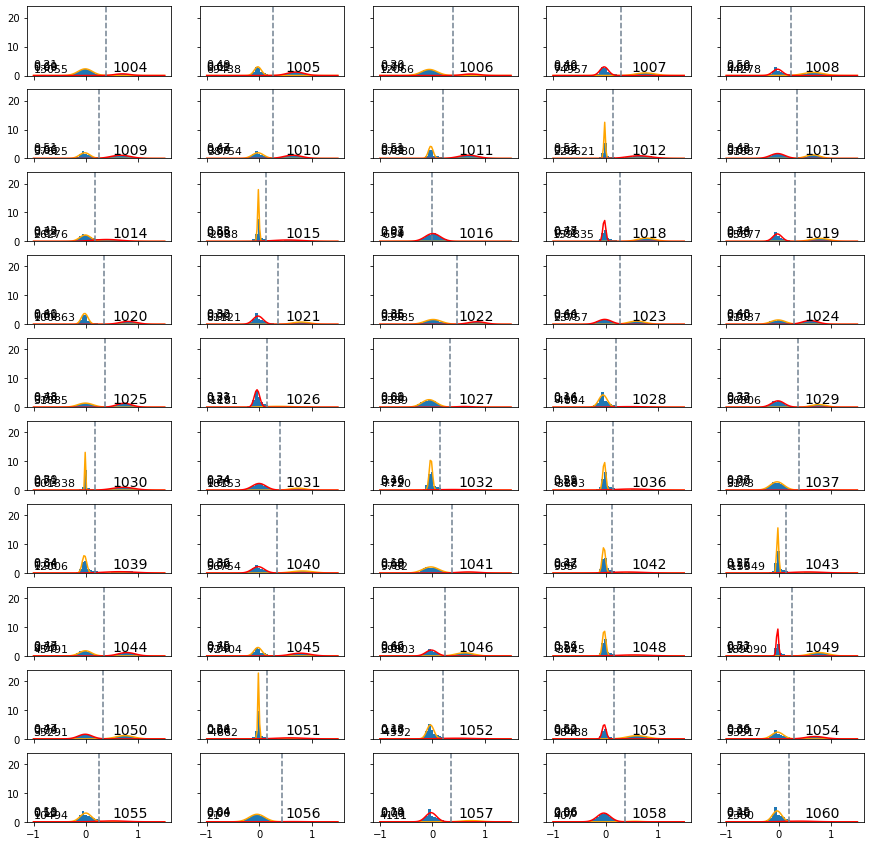

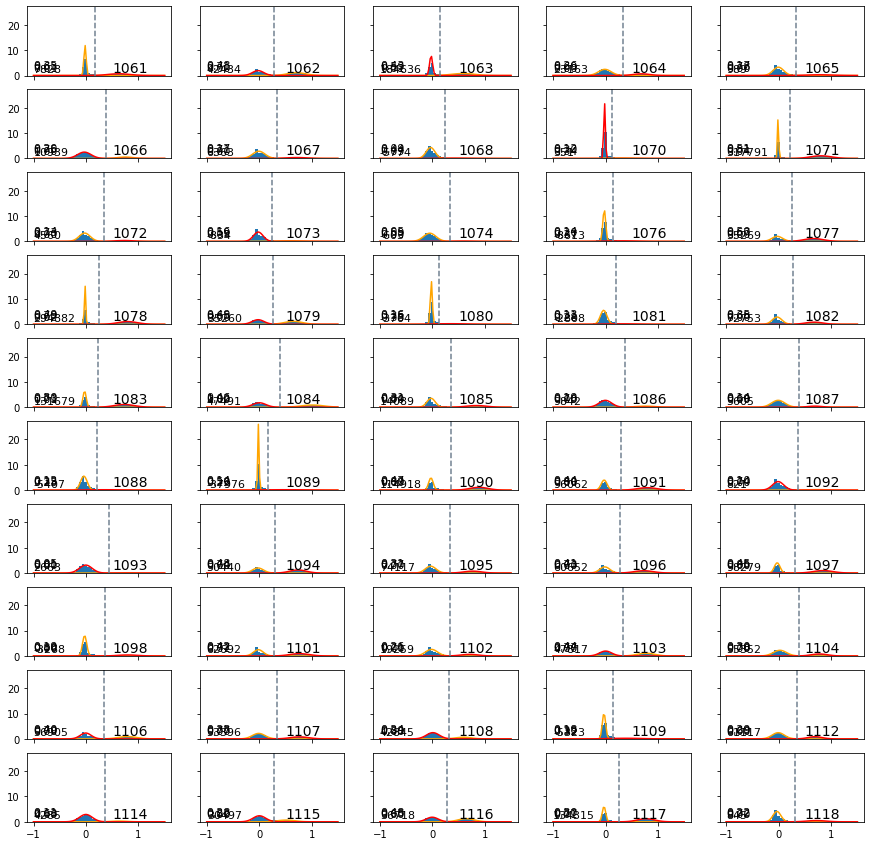

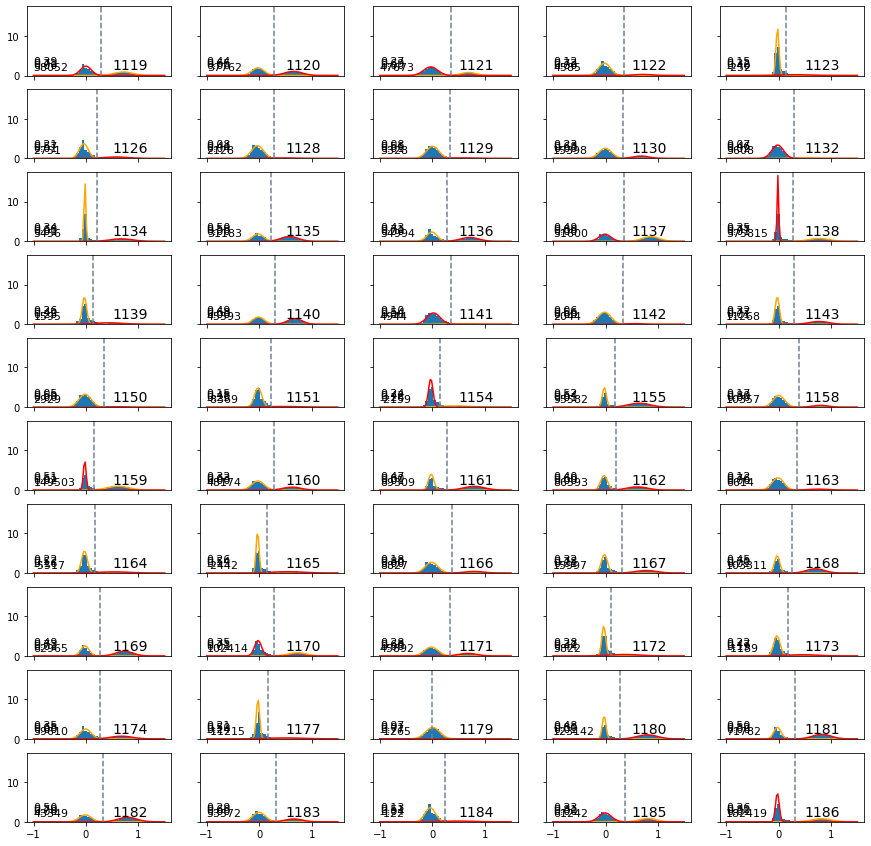

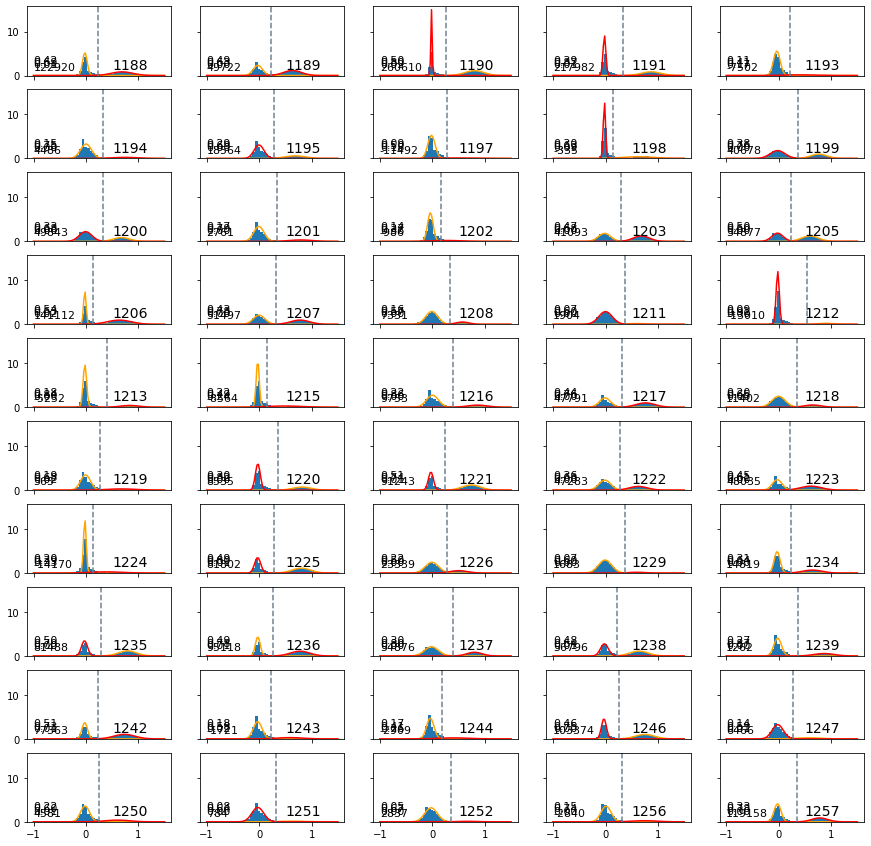

In [86]:
# plot a lot of the good bases. Make sure that they do look like good cutoffs between methylated and unmethylated

figw = 5
figh = 10
figind = 50

x=np.linspace(-1,1.5,100)

for b in tqdm(goodbase[0:1000], position=0):
    
    dat = concdat[:,b]
    usedat = dat[~np.isnan(dat)].reshape(-1,1)
    
    if figind >= (figw * figh):
        fig, ax = plt.subplots(figh, figw, figsize=(15, 15), sharex=True, sharey=True)
        figind = 0
        
    ax[int(figind / figw), figind % figw].hist(usedat, np.linspace(-1, 1.5, 50), density=True)
    for comp, col in [(0,'orange'), (1,'red')]:
        ax[int(figind / figw), figind % figw].plot(x, smmFitd[b].weights[comp]*stats.norm.pdf(x, loc=smmFitd[b].means[comp][0], scale=np.sqrt(smmFitd[b].covariances[comp][0][0])), color=col)
    #ax[int(figind / figw), figind % figw].axvline(x=cutoff, ls='--', color='slategray')
    ax[int(figind / figw), figind % figw].axvline(x=smmfd['cutoff'][b], ls='--', color='slategray')
    ax[int(figind / figw), figind % figw].text(.5,1.5, b, fontsize=14)
    ax[int(figind / figw), figind % figw].text(-1,2.8, '{:.2f}'.format(smmfd['weighthigh'][b]), fontsize=11)
    ax[int(figind / figw), figind % figw].text(-1,2.3, '{:.2f}'.format(smmfd['meanhigh'][b]), fontsize=11)
    ax[int(figind / figw), figind % figw].text(-1,1.8, '{:.2f}'.format(smmfd['lowprob'][b]), fontsize=11)
    ax[int(figind / figw), figind % figw].text(-1,1.3, '{:.0f}'.format(smmfd['aicd'][b]), fontsize=11)
    figind += 1
    #plt.xlabel('residual')

In [34]:
methpreds = []
for samp in samplenames:
    if samp == 'chrom_HP10621':
        continue
    residuals = samples[samp][0]
    methpred = binarizer(residuals)
    methpreds.append(methpred)

IndexError: list index out of range

100%|██████████| 78628/78628 [3:03:38<00:00,  7.14it/s]  


MemoryError: Unable to allocate 3.98 GiB for an array with shape (152816, 3494) and data type float64

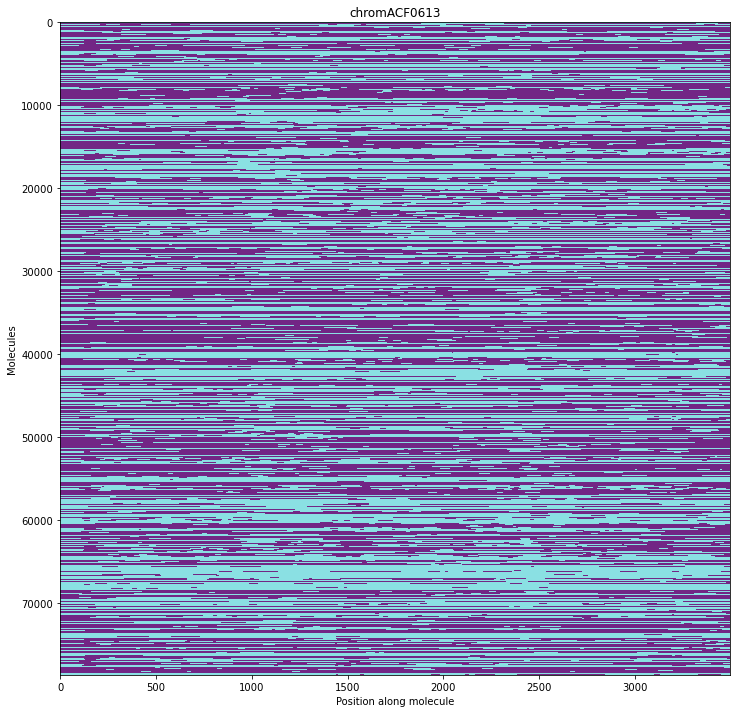

In [52]:
#now run solved hmm

#database = '/sadra/ramanilab/camillem/results/pacbio/220627_ACF_Hp1a_CM/ccs4.99_heatmaps/'
database = '/home/cmoore/results/pacbio/220627_ACF_Hp1a_CM/ccs4.99_heatmaps/'
arrays = []
for index, methpred in enumerate(methpreds):
    Arr = hmm_solver(methpred, index, database)
    arrays.append(Arr)
    

## HMM model for classifying accessibility
21/06/10

In [104]:
negArr = hmm_solver(negmethpred)



 68%|██████▊   | 44281/65392 [1:37:29<46:28,  7.57it/s]  


KeyboardInterrupt: 

In [115]:
posArr = hmm_solver(posmethpred)
ten2oneArr = hmm_solver(ten2methpred)

100%|██████████| 22914/22914 [54:03<00:00,  7.06it/s]


In [122]:
for methpred in methpreds:
    Arr = hmm_solver(ten220628methpred)

  4%|▎         | 361/9989 [01:10<31:07,  5.16it/s]


KeyboardInterrupt: 

In [ ]:
heatmapper(ten220628Arr)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


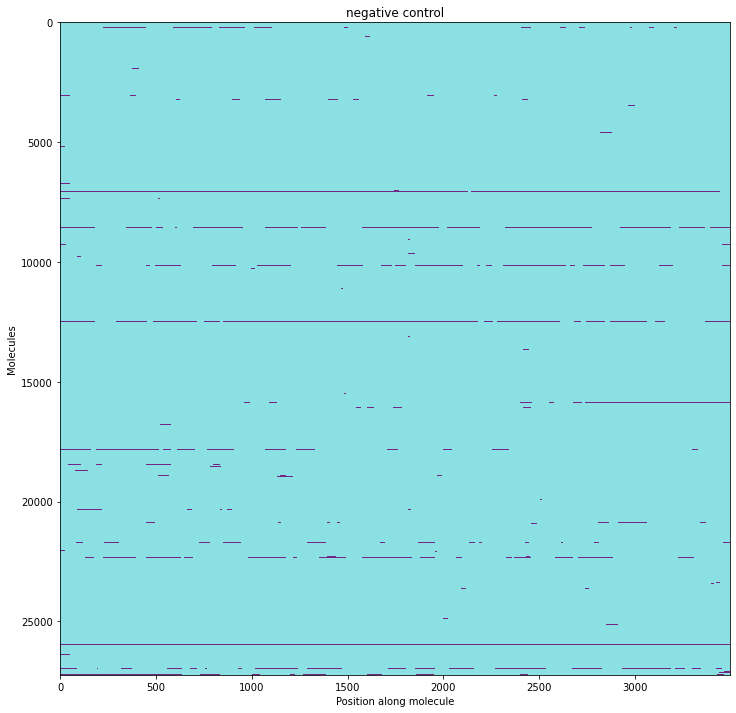

In [114]:
heatmapper(negArr, 'negative control')


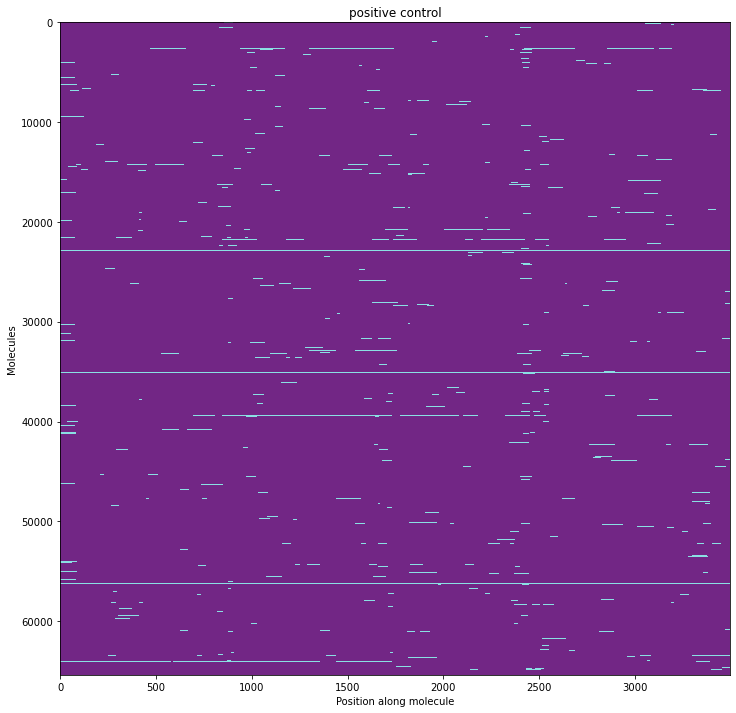

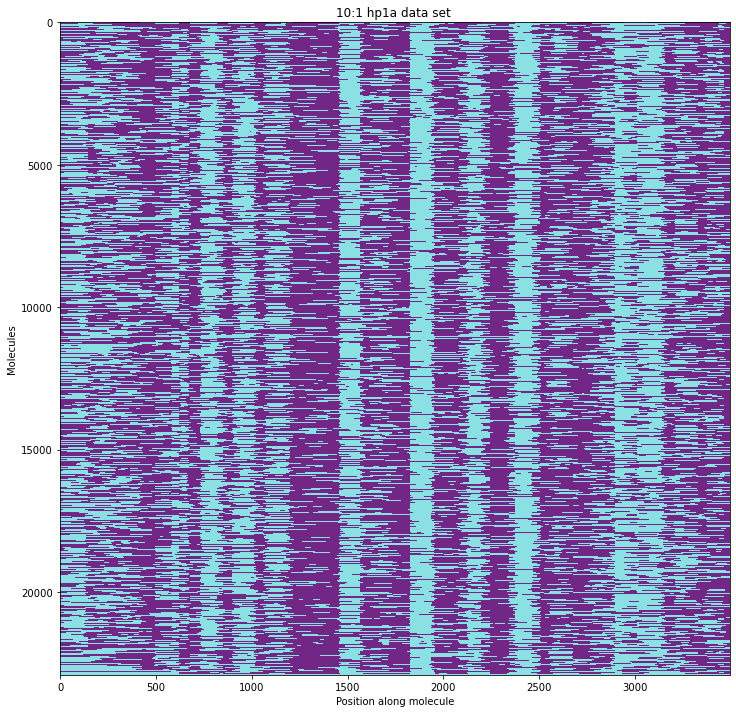

In [117]:
heatmapper(posArr, 'positive control')
heatmapper(ten2oneArr, '10:1 hp1a data set ')

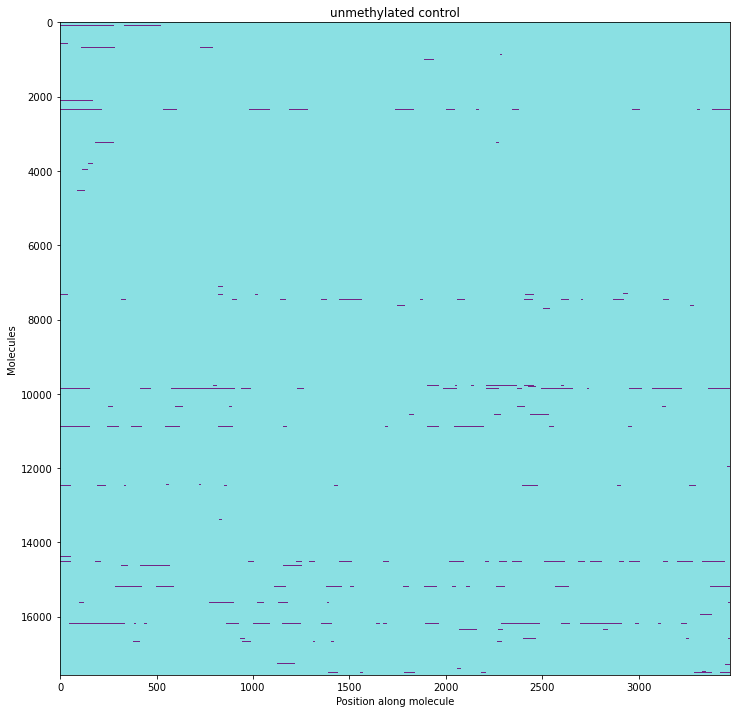

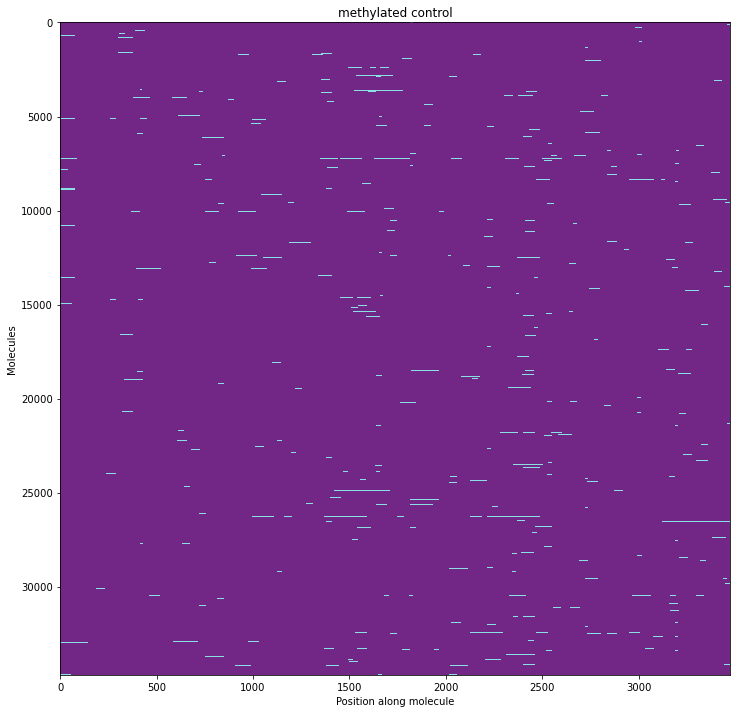

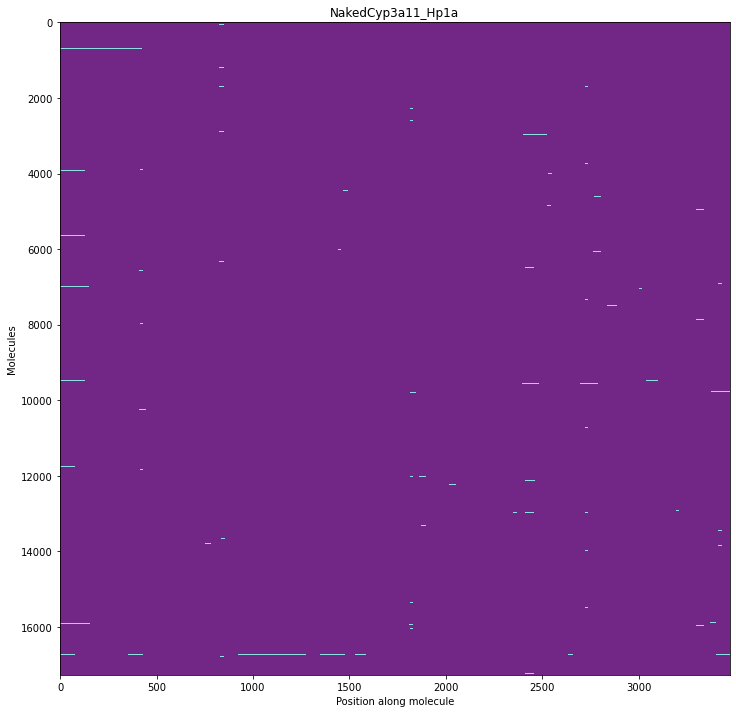

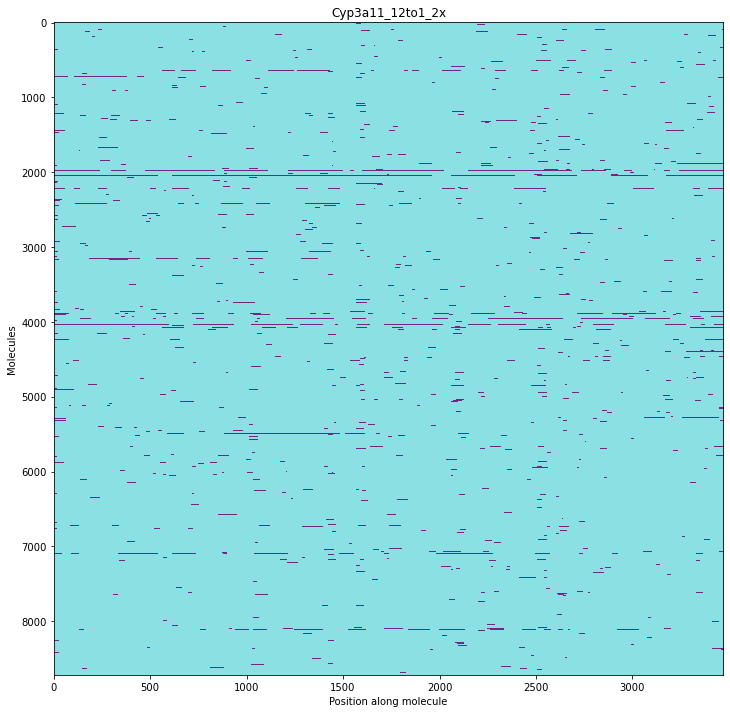

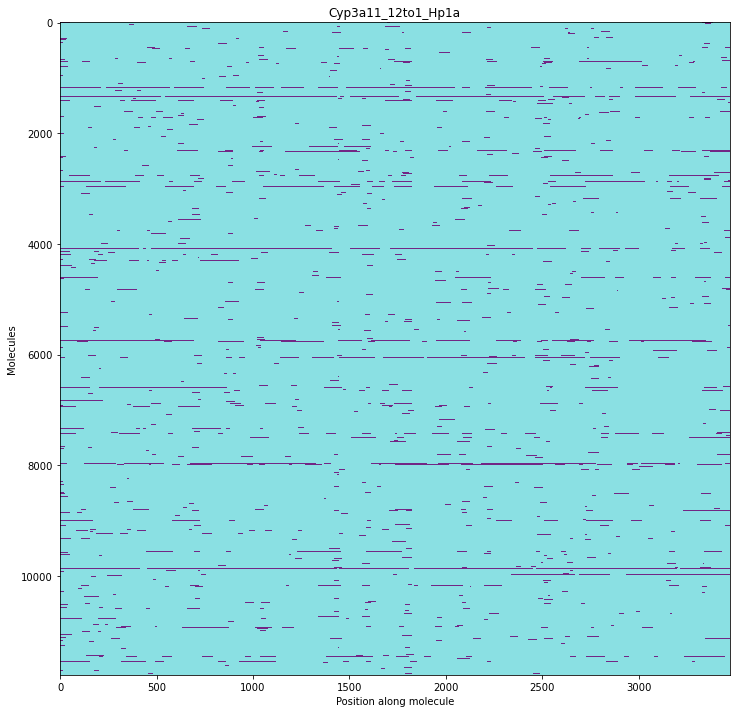

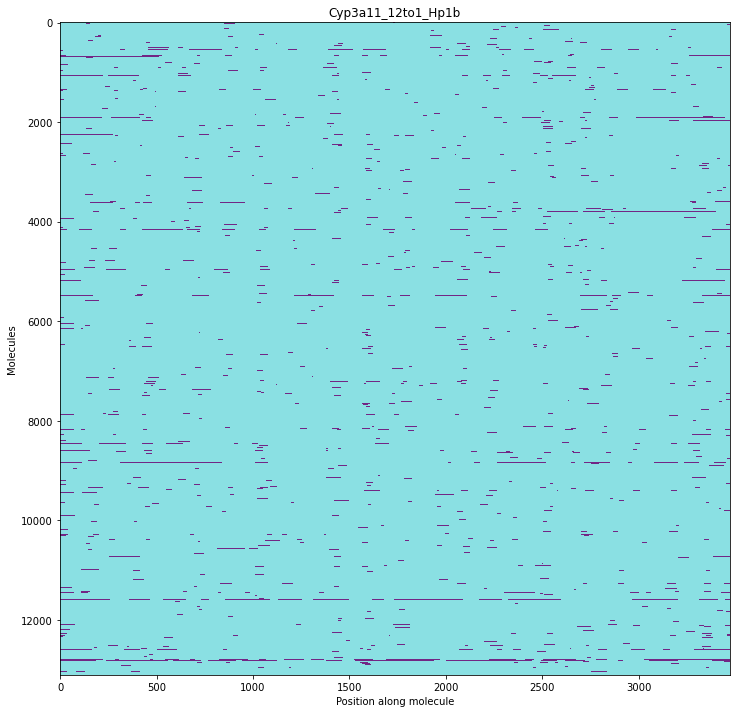

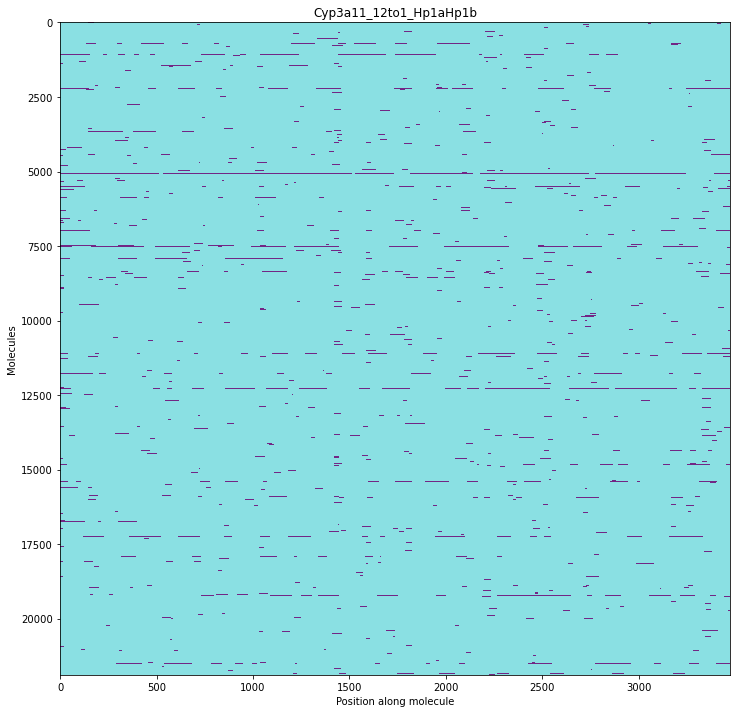

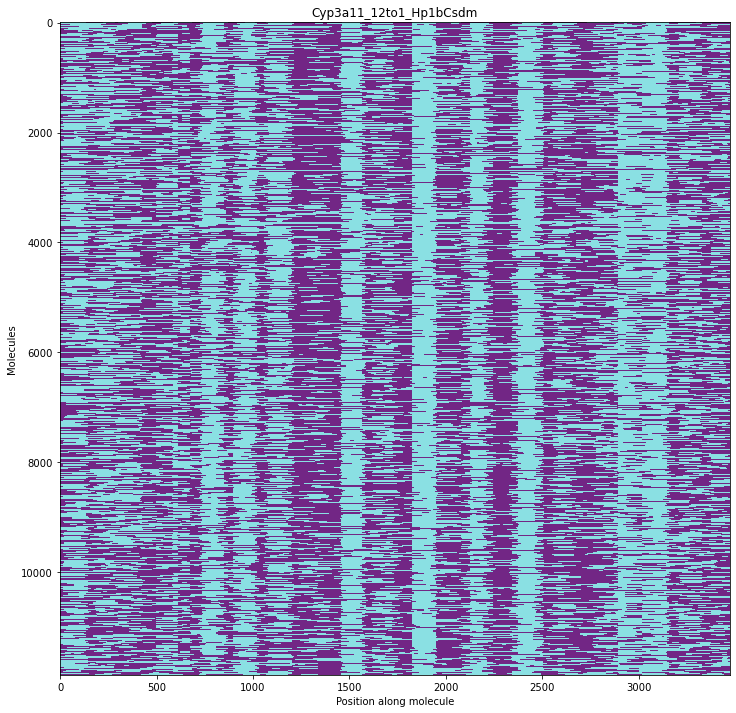

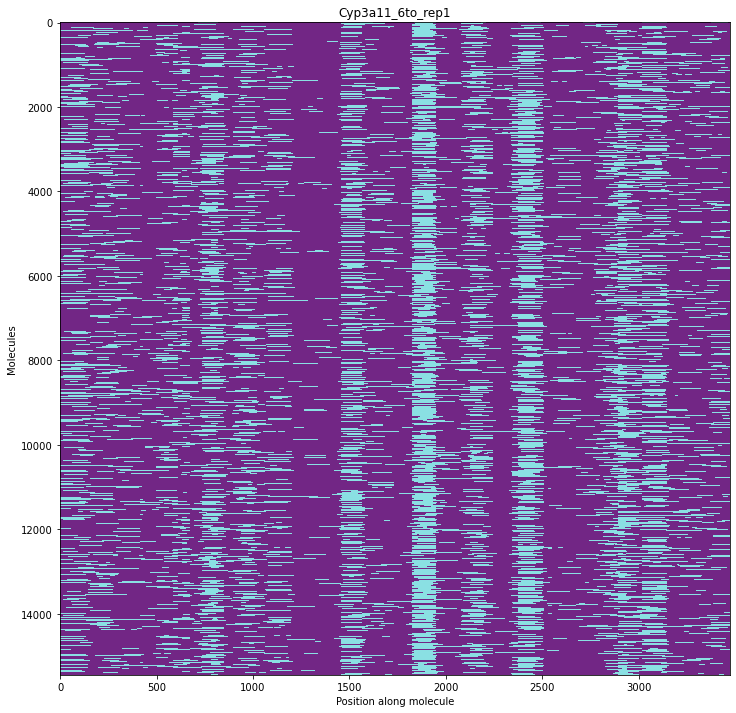

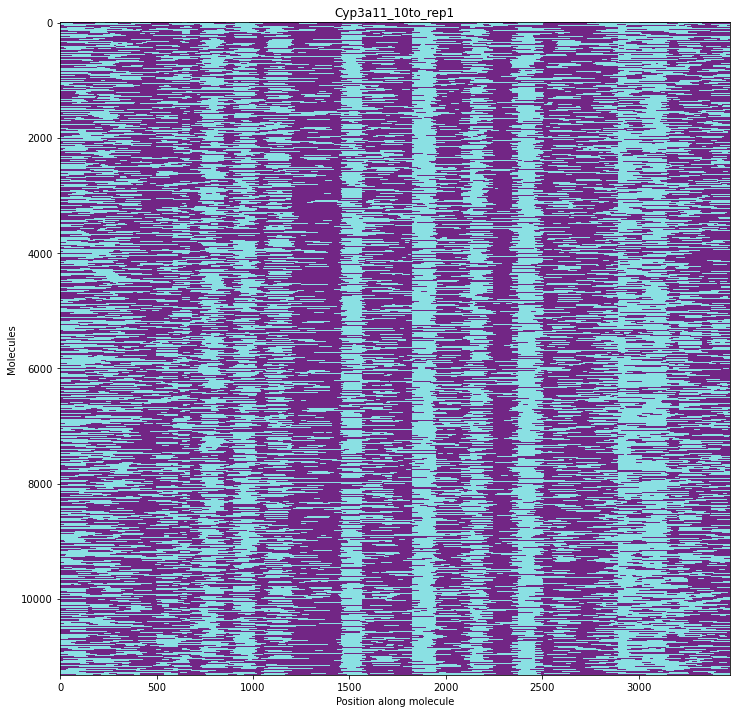

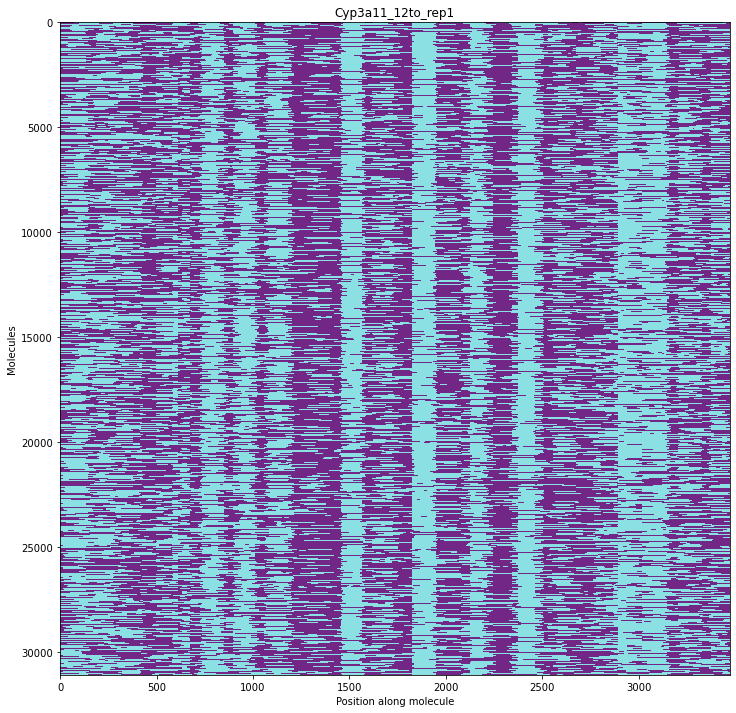

In [103]:
## plot a heatmap showing the HMM accessibility

cmapbin = matplotlib.colors.LinearSegmentedColormap.from_list('custom cmap', ['#8ae0e3','#722685'], 3) #['midnightblue', 'coral']
bounds = np.array([-0.5, .5, 1.5])
norm = matplotlib.colors.BoundaryNorm(bounds, cmapbin.N)


#for samp in np.append([0], useSamples[amplicon]):
for samp in np.arange(0,11): 
  
    hmmRes = np.load('./results/pacbio/211101_CM_Cyp3a11_HP1/processed/binarized/211101_CM_Cyp3a11_HP1_%s_HMM.npy' % (sampleRef['sampleName'][samp])  )

    plt.figure(figsize=(12,12))
    plt.imshow(hmmRes, aspect='auto', interpolation='none',cmap = cmapbin, norm=norm)
    plt.ylabel('Molecules')
    plt.xlabel('Position along molecule')
    
    if samp == 0:
        plt.title('unmethylated control')
    
    elif samp == 1: 
        plt.title('methylated control')
    else:
        plt.title(sampleRef['sampleName'][samp])

Text(0.5, 0, 'Position along molecule')

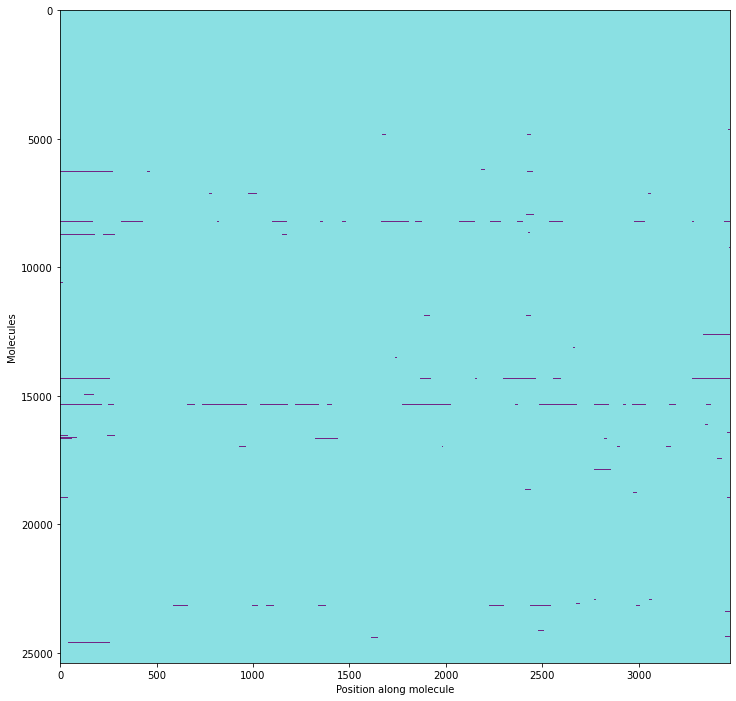

In [102]:
#take sum of methylation in hmmRes down every column
hmmRes = np.load('./results/pacbio/211101_CM_Cyp3a11_HP1_rep2/processed/binarized/211101_CM_Cyp3a11_HP1_rep2_NakedCyp3a11_noM_HMM.npy')
plt.figure(figsize=(12,12))
plt.imshow(hmmRes, aspect='auto', interpolation='none',cmap = cmapbin, norm=norm)
plt.ylabel('Molecules')
plt.xlabel('Position along molecule')
    


Text(0.5, 0, 'Position on molecule')

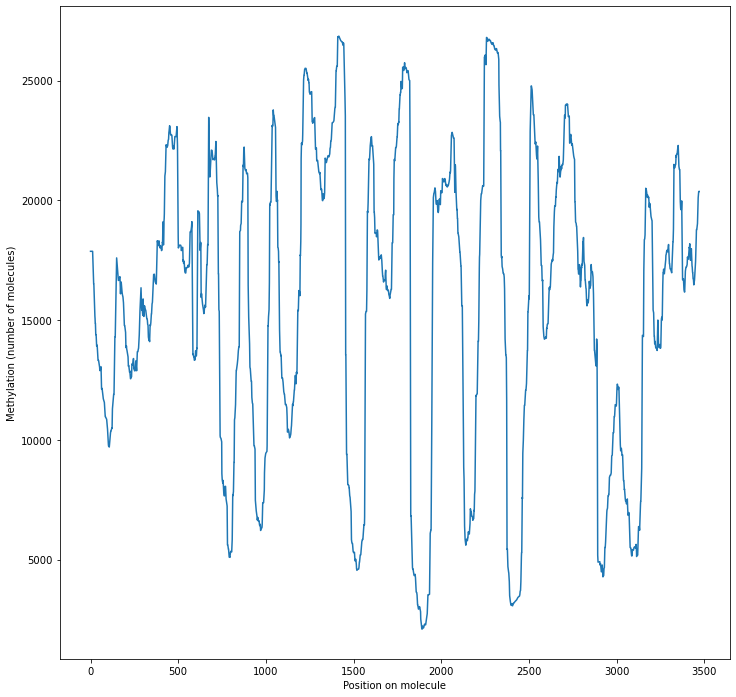

In [38]:
hmmSum = np.sum(hmmRes, axis=0)
hmmSum
plt.figure(figsize=(12,12))
plt.plot(range(0,len(hmmSum)), hmmSum)
plt.ylabel('Methylation (number of molecules)')
plt.xlabel('Position on molecule')
    

In [42]:
mostMethyl = np.where(hmmSum > 25000, hmmSum, 0)
mostMethyl

array([0., 0., 0., ..., 0., 0., 0.])

In [45]:
np.argwhere(hmmSum>25000).flatten()

array([1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225,
       1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236,
       1237, 1238, 1239, 1240, 1241, 1242, 1243, 1399, 1400, 1401, 1402,
       1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413,
       1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424,
       1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435,
       1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446,
       1447, 1448, 1449, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786,
       1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797,
       1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808,
       1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819,
       1820, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255,
       2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266,
       2267, 2268, 2269, 2270, 2271, 2272, 2273, 22

In [46]:
np.argwhere(hmmSum<5000).flatten()

array([1508, 1509, 1510, 1511, 1514, 1515, 1516, 1517, 1518, 1519, 1520,
       1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531,
       1532, 1533, 1534, 1535, 1835, 1836, 1837, 1838, 1839, 1840, 1841,
       1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852,
       1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863,
       1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874,
       1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885,
       1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896,
       1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907,
       1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918,
       1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929,
       1930, 1931, 1932, 1933, 1934, 1935, 2379, 2380, 2381, 2382, 2383,
       2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394,
       2395, 2396, 2397, 2398, 2399, 2400, 2401, 24

In [ ]:
count number of AT dinucleotides,